In [ ]:
import zipfile
import pandas as pd
import polars as pl
import geopandas as gpd
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import re
import pycountry
import geodata
from tqdm import tqdm
from zipfile import ZipFile
from geopy.geocoders import Nominatim
import time
import urllib.request
import pycountry
from google.colab import files
import matplotlib.pyplot as plt
import contextily as ctx
import fiona
import tools
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import unicodedata
import pickle
import osmnx as ox
from concurrent.futures import ThreadPoolExecutor, as_completed
from shapely.geometry import Point
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import bambi as bmb
import arviz as az
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf

In [ ]:
FONTSIZE = 18
params = {
         'axes.labelsize': FONTSIZE,
         'axes.titlesize': FONTSIZE,
         'xtick.labelsize':FONTSIZE,
         'legend.fontsize':FONTSIZE,
         'ytick.labelsize':FONTSIZE}

plt.rcParams.update(params)

image_folder = '/content/Linking-Plastic-to-Dengue-Incidence/plots'
data_folder = '/content/Linking-Plastic-to-Dengue-Incidence/data'
os.makedirs(image_folder, exist_ok=True)
os.makedirs(data_folder, exist_ok=True)

In [ ]:
# Load the file
plastic_dengue_atmosphere = gpd.read_file(f"{data_folder}/plastic_dengue_atmosphere_gdf.gpkg")

# Reproject to World Mollweide (suitable for global area-preserving calculations)
gdf_projected = plastic_dengue_atmosphere.to_crs(epsg=3857)

# Compute centroids in projected space
gdf_projected["centroid"] = gdf_projected.geometry.centroid

# Create GeoDataFrame from centroids and reproject back to EPSG:4326
gdf_projected = gdf_projected.set_geometry("centroid")
gdf_centroids = gdf_projected.to_crs(epsg=4326)

# Extract Point geometry back into original GeoDataFrame
plastic_dengue_atmosphere["centroid"] = gdf_centroids.geometry
plastic_dengue_atmosphere = plastic_dengue_atmosphere.drop(columns=["ERA5land_t2m", "ERA5land_tp"])

plastic_dengue_atmosphere.head()

adm_0_name ISO3 Income_cat    adm_1_name       adm_2_name   Unique_ID  \
0  argentina  ARG        UMC  buenos aires  almirante brown   ARG.1.4_1   
1  argentina  ARG        UMC  buenos aires       avellaneda   ARG.1.7_1   
2  argentina  ARG        UMC     rio negro       avellaneda   ARG.1.7_1   
3  argentina  ARG        UMC  buenos aires             azul   ARG.1.9_1   
4  argentina  ARG        UMC  buenos aires     bahia blanca  ARG.1.10_1   

        GID_2  Population_2020  Rural_share  Deg_Urban_Lv1  ...  \
0   ARG.1.4_1    560097.564993     0.003252              3  ...   
1   ARG.1.7_1    399825.426948     0.001051              3  ...   
2  ARG.16.2_1    399825.426948     0.001051              3  ...   
3   ARG.1.9_1     74203.968586     0.213579              3  ...   
4  ARG.1.10_1    322362.958835     0.034462              3  ...   

   plas_inf_ob_em_pct_em  plas_form_deb_em_pct_em  plas_form_ob_em_pct_em  \
0               0.090610                      0.0                     0.0   
1               0.073099                      0.0                     0.0   
2               0.073099                      0.0                     0.0   
3               0.412950                      0.0                     0.0   
4               0.236495                      0.0                     0.0   

   people_no_col  people_no_col_pct_pop  mean_dengue_2014_2023   ERA5_t2m  \
0   34990.319466               6.247183                   61.5  17.314585   
1    9760.323288               2.441146                  360.0  17.630055   
2    9760.323288               2.441146                    2.0  15.835646   
3   12513.923624              16.864224                    2.0  14.879260   
4   26344.491008               8.172307                    3.0  15.509579   

      ERA5_tp                                           geometry  \
0  279.710384  MULTIPOLYGON (((-58.39741 -34.91209, -58.40034...   
1  293.873937  MULTIPOLYGON (((-58.33411 -34.73055, -58.33783...   
2  114.102148  MULTIPOLYGON (((-66.64465 -38.53105, -66.64307...   
3  272.429956  MULTIPOLYGON (((-59.49092 -36.23094, -59.2936 ...   
4  200.357109  MULTIPOLYGON (((-62.21736 -38.83569, -62.21625...   

                      centroid  
0  POINT (-58.36831 -34.83864)  
1  POINT (-58.34009 -34.68142)  
2  POINT (-66.22107 -39.41774)  
3  POINT (-59.69994 -36.79136)  
4  POINT (-62.16959 -38.58023)  

[5 rows x 69 columns]

In [ ]:
plastic_dengue_atmosphere.shape

(6473, 69)

In [ ]:
plastic_dengue_atmosphere

adm_0_name ISO3 Income_cat     adm_1_name  \
0                    argentina  ARG        UMC   buenos aires   
1                    argentina  ARG        UMC   buenos aires   
2                    argentina  ARG        UMC      rio negro   
3                    argentina  ARG        UMC   buenos aires   
4                    argentina  ARG        UMC   buenos aires   
...                        ...  ...        ...            ...   
6468  united states of america  USA        HIC          texas   
6469  united states of america  USA        HIC  west virginia   
6470  united states of america  USA        HIC          texas   
6471  united states of america  USA        HIC          texas   
6472  united states of america  USA        HIC          texas   

           adm_2_name     Unique_ID         GID_2  Population_2020  \
0     almirante brown     ARG.1.4_1     ARG.1.4_1    560097.564993   
1          avellaneda     ARG.1.7_1     ARG.1.7_1    399825.426948   
2          avellaneda     ARG.1.7_1    ARG.16.2_1    399825.426948   
3                azul     ARG.1.9_1     ARG.1.9_1     74203.968586   
4        bahia blanca    ARG.1.10_1    ARG.1.10_1    322362.958835   
...               ...           ...           ...              ...   
6468          hidalgo   USA.32.13_1  USA.44.108_1      4233.620577   
6469             wood   USA.36.88_1   USA.49.54_1    127984.873892   
6470            starr  USA.44.214_1  USA.44.214_1     60583.734587   
6471             webb  USA.44.240_1  USA.44.240_1    321010.853765   
6472          willacy  USA.44.245_1  USA.44.245_1     21693.088750   

      Rural_share  Deg_Urban_Lv1  ...  plas_inf_ob_em_pct_em  \
0        0.003252              3  ...               0.090610   
1        0.001051              3  ...               0.073099   
2        0.001051              3  ...               0.073099   
3        0.213579              3  ...               0.412950   
4        0.034462              3  ...               0.236495   
...           ...            ...  ...                    ...   
6468     1.000000              1  ...               0.000000   
6469     0.423629              2  ...               0.000000   
6470     0.443965              2  ...               0.000000   
6471     0.050707              3  ...               0.000000   
6472     0.494932              2  ...               0.000000   

      plas_form_deb_em_pct_em  plas_form_ob_em_pct_em  people_no_col  \
0                         0.0                     0.0   34990.319466   
1                         0.0                     0.0    9760.323288   
2                         0.0                     0.0    9760.323288   
3                         0.0                     0.0   12513.923624   
4                         0.0                     0.0   26344.491008   
...                       ...                     ...            ...   
6468                      0.0                     0.0       0.000000   
6469                      0.0                     0.0       0.000000   
6470                      0.0                     0.0       0.000000   
6471                      0.0                     0.0       0.000000   
6472                      0.0                     0.0       0.000000   

      people_no_col_pct_pop  mean_dengue_2014_2023   ERA5_t2m     ERA5_tp  \
0                  6.247183                   61.5  17.314585  279.710384   
1                  2.441146                  360.0  17.630055  293.873937   
2                  2.441146                    2.0  15.835646  114.102148   
3                 16.864224                    2.0  14.879260  272.429956   
4                  8.172307                    3.0  15.509579  200.357109   
...                     ...                    ...        ...         ...   
6468               0.000000                   10.0  24.141939  201.885482   
6469               0.000000                    2.0  13.236760  445.570117   
6470               0.000000                    2.0  24.200617  183.3819

#### Checking the distribution

#### Plastic Litter

In [ ]:
# import matplotlib.pyplot as plt

# plastic_dengue_atmosphere["plas_litter_em"].hist(bins=30, edgecolor='black')
# plt.title("Distribution of plas_litter_em")
# plt.xlabel("Value")
# plt.ylabel("Frequency")
# plt.show()


# import seaborn as sns

# sns.kdeplot(plastic_dengue_atmosphere["plas_litter_em"], fill=True)
# plt.title("KDE Plot of plas_litter_em")
# plt.xlabel("Value")
# plt.ylabel("Density")
# plt.show()

# plastic_dengue_atmosphere["plas_litter_em"].describe()

# from scipy.stats import skew, kurtosis

# print("Skew:", skew(plastic_dengue_atmosphere["plas_litter_em"]))
# print("Kurtosis:", kurtosis(plastic_dengue_atmosphere["plas_litter_em"]))

# #  Add a log-transformed column (use log1p to handle zeros safely)
# plastic_dengue_atmosphere["plas_litter_em_log"] = np.log1p(plastic_dengue_atmosphere["plas_litter_em"])

# #  Compute mean and standard deviation of the log-transformed values
# log_mean = plastic_dengue_atmosphere["plas_litter_em_log"].mean()
# log_std = plastic_dengue_atmosphere["plas_litter_em_log"].std()

# print("Mean of log-transformed data:", log_mean)
# print("Standard deviation of log-transformed data:", log_std)



In [ ]:
# plt.hist(plastic_dengue_atmosphere["plas_litter_em_log"])

#### Dengue distribution

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Histogram
# plt.hist(plastic_dengue_atmosphere["mean_dengue_2014_2023"], bins=30)
# plt.title("Histogram of Dengue")
# plt.xlabel("Value")
# plt.ylabel("Frequency")
# plt.show()

# # KDE plot
# sns.kdeplot(plastic_dengue_atmosphere["mean_dengue_2014_2023"], fill=True)
# plt.title("KDE of Dengue")
# plt.xlabel("Value")
# plt.ylabel("Density")
# plt.show()

# print(plastic_dengue_atmosphere["mean_dengue_2014_2023"].describe())

# from scipy.stats import skew, kurtosis

# print("Skew:", skew(plastic_dengue_atmosphere["mean_dengue_2014_2023"]))
# print("Kurtosis:", kurtosis(plastic_dengue_atmosphere["mean_dengue_2014_2023"]))

# import numpy as np

# # Add 1 to handle zeros (use log1p)
# plastic_dengue_atmosphere["dengue_log"] = np.log1p(plastic_dengue_atmosphere["mean_dengue_2014_2023"])

# # Plot log-transformed histogram
# plt.hist(plastic_dengue_atmosphere["dengue_log"], bins=30)
# plt.title("Histogram of Log-Transformed Dengue")
# plt.xlabel("Log Dengue")
# plt.ylabel("Frequency")
# plt.show()


# df['log_dengue'] = np.log1p(df['mean_dengue_2014_2023'])
# log_mean = plastic_dengue_atmosphere["dengue_log"].mean()
# log_std = plastic_dengue_atmosphere["dengue_log"].std()

# print("Mean of log-dengue:", log_mean)
# print("Std of log-dengue:", log_std)



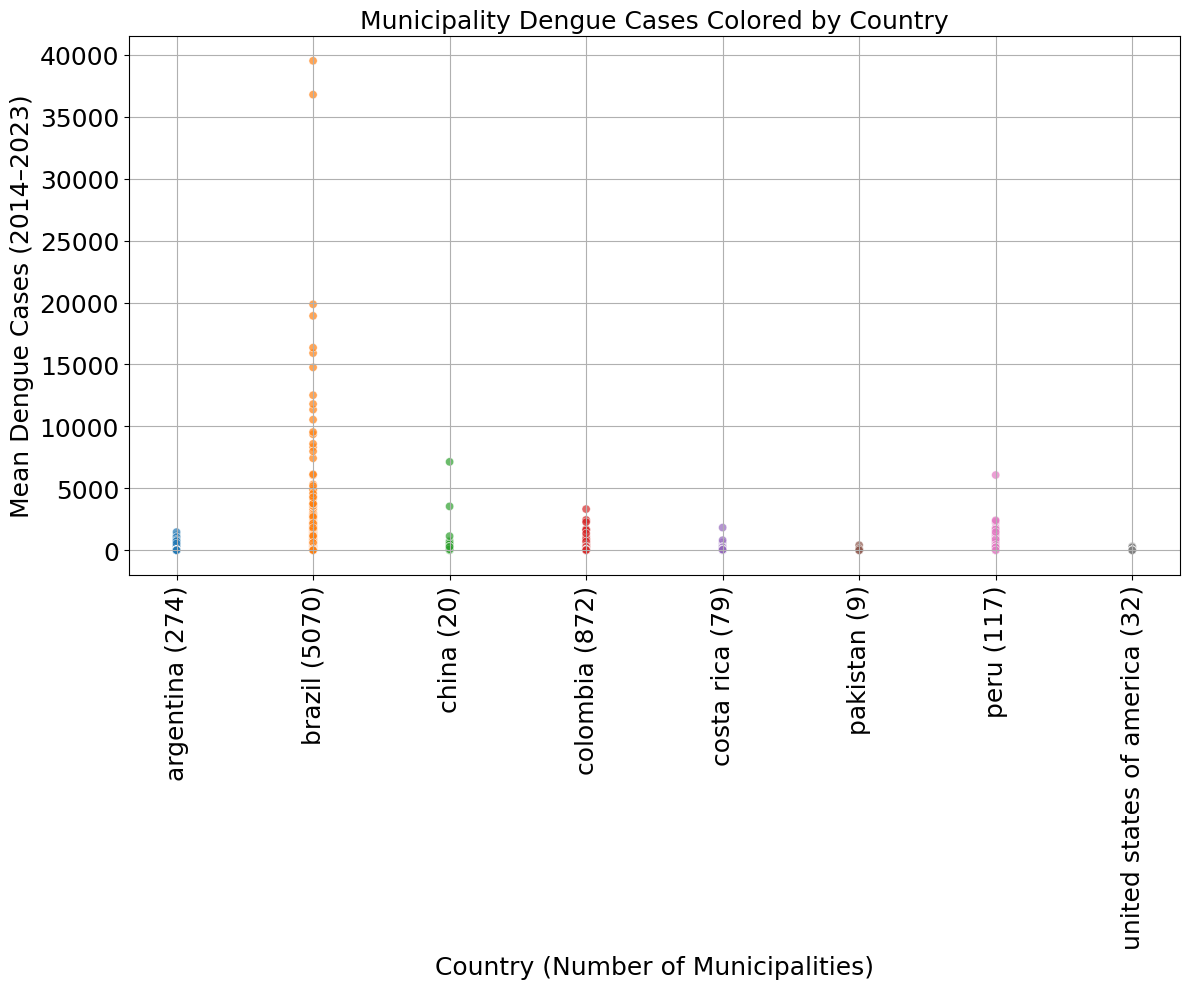

In [ ]:
# Count municipalities per country
municipality_counts = plastic_dengue_atmosphere['adm_0_name'].value_counts()

# Create new labels: country name + (number)
new_labels = [f"{country} ({municipality_counts[country]})" for country in plastic_dengue_atmosphere['adm_0_name'].unique()]
# Scatter plot: one dot per municipality, color by country
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=plastic_dengue_atmosphere,
    x='adm_0_name',         # Country on x-axis
    y='mean_dengue_2014_2023',   # Dengue counts on y-axis
    hue='adm_0_name',        # Different colors for different countries
    legend=False,            # Hide legend if too many countries (optional)
    alpha=0.7                # Slightly transparent dots
)

plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=90)
plt.xlabel('Country (Number of Municipalities)')
plt.ylabel('Mean Dengue Cases (2014–2023)')
plt.title('Municipality Dengue Cases Colored by Country')
plt.grid(True)
plt.tight_layout()
plt.show()

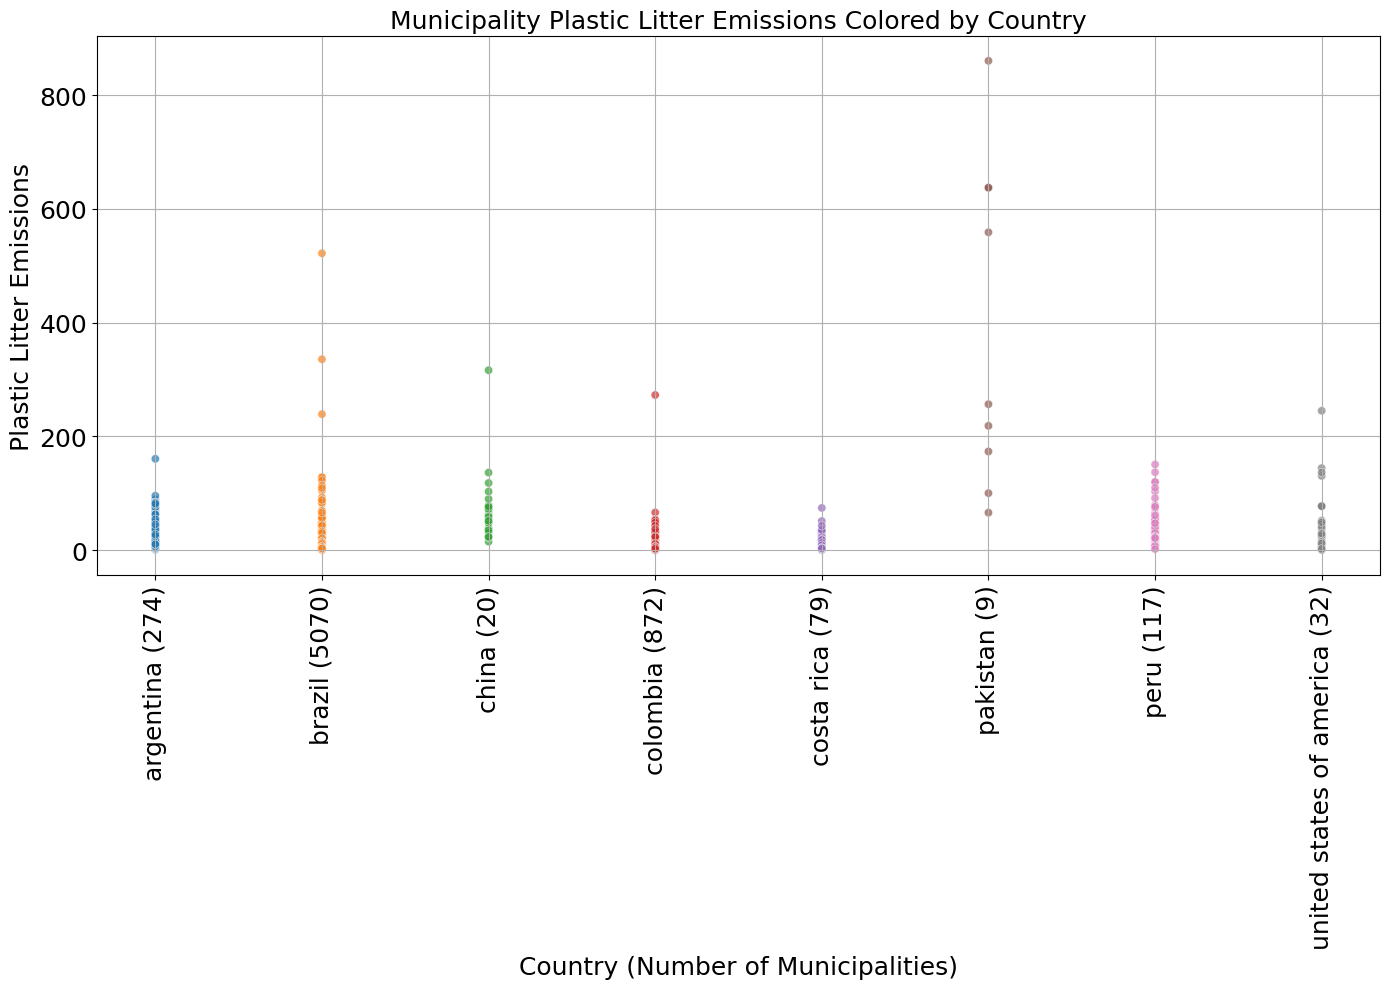

In [ ]:
# Count municipalities per country a
municipality_counts = plastic_dengue_atmosphere['adm_0_name'].value_counts()

# New labels
new_labels = [f"{country} ({municipality_counts[country]})" for country in plastic_dengue_atmosphere['adm_0_name'].unique()]

# Plot for plastic litter emissions
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=plastic_dengue_atmosphere,
    x='adm_0_name',
    y='plas_litter_em',
    hue='adm_0_name',
    legend=False,
    alpha=0.7
)

plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=90)
plt.xlabel('Country (Number of Municipalities)')
plt.ylabel('Plastic Litter Emissions')
plt.title('Municipality Plastic Litter Emissions Colored by Country')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gdp = pd.read_csv("/content/data/DENGUE/gdp.csv", encoding="latin1", low_memory=False)
gdp = gdp[["Country Name", "2020 [YR2020]"]]
gdp = gdp.rename(columns={"Country Name": "adm_0_name", "2020 [YR2020]": "gdp"})
gdp.head()

adm_0_name               gdp
0     Afghanistan  19955929052.1496
1         Albania  15241458744.8688
2         Algeria  164873415325.201
3  American Samoa         721000000
4         Andorra   2891001149.3611

In [ ]:
# Standardize location names
def clean_location(name):
    if pd.isna(name):  # Handle NaN values
        return name
    name = name.strip().lower()  # Convert to lowercase and remove extra spaces
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("utf-8")  # Remove accents
    name = re.sub(r"\bprovince of\b", "", name)  # Remove 'province of'
    name = re.sub(r"\btownship\b|\bdist\b|\bcd\b", "", name)  # Remove 'township', 'dist', 'cd'
    name = re.sub(r"\bcity of\b", "", name)  # Remove 'city of'
    name = re.sub(r"\bcity\b", "", name)  # Remove 'city'
    name = re.sub(r"\bcounty\b", "", name)  # Remove 'city of'
    name = re.sub(r"[^a-z\s]", "", name)  # Remove special characters
    name = re.sub(r"\s+", " ", name)  # Replace multiple spaces with a single space
    return name.strip()

# Apply the updated cleaning function
gdp["adm_0_name"] = gdp["adm_0_name"].astype(str).apply(clean_location)

# Correct country names
country_corrections = {'united states':'united states of america'}
gdp["adm_0_name"] = gdp["adm_0_name"].replace(country_corrections)

gdp = gdp[gdp.adm_0_name.isin(sorted(plastic_dengue_atmosphere.adm_0_name.unique()))].reset_index(drop=True)

# Convert GDP to float
gdp["gdp"] = pd.to_numeric(gdp["gdp"], errors="coerce")

gdp["gdp"] = gdp["gdp"].round(0).astype("Int64")  # allows NaNs too


gdp

adm_0_name             gdp
0                 argentina    385740508437
1                    brazil   1476107231194
2                     china  14687744162801
3                  colombia    270348342541
4                costa rica     62395610760
5                  pakistan    300425609818
6                      peru    201409694756
7  united states of america  21354105000000

In [396]:
# 1. Make sure the column is numeric
gdp["gdp"] = pd.to_numeric(gdp["gdp"], errors="coerce")

# 2. Drop any rows that became NaN
gdp_vals = gdp["gdp"].dropna()

# 3. Sample standard deviation (uses n-1 by default)
sd_gdp = gdp_vals.std()          # same as gdp_vals.std(ddof=1)

print(f"SD of GDP: {sd_gdp:,.0f}")


SD of GDP: 8,338,219,792,082


Merge GDP

In [ ]:
plastic_dengue_atmosphere = plastic_dengue_atmosphere.merge(gdp[["adm_0_name", "gdp"]], on="adm_0_name", how="inner")


In [ ]:
plastic_dengue_atmosphere.adm_0_name.unique()

array(['argentina', 'brazil', 'china', 'colombia', 'costa rica',
       'pakistan', 'peru', 'united states of america'], dtype=object)

In [ ]:
plastic_dengue_atmosphere[plastic_dengue_atmosphere.adm_0_name=='united states of america'][["adm_0_name", "adm_1_name","adm_2_name", 'plas_litter_em', "ERA5_t2m", 'gdp', 'mean_dengue_2014_2023']]

adm_0_name      adm_1_name      adm_2_name  \
6441  united states of america           texas          dallas   
6442  united states of america         florida          monroe   
6443  united states of america         arizona        maricopa   
6444  united states of america         florida            polk   
6445  united states of america      california     los angeles   
6446  united states of america         florida          orange   
6447  united states of america  north carolina          orange   
6448  united states of america      california  san bernardino   
6449  united states of america      california       san diego   
6450  united states of america         florida         broward   
6451  united states of america         florida         collier   
6452  united states of america         florida          hardee   
6453  united states of america         florida    hillsborough   
6454  united states of america         florida         manatee   
6455  united states of america         florida          martin   
6456  united states of america         florida       miamidade   
6457  united states of america         florida         osceola   
6458  united states of america         florida      palm beach   
6459  united states of america         florida           pasco   
6460  united states of america         florida     saint lucie   
6461  united states of america         florida        sarasota   
6462  united states of america         florida         volusia   
6463  united states of america          hawaii          hawaii   
6464  united states of america          hawaii        honolulu   
6465  united states of america  north carolina          wilson   
6466  united states of america           texas         cameron   
6467  united states of america        new york         suffolk   
6468  united states of america           texas         hidalgo   
6469  united states of america   west virginia            wood   
6470  united states of america           texas           starr   
6471  united states of america           texas            webb   
6472  united states of america           texas         willacy   

      plas_litter_em   ERA5_t2m             gdp  mean_dengue_2014_2023  
6441        5.020587  19.598701  21354105000000                    2.0  
6442        3.252864  25.206234  21354105000000                  124.0  
6443      144.445729  23.911275  21354105000000                    2.0  
6444        3.038112  23.304204  21354105000000                    2.0  
6445      245.213736  17.380851  21354105000000                   16.0  
6446       77.856599  22.938966  21354105000000                    2.0  
6447       77.856599  16.259243  21354105000000                    2.0  
6448      130.695995  21.595526  21354105000000                    2.0  
6449      136.852386  16.977832  21354105000000                    2.0  
6450       37.075061  24.897890  21354105000000                   10.0  
6451       25.895112  24.683379  21354105000000                    2.0  
6452        4.235409  23.558958  21354105000000                   20.0  
6453       77.259923  23.201331  21354105000000                    8.0  
6454       21.652371  23.521473  21354105000000                    8.0  
6455       12.549059  24.638460  21354105000000                   18.0  
6456       52.298611  25.078305  21354105000000                  314.0  
6457       26.318431  23.371657  21354105000000                    2.0  
6458       49.329079  24.612934  21354105000000                    7.0  
6459       45.430249  22.756863  21354105000000                   12.0  
6460       22.884225  24.389452  21354105000000                    2.0  
6461       25.912988  23.756048  21354105000000                    2.0  
6462       41.248976  22.629900  21354105000000                    2.0  
6463       29.271829  12.917212  21354105000000                  246.0  
6464       49.338885  24.278397  21354105000000                    2.0  
6465        1.54

In [ ]:
plastic_dengue_atmosphere.columns

Index(['adm_0_name', 'ISO3', 'Income_cat', 'adm_1_name', 'adm_2_name',
       'Unique_ID', 'GID_2', 'Population_2020', 'Rural_share', 'Deg_Urban_Lv1',
       'Deg_Urban_Lv2', 'wg', 'wg_per_cap', 'pwg', 'pwg_per_cap',
       'col_cov_pct_gen_exc_lit', 'col_del_pct_gen', 'litter_em_pct_gen',
       'uncol_em_pct_gen', 'collection_em_pct_gen', 'cont_disp_pct_gen',
       'uncont_disp_pct_gen', 'compost_pct_gen', 'incin_pct_gen',
       'open_burn_MSW', 'open_burn_MSW_pct_gen', 'plas_debris_em',
       'plas_burn_em', 'plas_em', 'plas_debris_em_pct_em',
       'plas_burn_em_pct_em', 'plas_debris_em_per_cap', 'plas_burn_em_per_cap',
       'plas_em_per_cap', 'rigid_plas_deb_em', 'flex_plas_deb_em',
       'rigid_plas_ob_em', 'flex_plas_ob_em', 'rigid_plas_deb_em_pct_em',
       'flex_plas_deb_em_pct_em', 'rigid_plas_ob_em_pct_em',
       'flex_plas_ob_em_pct_em', 'plas_litter_em', 'plas_uncol_em',
       'plas_collection_em', 'plas_disp_em', 'plas_recy_em',
       'plas_litter_em_pct_em', '

In [ ]:
# Show count of NaNs and zeros per column
nan_zero_summary = pd.DataFrame({
    "NaNs": plastic_dengue_atmosphere.isna().sum(),
    "Zeros": (plastic_dengue_atmosphere == 0).sum()
})

print(nan_zero_summary)


            NaNs  Zeros
adm_0_name     0      0
ISO3           0      0
Income_cat     0      0
adm_1_name     0      0
adm_2_name     0      0
...          ...    ...
geometry       0      0
centroid       0      0
gdp_x          0      0
gdp_y          0      0
gdp            0      0

[72 rows x 2 columns]


🛠️ Code to Drop High-Zero Columns (optional threshold)

In [ ]:
# # Drop columns with more than 0 zeros
# high_zero_cols = nan_zero_summary[nan_zero_summary["Zeros"] > 500].index.tolist()
# plastic_dengue_atmosphere = plastic_dengue_atmosphere.drop(columns=high_zero_cols)


Due to VIF Values, manually selecte variables from the Dataframe to use in the model

In [ ]:
# import numpy as np

# # Select only numeric columns and coerce all values
# numeric_df = plastic_dengue_atmosphere.select_dtypes(include=[np.number])
# numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')

# # Remove rows with any NaN or inf
# numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan).dropna()

# # Make sure no object-type column sneaked in
# print(numeric_df.dtypes.unique())


In [ ]:
# Import libraries
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric columns and ensure they are float64
numeric_df_fixed = plastic_dengue_atmosphere.select_dtypes(include=["number"]).astype("float64")

# Create DataFrame for VIF
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_df_fixed.columns
vif_data["VIF"] = [
    variance_inflation_factor(numeric_df_fixed.values, i)
    for i in range(numeric_df_fixed.shape[1])
]

# Sort and display
vif_sorted = vif_data.sort_values(by="VIF", ascending=True).reset_index(drop=True)
print(vif_sorted)


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                      feature           VIF
0                    ERA5_t2m  1.429147e+00
1                     ERA5_tp  1.511106e+00
2       mean_dengue_2014_2023  1.560711e+00
3      plas_form_ob_em_pct_em  1.994456e+00
4     plas_form_deb_em_pct_em  5.374078e+00
..                        ...           ...
58                      gdp_y  1.772772e+08
59                        gdp  1.772772e+08
60      plas_litter_em_pct_em  2.872063e+08
61  plas_litter_deb_em_pct_em  3.055297e+08
62            compost_pct_gen           NaN

[63 rows x 2 columns]


In [ ]:
print(plastic_dengue_atmosphere.shape[1])                 # total columns
print(numeric_df_fixed.shape[1])                          # numeric columns used in VIF
print(numeric_df_fixed.dtypes.value_counts())             # count of float64 columns


72
63
float64    63
Name: count, dtype: int64


In [ ]:
# List of columns to keep
cols_to_keep = ['adm_0_name', 'adm_1_name', 'adm_2_name', 'gdp', 'ERA5_t2m', 'ERA5_tp',
                'mean_dengue_2014_2023', 'pwg', 'plas_form_ob_em_pct_em',
                'plas_litter_em' ]


# Keep only those columns
df = plastic_dengue_atmosphere[cols_to_keep]


In [ ]:
df.columns

Index(['adm_0_name', 'adm_1_name', 'adm_2_name', 'gdp', 'ERA5_t2m', 'ERA5_tp',
       'mean_dengue_2014_2023', 'pwg', 'plas_form_ob_em_pct_em',
       'plas_litter_em'],
      dtype='object')

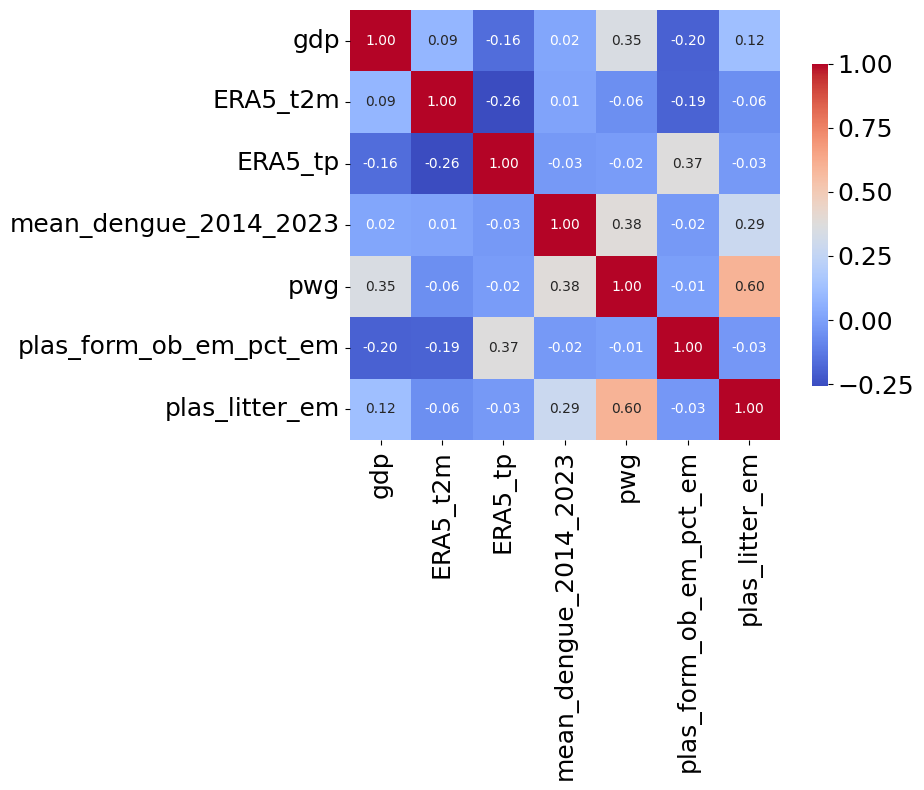

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix for numeric columns
corr = df.select_dtypes(include="number").corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .75})

plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"Correlation_Matrix_of_Selected_Feature.pdf"), format='pdf', dpi=3000)
plt.show()


 SHAP Summary with Random Forest

In [ ]:
from sklearn.metrics import mean_absolute_error


In [ ]:
# Step 1: Install XGBoost (if not already installed)
!pip install xgboost shap --quiet
!pip install tqdm --quiet
from tqdm.notebook import tqdm
from joblib import parallel_backend
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error



In [ ]:
# import shap
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.metrics import mean_absolute_error
# from lightgbm import LGBMRegressor

# # 1. Prepare data
# X = df.select_dtypes(include="number").drop(columns=["mean_dengue_2014_2023", "log_dengue"], errors="ignore").astype("float64")
# y = df["mean_dengue_2014_2023"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# weights = 1 + y_train / y_train.mean()

# # 2. Hyperparameter grid
# param_grid = {
#     "n_estimators": [100, 300, 500],
#     "max_depth": [5, 10, 15],
#     "learning_rate": [0.01, 0.1],
#     "subsample": [0.8, 1.0]
# }

# # 3. Model + search
# model = LGBMRegressor(random_state=42)
# search = RandomizedSearchCV(
#     model, param_grid, n_iter=10, cv=3,
#     scoring="neg_mean_absolute_error",
#     random_state=42, n_jobs=-1,
#     verbose=2    # 👈 this shows progress
# )
# with parallel_backend("loky", n_jobs=-1):
#     search.fit(X_train, y_train, sample_weight=weights)
# best_model = search.best_estimator_

# # 4. Evaluate
# y_pred = best_model.predict(X_test)
# mae = mean_absolute_error(y_test, y_pred)
# print(f"🌿 LGBM MAE: {mae:.2f}")

# # 5. SHAP
# explainer = shap.Explainer(best_model, X_train)
# shap_values = explainer(X_train)
# shap.summary_plot(shap_values, X_train)


# XGBOOST

 96%|=================== | 4996/5178 [00:26<00:00]       

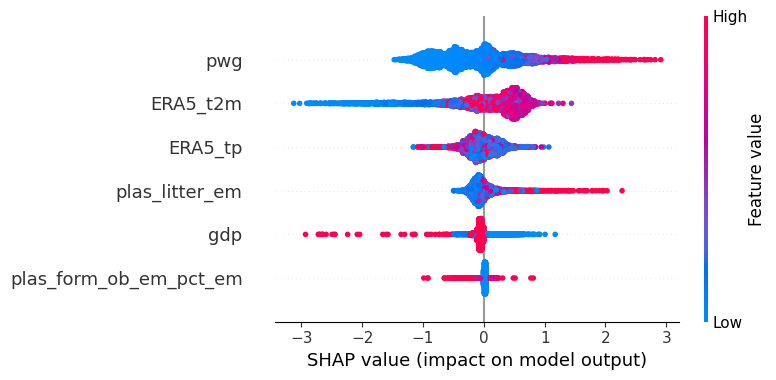

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor

# 1. Prepare data
X = df.select_dtypes(include="number").drop(columns=["mean_dengue_2014_2023", "log_dengue", "pwg_log"], errors="ignore").astype("float64")
y = np.log1p(df["mean_dengue_2014_2023"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Sample weights (optional)
weights = y_train.values ** 2
# weights = 1 + y_train / y_train.mean()

#from xgboost import XGBRegressor

modelSHAPXGB = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

modelSHAPXGB.fit(X_train, y_train, sample_weight=weights)

# 5. SHAP values
explainer = shap.Explainer(modelSHAPXGB, X_train)
shap_values = explainer(X_train)

# 6. Plot SHAP summary
plt.rcParams["figure.figsize"] = (10, 8)
plt.figure()
shap.summary_plot(shap_values, X_train, show=False)

# 7. Save figure
os.makedirs(image_folder, exist_ok=True)
plt.savefig(os.path.join(image_folder, "shap_summary_plot.pdf"), format='pdf', dpi=3000)
plt.show()

In [ ]:
shap_importance = shap_df.abs().mean().sort_values(ascending=False)
print(shap_importance)


pwg                       0.559421
ERA5_t2m                  0.518457
ERA5_tp                   0.188042
plas_litter_em            0.153653
gdp                       0.115739
plas_form_ob_em_pct_em    0.030349
dtype: float64


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict
y_pred = modelSHAP.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"R²:  {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")


R²:  0.523
RMSE: 1.164
MAE:  0.895


In [ ]:
# === 6. Optional: Evaluate on original dengue scale ===
actual_dengue = np.expm1(y_test)
predicted_dengue = np.expm1(y_pred)

print("\nPerformance on original scale:")
print(f"R²:  {r2_score(actual_dengue, predicted_dengue):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(actual_dengue, predicted_dengue)):.0f}")
print(f"MAE:  {mean_absolute_error(actual_dengue, predicted_dengue):.0f}")



Performance on original scale:
R²:  0.393
RMSE: 399
MAE:  93


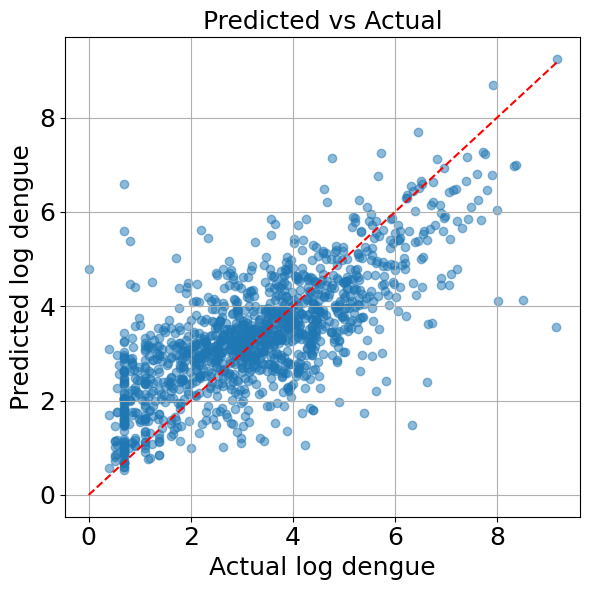

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual log dengue")
plt.ylabel("Predicted log dengue")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


# ✅ Updated Optuna Objective with Early Stopping + Silent Logs:

 Visualize Weight Distribution

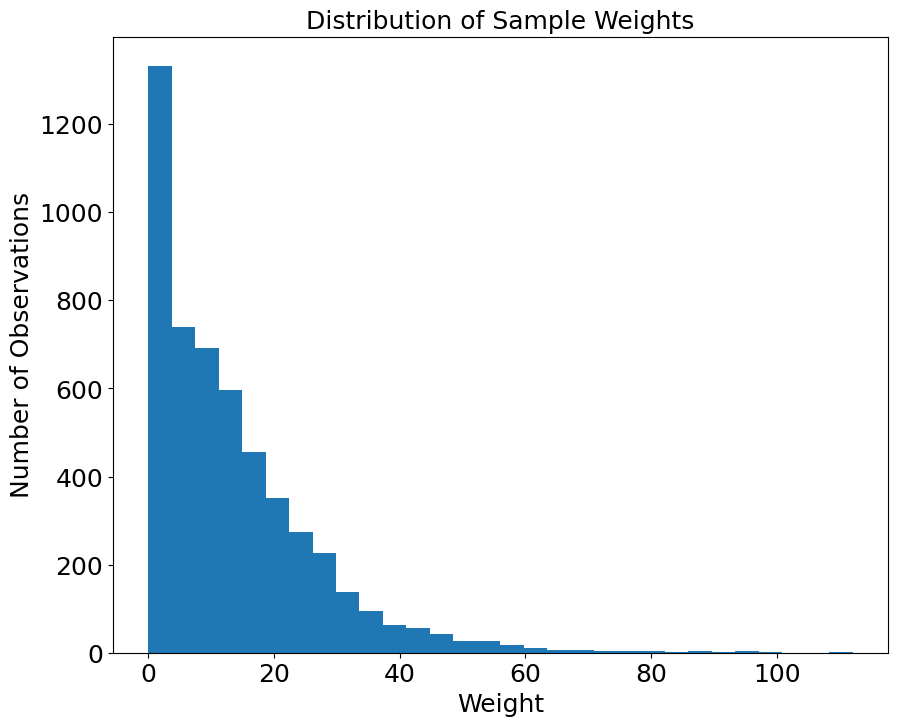

In [ ]:
import matplotlib.pyplot as plt
plt.hist(weights, bins=30)
plt.title("Distribution of Sample Weights")
plt.xlabel("Weight")
plt.ylabel("Number of Observations")
plt.show()


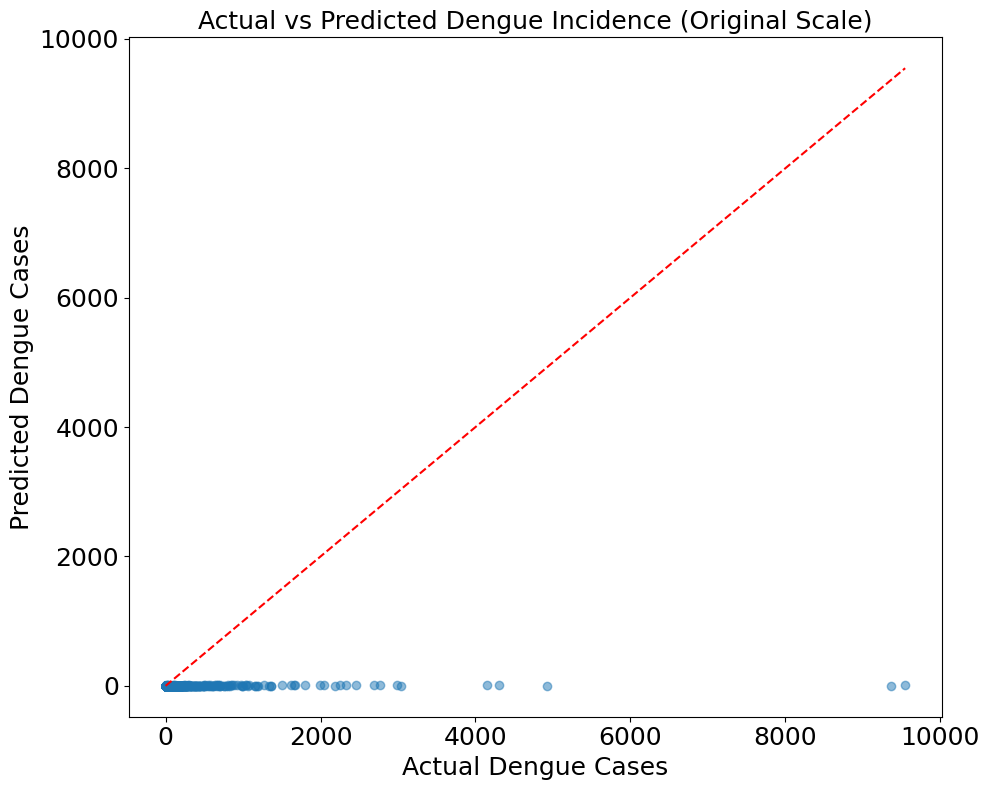

In [ ]:
plt.scatter(y_test_raw, y_pred, alpha=0.5)
plt.xlabel("Actual Dengue Cases")
plt.ylabel("Predicted Dengue Cases")
plt.title("Actual vs Predicted Dengue Incidence (Original Scale)")
plt.plot([y_test_raw.min(), y_test_raw.max()],
         [y_test_raw.min(), y_test_raw.max()], 'r--')
plt.tight_layout()
plt.show()


SKEWNESS

Skewness of Plastic Waste Generated (pwg): 23.719


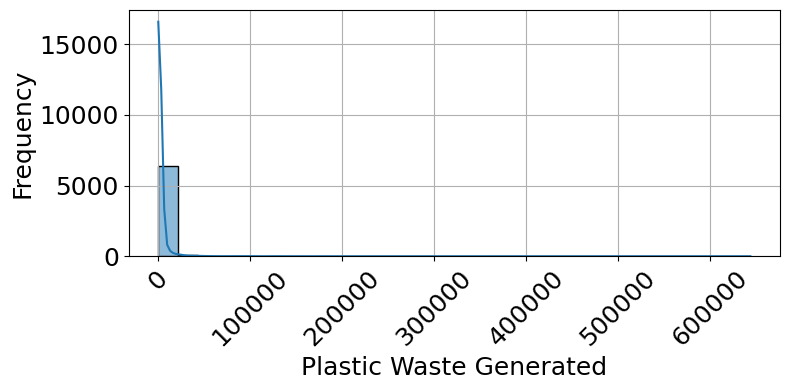

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import os

# 1. Calculate skewness
pwg_skewness = skew(df["pwg"].dropna())
print(f"Skewness of Plastic Waste Generated (pwg): {pwg_skewness:.3f}")

# 2. Plot distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["pwg"].dropna(), kde=True, bins=30)

# Update label and filename
plt.xlabel("Plastic Waste Generated")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, "pwg_skewness.pdf"), format='pdf', dpi=3000)
plt.show()


Skewness of Plastic Waste Generated (Std): 0.570


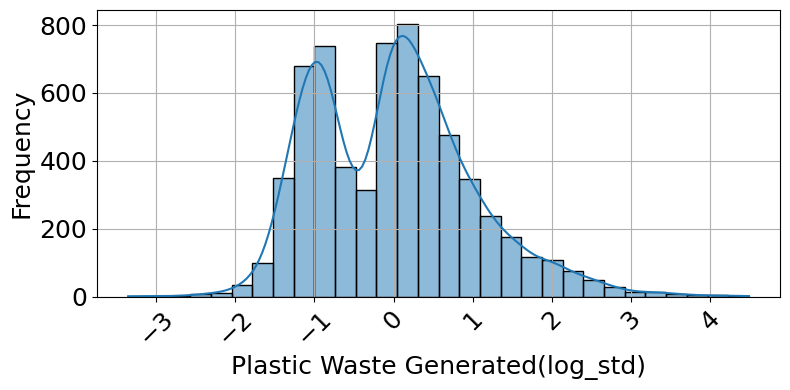

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import os

# 1. Calculate skewness
pwg_skewness = skew(df_scaled["pwg_log_std"].dropna())
print(f"Skewness of Plastic Waste Generated (Std): {pwg_skewness:.3f}")

# 2. Plot distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_scaled["pwg_log_std"].dropna(), kde=True, bins=30)

# Update label and filename
plt.xlabel("Plastic Waste Generated(log_std)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, "pwg_newskewness.pdf"), format='pdf', dpi=3000)
plt.show()


Skewness of Mean Annual Dengue Incidence (2014–2023): 24.139


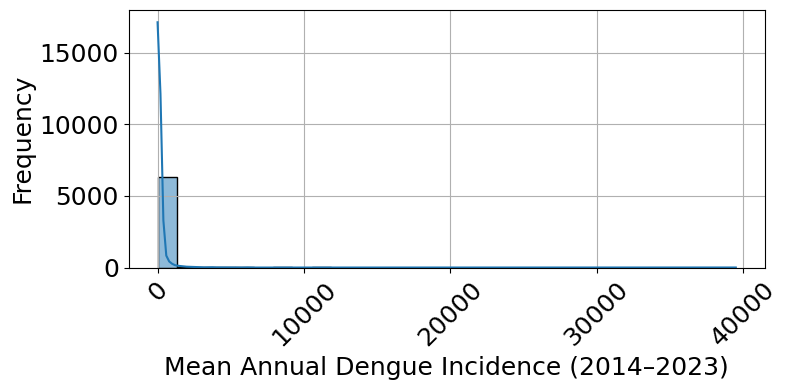

In [ ]:
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Calculate skewness
skewness = skew(df["mean_dengue_2014_2023"].dropna())
print(f"Skewness of Mean Annual Dengue Incidence (2014–2023): {skewness:.3f}")

# 2. Plot distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["mean_dengue_2014_2023"].dropna(), kde=True, bins=30)

# Label axes clearly
plt.xlabel("Mean Annual Dengue Incidence (2014–2023)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save plot
plt.savefig(os.path.join(image_folder, "mean_dengue_skewness.pdf"), format='pdf', dpi=3000)
plt.show()


Skewness of Mean Annual Dengue Incidence (2014–2023): 0.428


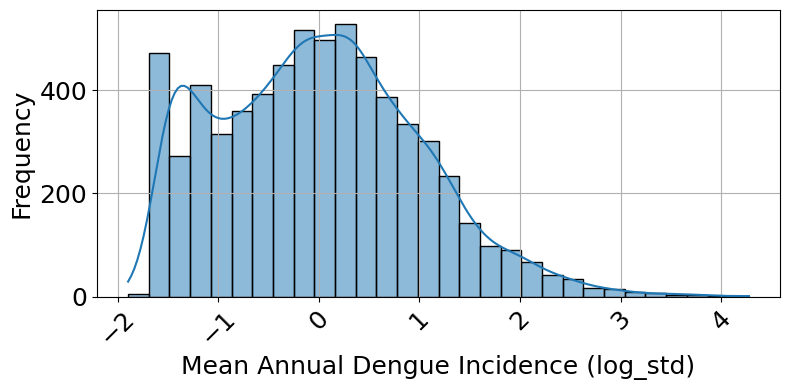

In [ ]:
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Calculate skewness
skewness = skew(df_scaled["log_dengue_std"].dropna())
print(f"Skewness of Mean Annual Dengue Incidence (2014–2023): {skewness:.3f}")

# 2. Plot distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_scaled["log_dengue_std"].dropna(), kde=True, bins=30)

# Label axes clearly
plt.xlabel("Mean Annual Dengue Incidence (log_std)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save plot
plt.savefig(os.path.join(image_folder, "mean_dengue_newskewness.pdf"), format='pdf', dpi=3000)
plt.show()


Skewness of Plastic Litter Emitted into the Environment: 20.007


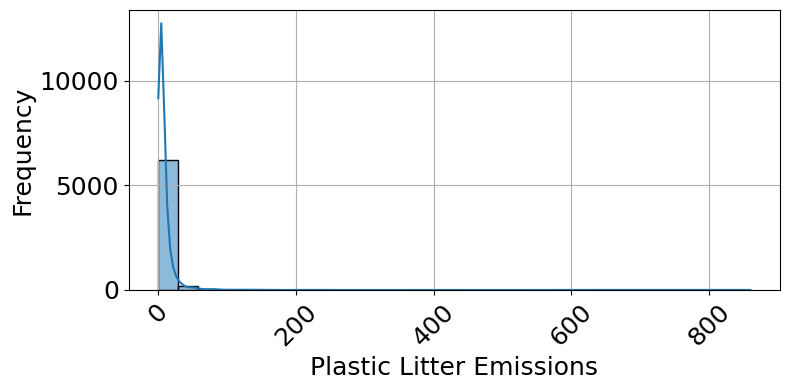

In [ ]:
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Calculate skewness
skewness = skew(df["plas_litter_em"].dropna())
print(f"Skewness of Plastic Litter Emitted into the Environment: {skewness:.3f}")

# 2. Plot distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["plas_litter_em"].dropna(), kde=True, bins=30)

# Label axes clearly
plt.xlabel("Plastic Litter Emissions")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save plot
plt.savefig(os.path.join(image_folder, "plas_litter_skewness.pdf"), format='pdf', dpi=3000)
plt.show()


Skewness of Plastic Litter Emitted into the Environment: 0.966


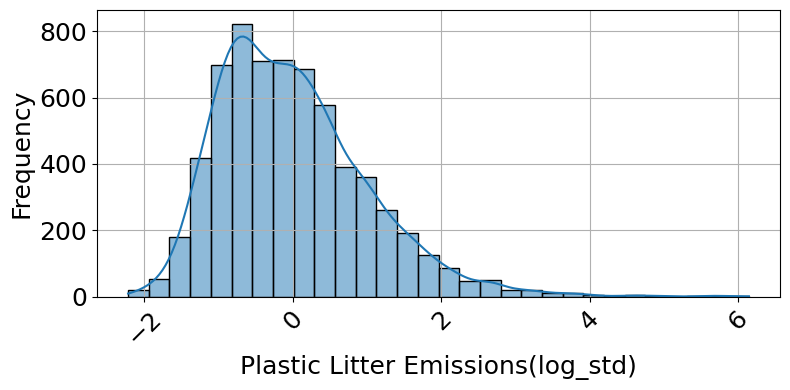

In [ ]:
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Calculate skewness
skewness = skew(df_scaled["log_plas_litter_std"].dropna())
print(f"Skewness of Plastic Litter Emitted into the Environment: {skewness:.3f}")

# 2. Plot distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_scaled["log_plas_litter_std"].dropna(), kde=True, bins=30)

# Label axes clearly
plt.xlabel("Plastic Litter Emissions(log_std)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save plot
plt.savefig(os.path.join(image_folder, "plas_litter_newskewness.pdf"), format='pdf', dpi=3000)
plt.show()


#### Log transform Dengue and plastic data

In [ ]:
df['log_dengue'] = np.log1p(df['mean_dengue_2014_2023'])
df['log_plas_litter'] = np.log1p(df['plas_litter_em'])
df["pwg_log"] = np.log1p(df["pwg"])
df.columns

<ipython-input-360-c44da0d0e6c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_dengue'] = np.log1p(df['mean_dengue_2014_2023'])
<ipython-input-360-c44da0d0e6c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_plas_litter'] = np.log1p(df['plas_litter_em'])
<ipython-input-360-c44da0d0e6c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Index(['adm_0_name', 'adm_1_name', 'adm_2_name', 'gdp', 'ERA5_t2m', 'ERA5_tp',
       'mean_dengue_2014_2023', 'pwg', 'plas_form_ob_em_pct_em',
       'plas_litter_em', 'log_dengue', 'log_plas_litter', 'pwg_log'],
      dtype='object')

#### Standardize predictors

---



In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Copy your original DataFrame
df_scaled = df.copy()

# List of columns to exclude from scaling
exclude_cols = [
    'adm_0_name', 'ISO3', 'Income_cat', 'adm_1_name', 'adm_2_name',
    'Unique_ID', 'geometry', 'centroid', 'mean_dengue_2014_2023'
      # already standardized
]

# Select numeric columns
numeric_cols = df_scaled.select_dtypes(include=['int64', 'float64']).columns

# Identify columns to scale
cols_to_scale = [col for col in numeric_cols if col not in exclude_cols]

# Fit scaler
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_scaled[cols_to_scale])

# Create a new DataFrame with standardized columns and `_std` suffix
scaled_df = pd.DataFrame(scaled_array, columns=[col + '_std' for col in cols_to_scale], index=df_scaled.index)

# Concatenate the standardized columns back to the original DataFrame
df_scaled = pd.concat([df_scaled, scaled_df], axis=1)

# (Optional) Save mean and std for inverse transform
scaler_means = pd.Series(scaler.mean_, index=cols_to_scale)
scaler_stds = pd.Series(scaler.scale_, index=cols_to_scale)

# Done
print(f"{len(scaled_df.columns)} variables were standardized and added with '_std' suffix.")


9 variables were standardized and added with '_std' suffix.


In [ ]:
# Step 1: Get all columns ending with '_std'
std_cols = [col for col in df_scaled.columns if col.endswith('_std')]

# Step 2: Compute mean and standard deviation for each standardized column
check_stats = df_scaled[std_cols].agg(['mean', 'std']).T

# Step 3: Rename columns for clarity
check_stats.columns = ['Mean', 'StdDev']

# Step 4: Display the result
print(check_stats.sort_index())


                                    Mean    StdDev
ERA5_t2m_std               -1.405059e-16  1.000077
ERA5_tp_std                -1.053794e-16  1.000077
gdp_std                     3.073567e-17  1.000077
log_dengue_std              2.458853e-16  1.000077
log_plas_litter_std        -9.659781e-17  1.000077
plas_form_ob_em_pct_em_std  1.756324e-17  1.000077
plas_litter_em_std          4.829890e-17  1.000077
pwg_log_std                -3.337015e-16  1.000077
pwg_std                     8.781619e-18  1.000077


Checking if the standardization worked

In [ ]:
df_scaled.columns

Index(['adm_0_name', 'adm_1_name', 'adm_2_name', 'gdp', 'ERA5_t2m', 'ERA5_tp',
       'mean_dengue_2014_2023', 'pwg', 'plas_form_ob_em_pct_em',
       'plas_litter_em', 'log_dengue', 'log_plas_litter', 'pwg_log', 'gdp_std',
       'ERA5_t2m_std', 'ERA5_tp_std', 'pwg_std', 'plas_form_ob_em_pct_em_std',
       'plas_litter_em_std', 'log_dengue_std', 'log_plas_litter_std',
       'pwg_log_std'],
      dtype='object')

In [ ]:
df_scaled.shape

(6473, 22)

## Basic Model

In [ ]:
# df = plastic_dengue_atmosphere.copy()
# # Remove inf/nan
# df = df.replace([np.inf, -np.inf], np.nan).dropna()
# df = df[(df["mean_dengue_2014_2023"] > 0) & (df["Population_2020"] > 0) & (df["plas_collection_em"] > 0) ]

# df["plastic_gap"] = df["plas_em"] - df["plas_collection_em"]

# df["plastic_ratio"] = df["plas_em"] / df["plas_collection_em"]

# df['log_population'] = np.log(df['Population_2020'])

In [ ]:
# df["plastic_gap_unmanaged"] = (
#       df["plas_litter_em"]      # litter left in the open
#     + df["plas_uncol_em"]       # uncollected household waste
#     + df["plas_burn_em"]        # open‑burned
# )

# df = df.merge(gdp, on="adm_0_name", how="left")

Rescale it if negative

In [ ]:
# min_gap = df["plastic_gap"].min()         # could be negative
# df["plastic_gap_pos"] = df["plastic_gap"] - min_gap

# df['plastic_gap_pos'] = df['plastic_gap_pos'] / 100
# df["plastic_ratio_std"] = (df["plastic_ratio"] - df["plastic_ratio"].mean()) / df["plastic_ratio"].std()

# df["gdp_scaled"] = (df["gdp"] - df["gdp"].mean()) / df["gdp"].std()

# df["ERA5_t2m_std"] = (df["ERA5_t2m"] - df["ERA5_t2m"].mean()) / df["ERA5_t2m"].std()
# df["ERA5_tp_std"] = (df["ERA5_tp"] - df["ERA5_tp"].mean()) / df["ERA5_tp"].std()
# df["plas_recy_em_std"] = (df["plas_recy_em"] - df["plas_recy_em"].mean()) / df["plas_recy_em"].std()

# df["plas_litter_em_std"] = (df["plas_litter_em"] - df["plas_litter_em"].mean()) / df["plas_litter_em"].std()



plastic handling

plastic_ratio:

How much plastic pollution (plas_em)
is there compared to what the collection system handles (plas_collection_em)

🧠 Why is it useful?

If the number is big → Most pollution is from outside the waste system (like litter, burning).

If the number is small → Most pollution is from inside the collection system.

In short, it helps you see if dengue is worse when collection is bad

In [ ]:
# df_scaled["mean_dengue_2014_2023"].min() >= 0
# df_scaled["log_dengue_std"].isna().sum() == 0


## **1A model_pwg_std**

In [ ]:
model_pwg_std = bmb.Model(
    "log_dengue_std  ~ pwg_log_std + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_pwg_std = model_pwg_std.fit(
    draws=2000,
    tune=1000,
    idata_kwargs={"log_likelihood": True},
    chains = 4,
    target_accept=0.98,
    cores = 2)

Output()

In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata1A = results_pwg_std
"log_likelihood" in idata1A.groups()

True

In [ ]:

az.summary(results_pwg_std, round_to = 4)

mean      sd  hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.3670  0.3849 -1.0759   0.3825   
1|adm_0_name[brazil]                    0.7147  0.3830  0.0048   1.4523   
1|adm_0_name[china]                     0.5410  0.4175 -0.2515   1.3202   
1|adm_0_name[colombia]                  0.4812  0.3838 -0.2562   1.1963   
1|adm_0_name[costa rica]                0.7266  0.3921 -0.0462   1.4410   
1|adm_0_name[pakistan]                 -1.2806  0.4556 -2.1509  -0.4289   
1|adm_0_name[peru]                      0.4409  0.3872 -0.2971   1.1713   
1|adm_0_name[united states of america] -1.3688  0.4050 -2.1447  -0.6090   
1|adm_0_name_sigma                      1.0683  0.3488  0.5361   1.7072   
Intercept                              -0.6190  0.3827 -1.3333   0.1131   
pwg_log_std                             0.5328  0.0111  0.5124   0.5534   
sigma                                   0.8510  0.0075  0.8366   0.8648   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0086   0.0061  1965.1366   
1|adm_0_name[brazil]                       0.0087   0.0062  1933.8256   
1|adm_0_name[china]                        0.0088   0.0063  2247.4059   
1|adm_0_name[colombia]                     0.0086   0.0062  1960.8712   
1|adm_0_name[costa rica]                   0.0086   0.0062  2047.2892   
1|adm_0_name[pakistan]                     0.0090   0.0064  2552.8453   
1|adm_0_name[peru]                         0.0086   0.0062  1984.3413   
1|adm_0_name[united states of america]     0.0088   0.0062  2121.6719   
1|adm_0_name_sigma                         0.0083   0.0059  1670.4942   
Intercept                                  0.0086   0.0062  1939.1880   
pwg_log_std                                0.0002   0.0001  5363.7142   
sigma                                      0.0001   0.0001  4862.5743   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 2596.0958  1.0012  
1|adm_0_name[brazil]                    2713.8804  1.0013  
1|adm_0_name[china]                     3230.8622  1.0009  
1|adm_0_name[colombia]                  2848.1728  1.0014  
1|adm_0_name[costa rica]                2670.4467  1.0011  
1|adm_0_name[pakistan]                  3931.8439  1.0010  
1|adm_0_name[peru]                      2831.1537  1.0012  
1|adm_0_name[united states of america]  2892.0641  1.0008  
1|adm_0_name_sigma                      2968.9265  1.0021  
Intercept                               2805.8245  1.0013  
pwg_log_std                             4992.5810  1.0005  
sigma                                   4728.1487  1.0006

 Posterior Plot

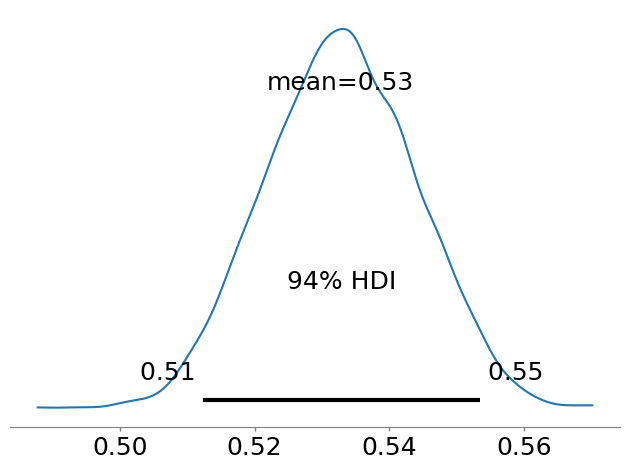

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import os

# Posterior plot without title
az.plot_posterior(
    results_pwg_std,
    var_names=["pwg_log_std"],
    hdi_prob=0.94
)

# Remove the automatic title added by ArviZ
plt.gca().set_title("")  # clears title for current axis

plt.tight_layout()
plt.savefig(os.path.join(image_folder, "1A_pwg_std_plot_posterior.pdf"), format='pdf', dpi=300)
plt.show()


The posterior analysis indicates a strong positive association between standardized log plastic waste generation (pwg_log_std) and standardized log dengue incidence (log_dengue_std). The estimated mean effect is 0.53, with a 95% Highest Density Interval (HDI) ranging from 0.51 to 0.56, clearly excluding zero. This suggests that increases in plastic waste are credibly linked to higher dengue incidence.

Interpreted marginally, a 1 standard deviation increase in log-transformed plastic waste corresponds to an average 0.53 standard deviation increase in log dengue incidence. In real terms, this implies that regions with unusually high plastic waste emissions (e.g., one standard deviation above the mean) are expected to experience substantially elevated dengue incidence. Since the outcome is log-transformed, this also means dengue cases increase multiplicatively, not linearly—small increases in plastic waste can lead to proportionally large increases in disease burden when plastic pollution is already high.

<ipython-input-179-02f589054a4c>:22: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi = az.hdi(predictions.T, hdi_prob=0.94)  # shape: (100, 2)


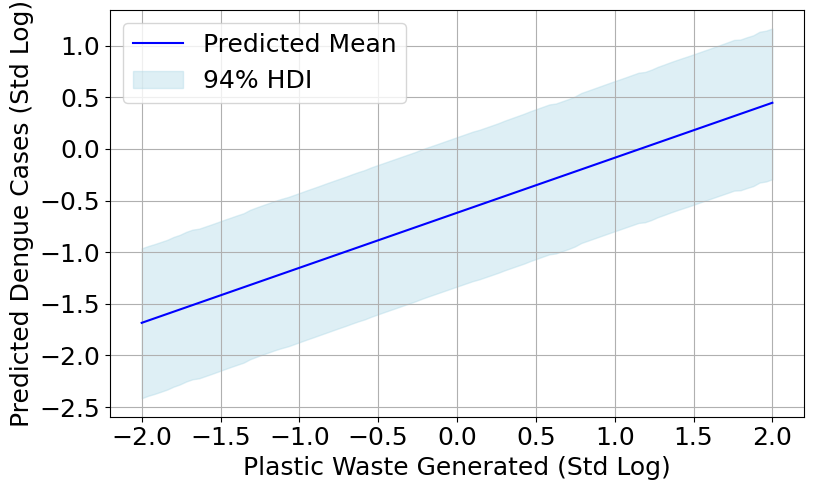

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np


# Step 1: Extract posterior samples from results_pwg_std
idata1A = results_pwg_std  # just to align with your original code

intercept_samples = idata1A.posterior["Intercept"].values.flatten()
beta_samples = idata1A.posterior["pwg_log_std"].values.flatten()

# Step 2: Create predictor values (X-axis) for pwg_log_std
x_vals = np.linspace(-2, 2, 100)  # standardized PWG range

# Step 3: Compute predicted log_dengue for each x across all posterior samples
predictions = np.array([
    intercept_samples + beta_samples * x for x in x_vals
])  # shape: (100, num_samples)

# Step 4: Compute mean and 94% HDI
pred_mean = predictions.mean(axis=1)
pred_hdi = az.hdi(predictions.T, hdi_prob=0.94)  # shape: (100, 2)

# Step 5: Plot
plt.figure(figsize=(8, 5))
plt.plot(x_vals, pred_mean, color="blue", label="Predicted Mean")
plt.fill_between(x_vals, pred_hdi[:, 0], pred_hdi[:, 1], color="lightblue", alpha=0.4, label="94% HDI")

# plt.title("Marginal Effect of Standardized Log Plastic Waste (pwg_log_std)")
plt.xlabel("Plastic Waste Generated (Std Log)")
plt.ylabel("Predicted Dengue Cases (Std Log)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"1A_marginal_effect_pwg_log_std.pdf"), format='pdf', dpi=3000)
plt.show()


The plot shows a clear positive relationship between plastic waste and dengue incidence. As standardized log plastic waste increases, the predicted log dengue cases also increase. The 94% credible interval (shaded region) stays well above zero across most of the range, indicating strong statistical support for this effect. In short, areas with higher plastic waste tend to have more dengue cases, and this result is robust and credible based on the model.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


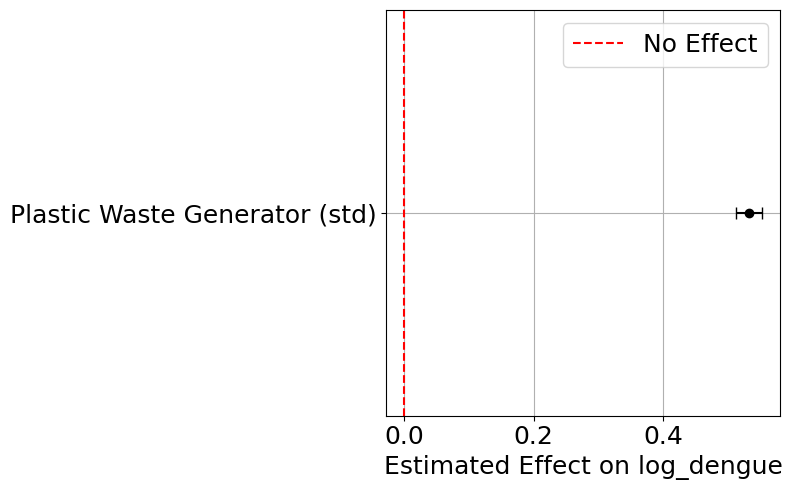

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

summary = az.summary(
    idata1A,
    var_names=["pwg_log_std"]
)
summary.index = ["Plastic Waste Generator (std)"]
means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index


plt.figure(figsize=(8, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
# Rotate the y-axis labels
plt.yticks(rotation=0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"A1_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()


## **1B model_pwg_std**

In [ ]:
model_pwg_std_spline = bmb.Model(
    "log_dengue_std  ~  bs(pwg_log_std, df = 3) + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_pwg_std_spline = model_pwg_std_spline.fit(
    draws=2000,
    tune=1000,
    idata_kwargs={"log_likelihood": True},
    chains = 4,
    target_accept=0.98,
    cores = 2)

Output()

In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata1B = results_pwg_std_spline
"log_likelihood" in idata1B.groups()

True

In [ ]:
import numpy as np

# Step 1: True values
y_true = df_scaled["log_dengue_std"].values

# Step 2: Posterior mean predictions
ppc = model_pwg_std_spline.predict(idata=results_pwg_std_spline, kind="pps", inplace=False)
y_pred = ppc.posterior_predictive["log_dengue_std"].mean(dim=("chain", "draw")).values

# Step 3: Calculate residuals
residuals = y_true - y_pred

# Step 4: Variances
var_fit = np.var(y_pred)
var_resid = np.var(residuals)

# Step 5: F* statistic (Bayesian analogue)
f_star = var_fit / var_resid
print(f"Bayesian analogue of F-statistic: {f_star:.2f}")


/usr/local/lib/python3.10/dist-packages/bambi/models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


Bayesian analogue of F-statistic: 0.40


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Extract observed values
y_true = df_scaled["log_dengue_std"].values

# 2. Generate posterior predictive samples (if not already available)
ppc = model_pwg_std_spline.predict(idata=results_pwg_std_spline, kind="pps", inplace=False)

# 3. Take the mean prediction across all draws and chains
y_pred = ppc.posterior_predictive["log_dengue_std"].mean(dim=("chain", "draw")).values

# 4. Compute metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

# 5. Print results
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}%")


/usr/local/lib/python3.10/dist-packages/bambi/models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


MAE:  0.687
RMSE: 0.845
MAPE: 3504781735.032%


In [ ]:

idata1B = results_pwg_std_spline
az.summary(results_pwg_std_spline, round_to = 3)


mean     sd  hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.290  0.458  -1.157    0.579   
1|adm_0_name[brazil]                    0.848  0.456  -0.038    1.689   
1|adm_0_name[china]                     0.388  0.484  -0.486    1.351   
1|adm_0_name[colombia]                  0.586  0.456  -0.292    1.448   
1|adm_0_name[costa rica]                0.851  0.464  -0.019    1.740   
1|adm_0_name[pakistan]                 -1.450  0.511  -2.402   -0.481   
1|adm_0_name[peru]                      0.534  0.460  -0.340    1.421   
1|adm_0_name[united states of america] -1.513  0.477  -2.428   -0.613   
1|adm_0_name_sigma                      1.222  0.432   0.592    2.002   
Intercept                              -1.121  0.512  -2.128   -0.189   
bs(pwg_log_std, df=3)[0]               -1.325  0.511  -2.285   -0.401   
bs(pwg_log_std, df=3)[1]                1.891  0.163   1.594    2.201   
bs(pwg_log_std, df=3)[2]                3.318  0.430   2.472    4.053   
sigma                                   0.846  0.007   0.832    0.860   

                                        mcse_mean  mcse_sd  ess_bulk  \
1|adm_0_name[argentina]                     0.011    0.007  1896.396   
1|adm_0_name[brazil]                        0.010    0.007  1899.230   
1|adm_0_name[china]                         0.010    0.007  2169.306   
1|adm_0_name[colombia]                      0.010    0.007  1930.404   
1|adm_0_name[costa rica]                    0.010    0.007  1945.443   
1|adm_0_name[pakistan]                      0.011    0.008  2324.777   
1|adm_0_name[peru]                          0.011    0.007  1935.862   
1|adm_0_name[united states of america]      0.010    0.008  2079.078   
1|adm_0_name_sigma                          0.009    0.007  1957.698   
Intercept                                   0.011    0.008  2200.185   
bs(pwg_log_std, df=3)[0]                    0.008    0.005  4570.855   
bs(pwg_log_std, df=3)[1]                    0.002    0.001  6410.041   
bs(pwg_log_std, df=3)[2]                    0.007    0.005  4323.084   
sigma                                       0.000    0.000  6485.244   

                                        ess_tail  r_hat  
1|adm_0_name[argentina]                 2875.696  1.001  
1|adm_0_name[brazil]                    2795.191  1.001  
1|adm_0_name[china]                     3034.114  1.001  
1|adm_0_name[colombia]                  2761.417  1.001  
1|adm_0_name[costa rica]                2972.789  1.001  
1|adm_0_name[pakistan]                  3755.388  1.000  
1|adm_0_name[peru]                      2830.862  1.001  
1|adm_0_name[united states of america]  3058.644  1.001  
1|adm_0_name_sigma                      2881.050  1.001  
Intercept                               3022.987  1.001  
bs(pwg_log_std, df=3)[0]                4623.406  1.000  
bs(pwg_log_std, df=3)[1]                5484.080  1.000  
bs(pwg_log_std, df=3)[2]                4671.410  1.000  
sigma                                   5013.906  1.000

In [ ]:
results_pwg_std_spline.posterior.keys()


KeysView(<xarray.Dataset> Size: 913kB
Dimensions:                    (chain: 4, draw: 2000,
                                adm_0_name__factor_dim: 8,
                                bs(pwg_log_std, df=3)_dim: 3)
Coordinates:
  * chain                      (chain) int64 32B 0 1 2 3
  * draw                       (draw) int64 16kB 0 1 2 3 ... 1996 1997 1998 1999
  * adm_0_name__factor_dim     (adm_0_name__factor_dim) <U24 768B 'argentina'...
  * bs(pwg_log_std, df=3)_dim  (bs(pwg_log_std, df=3)_dim) int64 24B 0 1 2
Data variables:
    1|adm_0_name               (chain, draw, adm_0_name__factor_dim) float64 512kB ...
    1|adm_0_name_sigma         (chain, draw) float64 64kB 0.9432 ... 0.7592
    Intercept                  (chain, draw) float64 64kB -1.846 ... -1.276
    bs(pwg_log_std, df=3)      (chain, draw, bs(pwg_log_std, df=3)_dim) float64 192kB ...
    sigma                      (chain, draw) float64 64kB 0.8447 ... 0.8417
Attributes:
    created_at:                  2025-06-02T13:

1B Posterior plot

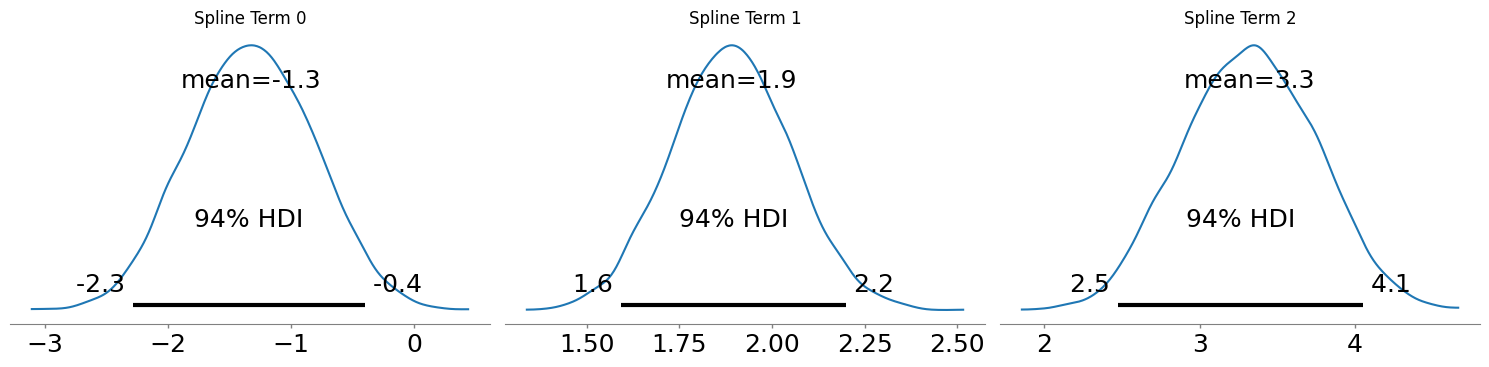

In [ ]:

import matplotlib.pyplot as plt
import arviz as az
import os

# Prepare figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot each spline coefficient in its subplot
for i in range(3):
    az.plot_posterior(
        results_pwg_std_spline,
        var_names=["bs(pwg_log_std, df=3)"],
        coords={"bs(pwg_log_std, df=3)_dim": [i]},
        hdi_prob=0.94,
        ax=axes[i]
    )
    axes[i].set_title(f"Spline Term {i}", fontsize=12)

# Final layout and export
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig(os.path.join(image_folder, "1B_spline_posterior_subplot.pdf"), format="pdf", dpi=300)
plt.show()


/usr/local/lib/python3.10/dist-packages/bambi/models.py:851: FutureWarning: 'mean' has been replaced by 'response_params' and is not going to work in the future
  warnings.warn(


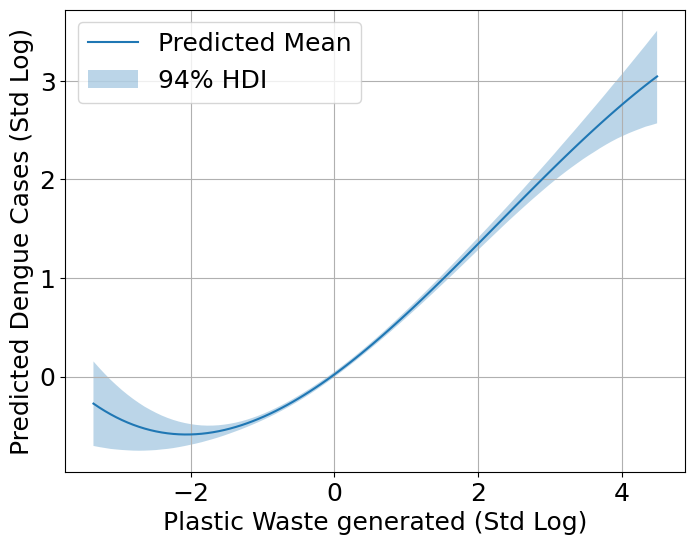

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["bs(pwg_log_std, df=3)"]
idata1B = results_pwg_std_spline  # just to align with your original code


var = "pwg_log_std"
x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

# Fix others at mean, and add placeholder country
df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in ["pwg_log_std"]}, index=range(100))
df_pred[var] = x_vals
df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # Add known group
# Predict
pred = model_pwg_std_spline.predict(idata=idata1B, data=df_pred, kind="mean", inplace=False)
mu = pred.posterior["mu"]
pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
pred_hdi = xr.concat([
    mu.quantile(0.03, dim=["chain", "draw"]),
    mu.quantile(0.97, dim=["chain", "draw"])
], dim="quantile").values

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_vals, pred_mean, label="Predicted Mean")
plt.fill_between(x_vals, pred_hdi[0], pred_hdi[1], alpha=0.3, label="94% HDI")
plt.xlabel("Plastic Waste generated (Std Log)")
plt.ylabel("Predicted Dengue Cases (Std Log)")

plt.legend()
plt.grid(True)
plt.savefig(os.path.join(image_folder, "1B_marginal_effect_pwg_log_std_spline.pdf"), format='pdf', dpi=300)
plt.show()

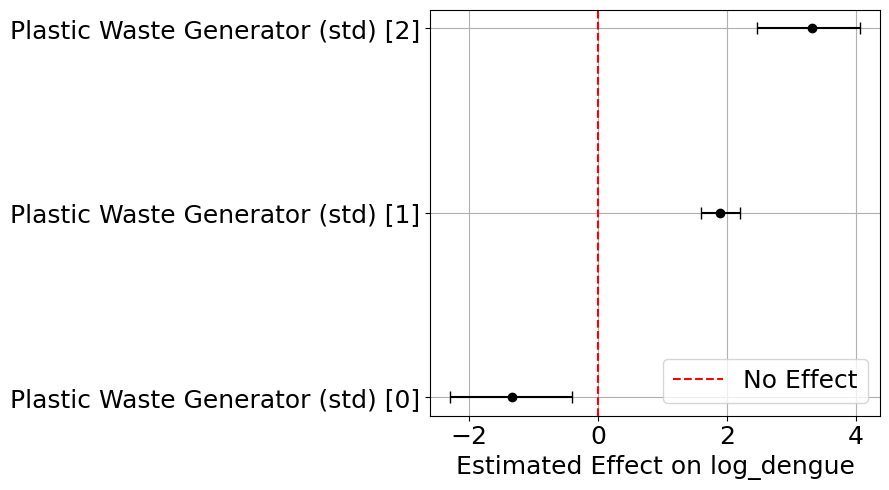

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

summary = az.summary(
    idata1B,
    var_names=["bs(pwg_log_std, df=3)"]
)
summary.index = [f"Plastic Waste Generator (std) [{i}]" for i in range(len(summary))]

means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

plt.figure(figsize=(9, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"1B_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()


## 2A **plas_litter_std**

In [ ]:
model_plas_litter_std = bmb.Model(
    "log_dengue_std  ~ log_plas_litter_std + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_plas_litter_std = model_plas_litter_std.fit(
    draws=2000,
    tune=1000,
    idata_kwargs={"log_likelihood": True},
    chains = 4,
    target_accept=0.98,
    cores = 2)

idata2A = results_plas_litter_std

Output()

In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata2A = results_plas_litter_std
"log_likelihood" in idata2A.groups()

True

In [ ]:
az.summary(idata2A, round_to = 4)

mean      sd  hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.3169  0.4432 -1.1608   0.5262   
1|adm_0_name[brazil]                    0.7799  0.4417 -0.0112   1.6714   
1|adm_0_name[china]                     0.6395  0.4725 -0.2472   1.5502   
1|adm_0_name[colombia]                  0.5670  0.4422 -0.2669   1.4157   
1|adm_0_name[costa rica]                0.9307  0.4486  0.0872   1.7996   
1|adm_0_name[pakistan]                 -2.1101  0.5186 -3.1101  -1.1632   
1|adm_0_name[peru]                      0.1880  0.4458 -0.6851   1.0194   
1|adm_0_name[united states of america] -0.7830  0.4624 -1.6539   0.0926   
1|adm_0_name_sigma                      1.2271  0.4074  0.6201   1.9842   
Intercept                              -0.6837  0.4414 -1.5582   0.1223   
log_plas_litter_std                     0.4750  0.0124  0.4517   0.4983   
sigma                                   0.8888  0.0079  0.8737   0.9036   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0120   0.0085  1363.3342   
1|adm_0_name[brazil]                       0.0120   0.0086  1360.2427   
1|adm_0_name[china]                        0.0121   0.0086  1547.2200   
1|adm_0_name[colombia]                     0.0120   0.0085  1352.3278   
1|adm_0_name[costa rica]                   0.0119   0.0085  1421.4795   
1|adm_0_name[pakistan]                     0.0123   0.0087  1778.1081   
1|adm_0_name[peru]                         0.0119   0.0084  1403.4904   
1|adm_0_name[united states of america]     0.0119   0.0084  1506.0128   
1|adm_0_name_sigma                         0.0100   0.0070  1647.1761   
Intercept                                  0.0120   0.0086  1356.1707   
log_plas_litter_std                        0.0002   0.0001  4816.7645   
sigma                                      0.0001   0.0001  5316.2126   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 1958.4309  1.0032  
1|adm_0_name[brazil]                    1811.9373  1.0034  
1|adm_0_name[china]                     2105.0092  1.0029  
1|adm_0_name[colombia]                  1815.2027  1.0033  
1|adm_0_name[costa rica]                1911.1671  1.0025  
1|adm_0_name[pakistan]                  2485.3039  1.0019  
1|adm_0_name[peru]                      1906.3969  1.0026  
1|adm_0_name[united states of america]  1988.4927  1.0014  
1|adm_0_name_sigma                      2420.7523  1.0014  
Intercept                               1829.3330  1.0035  
log_plas_litter_std                     4766.2974  1.0024  
sigma                                   4504.3544  1.0008

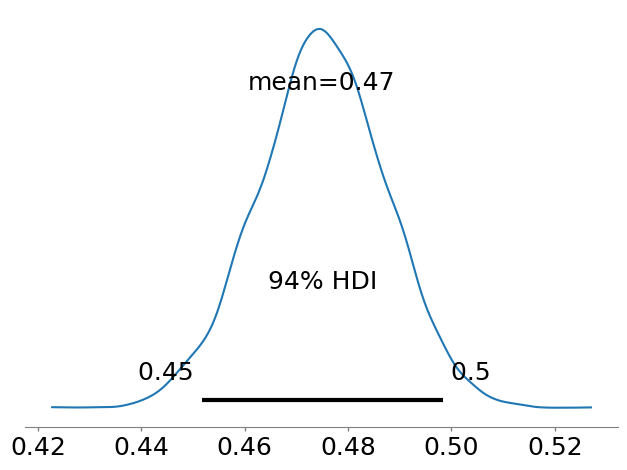

In [ ]:
# Posterior plot without title
az.plot_posterior(
    idata2A,
    var_names=["log_plas_litter_std"],
    hdi_prob=0.94
)

# Remove the automatic title added by ArviZ
plt.gca().set_title("")  # clears title for current axis

plt.tight_layout()
plt.savefig(os.path.join(image_folder, "2A_pwg_std_plot_posterior.pdf"), format='pdf', dpi=3000)
plt.show()



<ipython-input-183-4e6d4d6bcb5d>:17: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi = az.hdi(predictions.T, hdi_prob=0.94)  # shape: (100, 2)


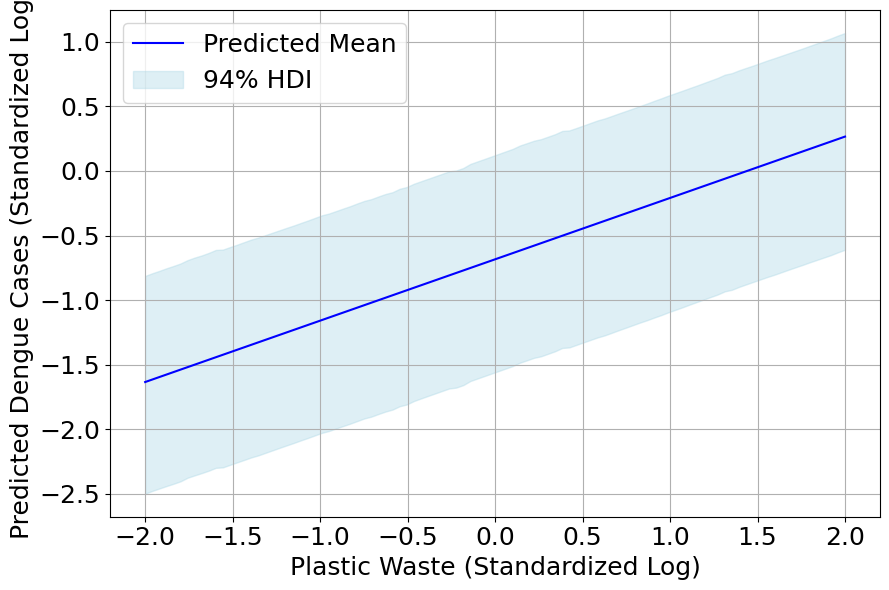

In [ ]:

# Step 1: Extract posterior samples from results_pwg_std
idata2A = results_plas_litter_std  # just to align with your original code

intercept_samples = idata2A.posterior["Intercept"].values.flatten()
beta_samples = idata2A.posterior["log_plas_litter_std"].values.flatten()

# Step 2: Create predictor values (X-axis) for pwg_log_std
x_vals = np.linspace(-2, 2, 100)  # standardized PWG range

# Step 3: Compute predicted log_dengue for each x across all posterior samples
predictions = np.array([
    intercept_samples + beta_samples * x for x in x_vals
])  # shape: (100, num_samples)

# Step 4: Compute mean and 94% HDI
pred_mean = predictions.mean(axis=1)
pred_hdi = az.hdi(predictions.T, hdi_prob=0.94)  # shape: (100, 2)

# Step 5: Plot
plt.figure(figsize=(9, 6))
plt.plot(x_vals, pred_mean, color="blue", label="Predicted Mean")
plt.fill_between(x_vals, pred_hdi[:, 0], pred_hdi[:, 1], color="lightblue", alpha=0.4, label="94% HDI")

# plt.title("Marginal Effect of Standardized Log Plastic Waste (pwg_log_std)")
plt.xlabel("Plastic Waste (Standardized Log)")
plt.ylabel("Predicted Dengue Cases (Standardized Log)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"2A_marginal_effect_plas_litter_std.pdf"), format='pdf', dpi=3000)
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


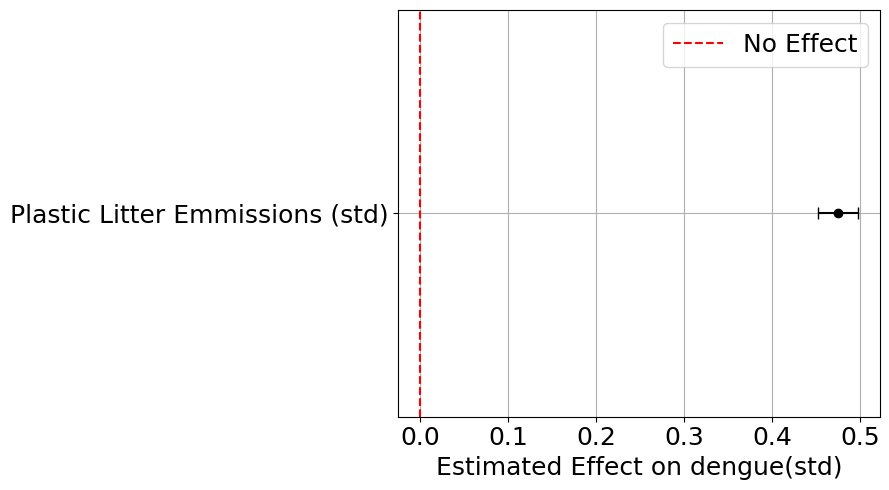

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

summary = az.summary(
    idata2A,
    var_names=["log_plas_litter_std"]
)
summary.index = [f"Plastic Litter Emmissions (std)" for i in range(len(summary))]

means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

plt.figure(figsize=(9, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on dengue(std)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"2A_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()


## **2B** **plas_litter_splines**

In [ ]:
model_plas_litter_std_spline = bmb.Model(
    "log_dengue_std  ~  bs(log_plas_litter_std, df = 3) + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_plas_litter_std_spline = model_plas_litter_std_spline.fit(
    draws=2000,
    tune=1000,
    idata_kwargs={"log_likelihood": True},
    chains = 4,
    target_accept=0.98,
    cores = 2)

idata2B = results_plas_litter_std_spline

Output()

ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata2B = results_plas_litter_std_spline
"log_likelihood" in idata2B.groups()

True

In [ ]:
az.summary(idata2B, round_to = 4)


mean      sd  hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.2534  0.5196 -1.2245   0.7214   
1|adm_0_name[brazil]                    0.8835  0.5173 -0.0338   1.8854   
1|adm_0_name[china]                     0.5694  0.5465 -0.4090   1.6524   
1|adm_0_name[colombia]                  0.6539  0.5178 -0.2729   1.6555   
1|adm_0_name[costa rica]                1.0200  0.5234  0.0733   2.0224   
1|adm_0_name[pakistan]                 -2.2337  0.6164 -3.4260  -1.1100   
1|adm_0_name[peru]                      0.2041  0.5210 -0.7374   1.2066   
1|adm_0_name[united states of america] -0.7867  0.5332 -1.7259   0.2764   
1|adm_0_name_sigma                      1.3617  0.5119  0.6301   2.2587   
Intercept                              -1.5254  0.5237 -2.5094  -0.5406   
bs(log_plas_litter_std, df=3)[0]        0.3437  0.2689 -0.1477   0.8606   
bs(log_plas_litter_std, df=3)[1]        3.1115  0.2878  2.5690   3.6453   
bs(log_plas_litter_std, df=3)[2]        3.7477  0.5360  2.7392   4.7357   
sigma                                   0.8874  0.0079  0.8733   0.9030   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0137   0.0097  1427.9069   
1|adm_0_name[brazil]                       0.0138   0.0103  1405.5198   
1|adm_0_name[china]                        0.0139   0.0102  1561.7160   
1|adm_0_name[colombia]                     0.0138   0.0103  1405.8942   
1|adm_0_name[costa rica]                   0.0140   0.0103  1383.7783   
1|adm_0_name[pakistan]                     0.0146   0.0103  1793.1903   
1|adm_0_name[peru]                         0.0136   0.0096  1466.0517   
1|adm_0_name[united states of america]     0.0138   0.0097  1494.6060   
1|adm_0_name_sigma                         0.0120   0.0085  1691.3063   
Intercept                                  0.0136   0.0104  1473.5819   
bs(log_plas_litter_std, df=3)[0]           0.0042   0.0030  4020.2039   
bs(log_plas_litter_std, df=3)[1]           0.0048   0.0034  3665.2228   
bs(log_plas_litter_std, df=3)[2]           0.0087   0.0062  3778.5702   
sigma                                      0.0001   0.0001  5897.2632   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 1964.9019  1.0074  
1|adm_0_name[brazil]                    1897.5442  1.0076  
1|adm_0_name[china]                     2175.9213  1.0066  
1|adm_0_name[colombia]                  1850.7551  1.0077  
1|adm_0_name[costa rica]                2040.2666  1.0072  
1|adm_0_name[pakistan]                  2573.1263  1.0037  
1|adm_0_name[peru]                      2000.7371  1.0075  
1|adm_0_name[united states of america]  2266.0234  1.0067  
1|adm_0_name_sigma                      3067.8395  1.0026  
Intercept                               1969.9501  1.0079  
bs(log_plas_litter_std, df=3)[0]        4945.5722  1.0007  
bs(log_plas_litter_std, df=3)[1]        4461.7298  1.0012  
bs(log_plas_litter_std, df=3)[2]        4470.8436  1.0008  
sigma                                   4478.2391  1.0008

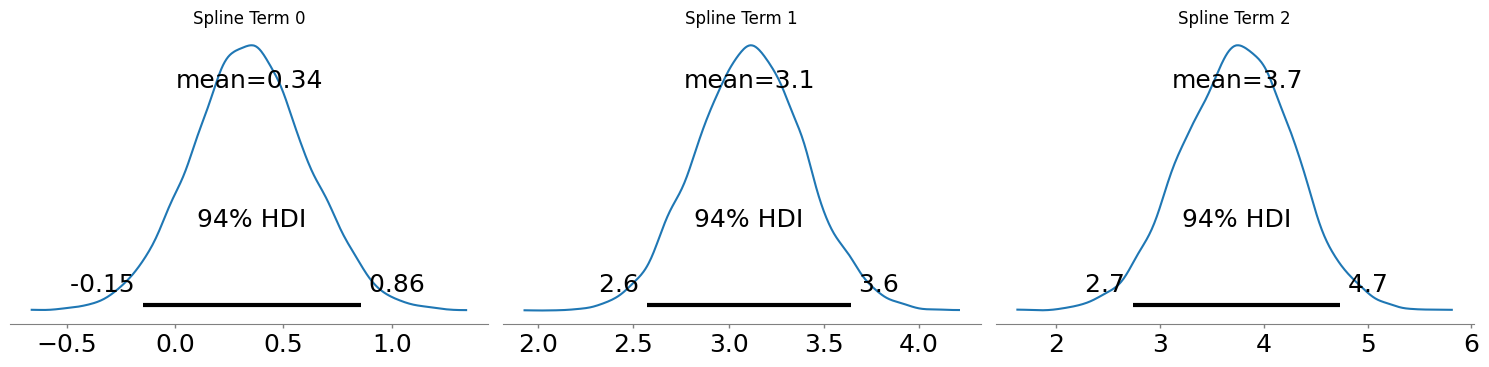

In [ ]:
import matplotlib.pyplot as plt
import arviz as az
import os

# Prepare figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot each spline coefficient in its subplot
for i in range(3):
    az.plot_posterior(
        results_plas_litter_std_spline,
        var_names=["bs(log_plas_litter_std, df=3)"],
        coords={"bs(log_plas_litter_std, df=3)_dim": [i]},
        hdi_prob=0.94,
        ax=axes[i]
    )
    axes[i].set_title(f"Spline Term {i}", fontsize=12)

# Final layout and export
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig(os.path.join(image_folder, "2B_spline_posterior_subplot.pdf"), format="pdf", dpi=300)
plt.show()



/usr/local/lib/python3.10/dist-packages/bambi/models.py:851: FutureWarning: 'mean' has been replaced by 'response_params' and is not going to work in the future
  warnings.warn(


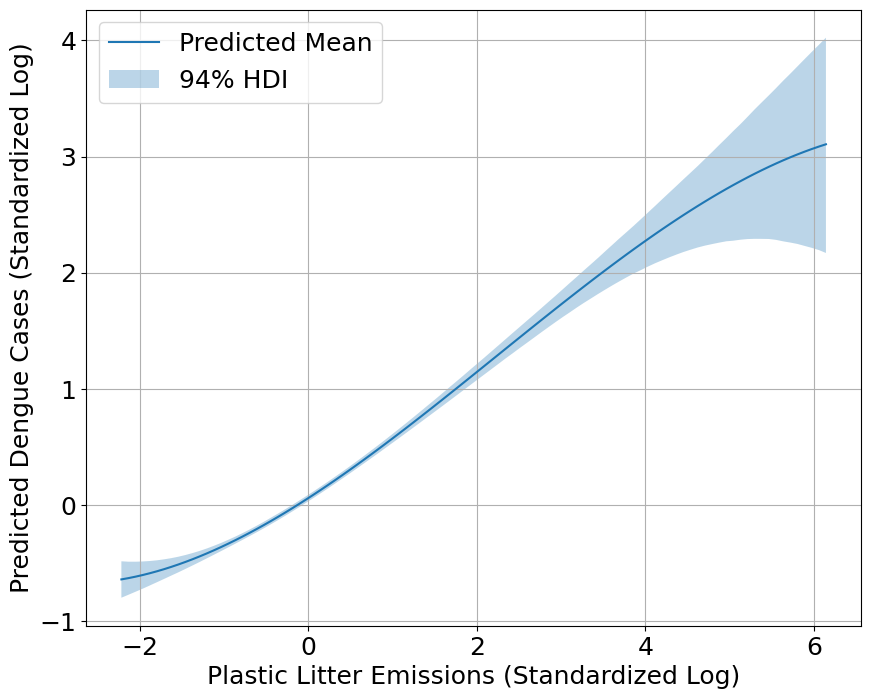

In [ ]:
predictors = ["bs(log_plas_litter_std, df=3)"]
idata2B = results_plas_litter_std_spline  # just to align with your original code


var = "log_plas_litter_std"
x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

# Fix others at mean, and add placeholder country
df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in ["log_plas_litter_std"]}, index=range(100))
df_pred[var] = x_vals
df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # Add known group

# Predict
pred = model_plas_litter_std_spline.predict(idata=idata2B, data=df_pred, kind="mean", inplace=False)
mu = pred.posterior["mu"]
pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
pred_hdi = xr.concat([
    mu.quantile(0.03, dim=["chain", "draw"]),
    mu.quantile(0.97, dim=["chain", "draw"])
], dim="quantile").values

# Plot
plt.figure(figsize=(10, 8))
plt.plot(x_vals, pred_mean, label="Predicted Mean")
plt.fill_between(x_vals, pred_hdi[0], pred_hdi[1], alpha=0.3, label="94% HDI")
plt.xlabel("Plastic Litter Emissions (Standardized Log)")
plt.ylabel("Predicted Dengue Cases (Standardized Log)")

plt.legend()
plt.grid(True)
plt.savefig(os.path.join(image_folder, "2B_marginal_effect_pwg_log_std_spline.pdf"), format='pdf', dpi=300)
plt.show()

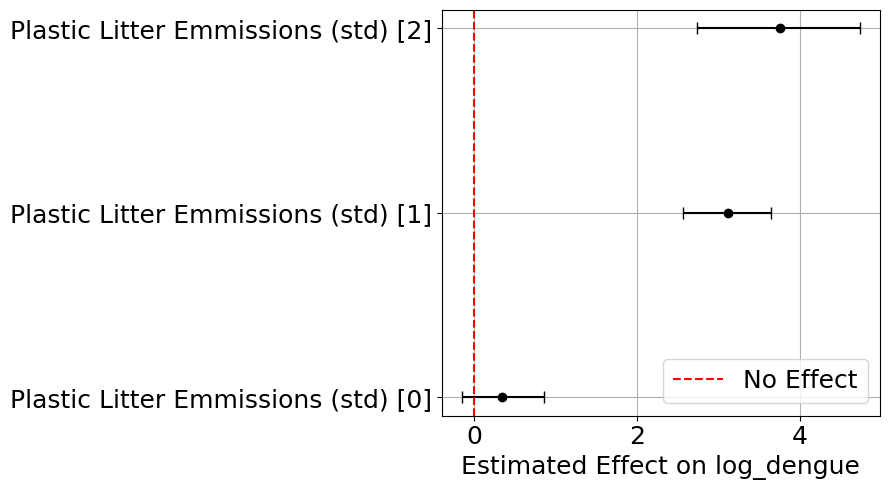

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

summary = az.summary(
    idata2B,
    var_names=["bs(log_plas_litter_std, df=3)"]
)
summary.index = [f"Plastic Litter Emmissions (std) [{i}]" for i in range(len(summary))]

means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

plt.figure(figsize=(9, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"2B_Posterior_Means_and_9%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()

## **3A pwg_gdp_std**

In [ ]:
model_pwg_gdp_std = bmb.Model(
    "log_dengue_std  ~ pwg_log_std + gdp_std + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_pwg_gdp_std = model_pwg_gdp_std.fit(
    draws=2000,
    tune=1000,
    idata_kwargs={"log_likelihood": True},
    chains = 4,
    target_accept=0.98,
    cores = 2)

az.summary(results_pwg_gdp_std, round_to = 4)

idata3A = results_pwg_gdp_std

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata3A = results_pwg_gdp_std
"log_likelihood" in idata3A.groups()

True

In [ ]:
az.summary(idata3A, round_to = 4)


mean      sd  hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.5469  0.4605 -1.4332   0.2844   
1|adm_0_name[brazil]                    0.5823  0.4327 -0.2586   1.3786   
1|adm_0_name[china]                     0.9691  0.6577 -0.2643   2.2764   
1|adm_0_name[colombia]                  0.2968  0.4626 -0.5840   1.1399   
1|adm_0_name[costa rica]                0.5331  0.4728 -0.3646   1.4074   
1|adm_0_name[pakistan]                 -1.4437  0.5151 -2.4186  -0.4928   
1|adm_0_name[peru]                      0.2561  0.4671 -0.6474   1.1011   
1|adm_0_name[united states of america] -0.6517  0.9428 -2.4810   1.1530   
1|adm_0_name_sigma                      1.0770  0.3923  0.5014   1.8100   
Intercept                              -0.4818  0.4352 -1.2401   0.4007   
gdp_std                                -0.0726  0.0866 -0.2405   0.0922   
pwg_log_std                             0.5332  0.0114  0.5132   0.5559   
sigma                                   0.8511  0.0074  0.8374   0.8646   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0111   0.0078  1753.3280   
1|adm_0_name[brazil]                       0.0103   0.0073  1778.0327   
1|adm_0_name[china]                        0.0104   0.0083  4081.5349   
1|adm_0_name[colombia]                     0.0112   0.0079  1735.6707   
1|adm_0_name[costa rica]                   0.0112   0.0079  1811.8563   
1|adm_0_name[pakistan]                     0.0112   0.0079  2201.6011   
1|adm_0_name[peru]                         0.0112   0.0079  1774.3211   
1|adm_0_name[united states of america]     0.0154   0.0115  3880.4260   
1|adm_0_name_sigma                         0.0084   0.0060  2080.9289   
Intercept                                  0.0104   0.0074  1774.4134   
gdp_std                                    0.0017   0.0012  2829.3019   
pwg_log_std                                0.0001   0.0001  6931.8227   
sigma                                      0.0001   0.0001  7044.7654   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 2429.5933  1.0028  
1|adm_0_name[brazil]                    2321.7215  1.0027  
1|adm_0_name[china]                     3650.7204  1.0002  
1|adm_0_name[colombia]                  2256.8994  1.0030  
1|adm_0_name[costa rica]                2509.9293  1.0029  
1|adm_0_name[pakistan]                  2783.7729  1.0020  
1|adm_0_name[peru]                      2682.6329  1.0026  
1|adm_0_name[united states of america]  3058.3277  1.0006  
1|adm_0_name_sigma                      3134.7164  1.0014  
Intercept                               2371.1042  1.0027  
gdp_std                                 2956.8684  1.0013  
pwg_log_std                             4485.0367  1.0006  
sigma                                   5014.4027  1.0004

In [ ]:
idata3A = results_pwg_gdp_std

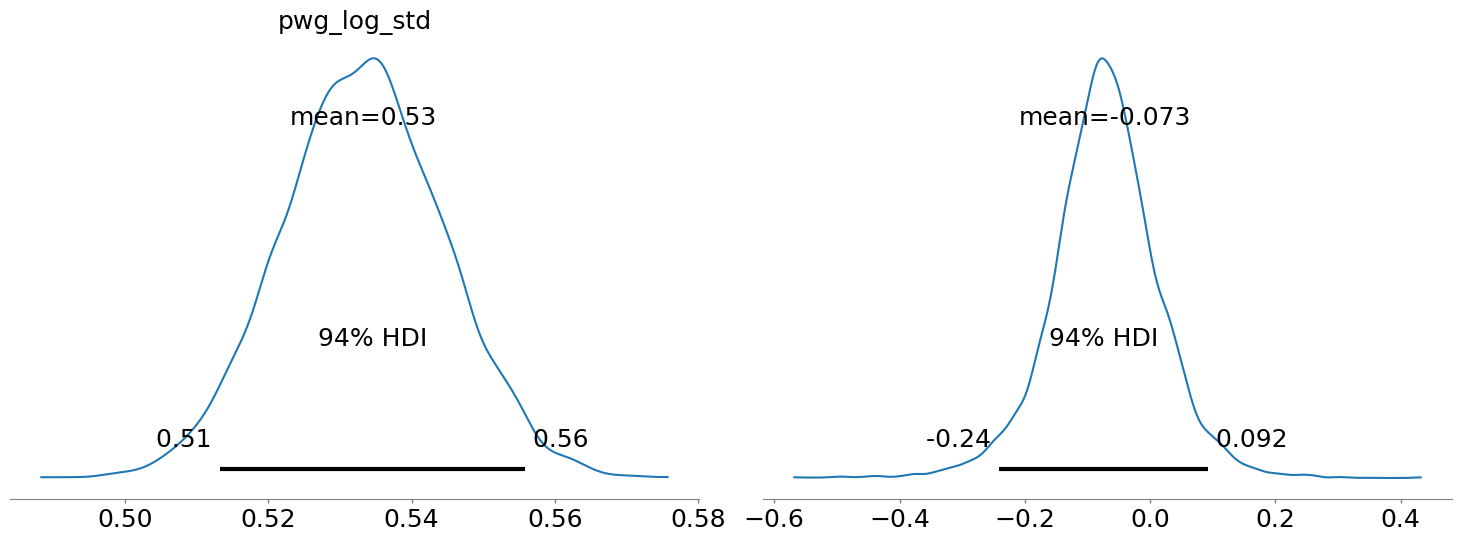

In [ ]:
az.plot_posterior(results_pwg_gdp_std, var_names=["pwg_log_std", "gdp_std"], hdi_prob=0.94)
plt.gca().set_title("")  # clears title for current axis

plt.tight_layout()
plt.gca().set_title("")  # clears title for current axis

plt.savefig(os.path.join(image_folder, f"3A_model_pwg_gdp_std_plot_posterior.pdf"), format='pdf', dpi=3000)
plt.show()

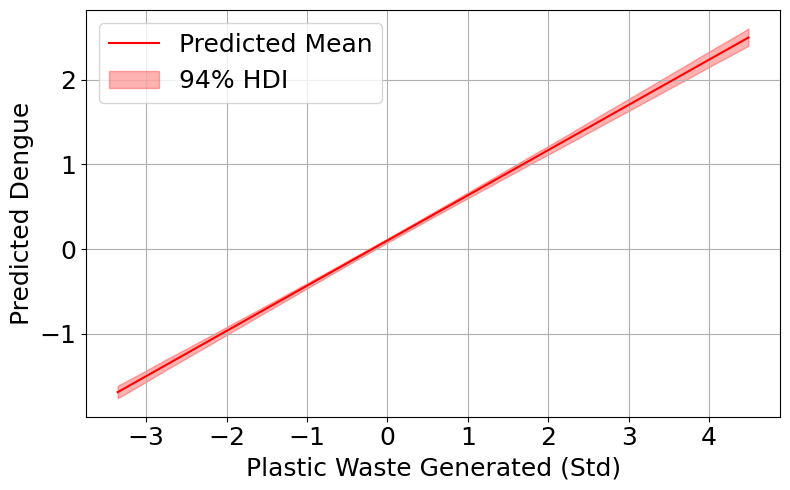

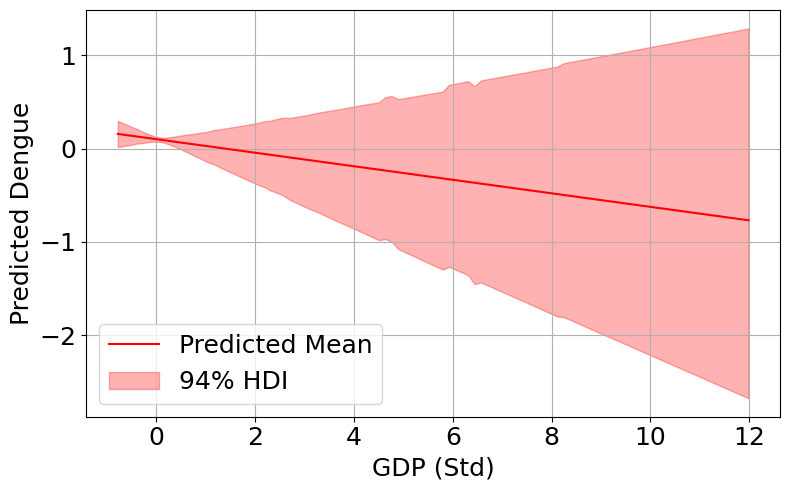

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["pwg_log_std", "gdp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe with all means
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals  # vary current var
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # known group

    # Predict
    pred = model_pwg_gdp_std.predict(idata=idata3A, data=df_pred, kind="response_params", inplace=False)

    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.94)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDI")
    plt.xlabel(map_names[var])
    plt.ylabel("Predicted Dengue")
    # plt.title(f"Marginal Effect of {map_names[var]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"3A_marginal_effect_pwg_gdp_std{var}.pdf"), format='pdf', dpi=3000)

    plt.show()





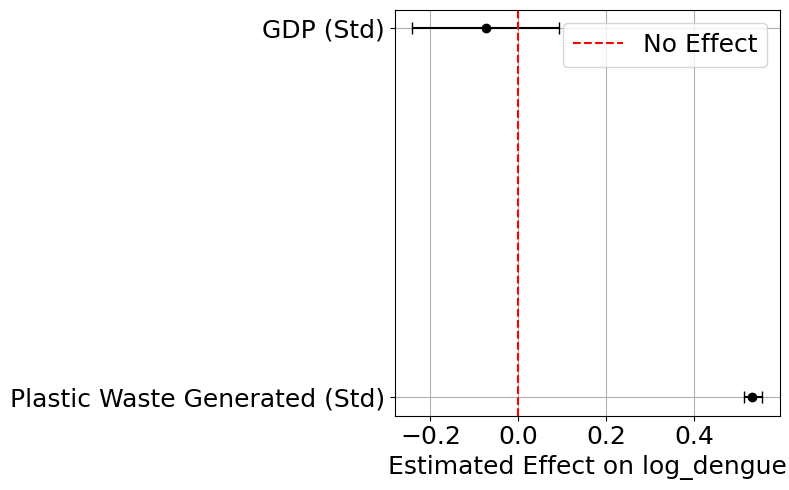

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

map_names = {
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "gdp_std": "GDP (Std)"
}

summary = az.summary(
    idata3A,
    var_names=["pwg_log_std", "gdp_std" ]
)
summary.index = [map_names.get(var, var) for var in summary.index]

means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

plt.figure(figsize=(8, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"3A_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()

## **3B pwg_gdp_std_splines**

In [ ]:
model_pwg_gdp_std_splines = bmb.Model(
    "log_dengue_std  ~  bs(pwg_log_std, df = 3) +  bs(gdp_std, df = 3) + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_pwg_gdp_std_splines = model_pwg_gdp_std_splines.fit(
    draws=2000,
    tune=1000,
    idata_kwargs={"log_likelihood": True},
    chains = 4,
    target_accept=0.98,
    cores = 2)

idata3B = results_pwg_gdp_std_splines

Output()

ERROR:pymc.stats.convergence:There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata3B = results_pwg_gdp_std_splines
"log_likelihood" in idata3B.groups()

True

In [ ]:
az.summary(results_pwg_gdp_std_splines, round_to = 4)


mean       sd   hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.4553   0.7120  -1.7526   0.8750   
1|adm_0_name[brazil]                    0.2894   1.5009  -2.8525   2.9888   
1|adm_0_name[china]                    -0.0633   1.6207  -2.9958   3.1664   
1|adm_0_name[colombia]                  0.4682   0.7435  -0.9231   1.8478   
1|adm_0_name[costa rica]                0.8200   0.8920  -0.7360   2.6033   
1|adm_0_name[pakistan]                 -1.5839   0.7706  -3.0075  -0.1563   
1|adm_0_name[peru]                      0.4425   0.7824  -1.0167   1.9095   
1|adm_0_name[united states of america] -0.0528   1.5936  -2.9766   2.9988   
1|adm_0_name_sigma                      1.4491   0.7786   0.5071   2.8372   
Intercept                              -1.0967   0.9160  -2.7995   0.6035   
bs(gdp_std, df=3)[0]                    2.9811  11.0426 -17.1692  25.1621   
bs(gdp_std, df=3)[1]                    0.7149   5.7861 -10.2898  12.0251   
bs(gdp_std, df=3)[2]                   -1.5252   1.8320  -4.9229   2.0091   
bs(pwg_log_std, df=3)[0]               -1.3049   0.5151  -2.2872  -0.3420   
bs(pwg_log_std, df=3)[1]                1.8851   0.1660   1.5793   2.2036   
bs(pwg_log_std, df=3)[2]                3.3453   0.4406   2.4995   4.1541   
sigma                                   0.8455   0.0074   0.8313   0.8592   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0187   0.0146  1596.3865   
1|adm_0_name[brazil]                       0.0476   0.0337  1070.3696   
1|adm_0_name[china]                        0.0267   0.0259  4304.8810   
1|adm_0_name[colombia]                     0.0193   0.0152  1646.4100   
1|adm_0_name[costa rica]                   0.0234   0.0179  1612.3961   
1|adm_0_name[pakistan]                     0.0194   0.0147  1749.6624   
1|adm_0_name[peru]                         0.0203   0.0162  1657.0076   
1|adm_0_name[united states of america]     0.0311   0.0245  2916.5774   
1|adm_0_name_sigma                         0.0219   0.0155  1419.1275   
Intercept                                  0.0237   0.0177  1667.1500   
bs(gdp_std, df=3)[0]                       0.3410   0.2412  1119.9216   
bs(gdp_std, df=3)[1]                       0.1600   0.1131  1380.4855   
bs(gdp_std, df=3)[2]                       0.0437   0.0337  2032.6208   
bs(pwg_log_std, df=3)[0]                   0.0096   0.0069  2891.1279   
bs(pwg_log_std, df=3)[1]                   0.0021   0.0015  6062.5314   
bs(pwg_log_std, df=3)[2]                   0.0086   0.0061  2635.8834   
sigma                                      0.0001   0.0001  8290.9898   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 2178.3594  1.0018  
1|adm_0_name[brazil]                    1238.6845  1.0017  
1|adm_0_name[china]                     2587.1857  1.0007  
1|adm_0_name[colombia]                  2283.1921  1.0024  
1|adm_0_name[costa rica]                2065.6176  1.0031  
1|adm_0_name[pakistan]                  2487.2298  1.0024  
1|adm_0_name[peru]                      2361.3495  1.0028  
1|adm_0_name[united states of america]  3001.4978  1.0013  
1|adm_0_name_sigma                      1948.2445  1.0009  
Intercept                               2279.5162  1.0036  
bs(gdp_std, df=3)[0]                    1447.5868  1.0030  
bs(gdp_std, df=3)[1]                    1684.2738  1.0023  
bs(gdp_std, df=3)[2]                    2063.9548  1.0035  
bs(pwg_log_std, df=3)[0]                3928.4173  1.0003  
bs(pwg_log_std, df=3)[1]                4871.6635  1.0014  
bs(pwg_log_std, df=3)[2]                4211.1151  1.0008  
sigma                                   4963.0856  0.9999

In [ ]:
idata3B = results_pwg_gdp_std_splines

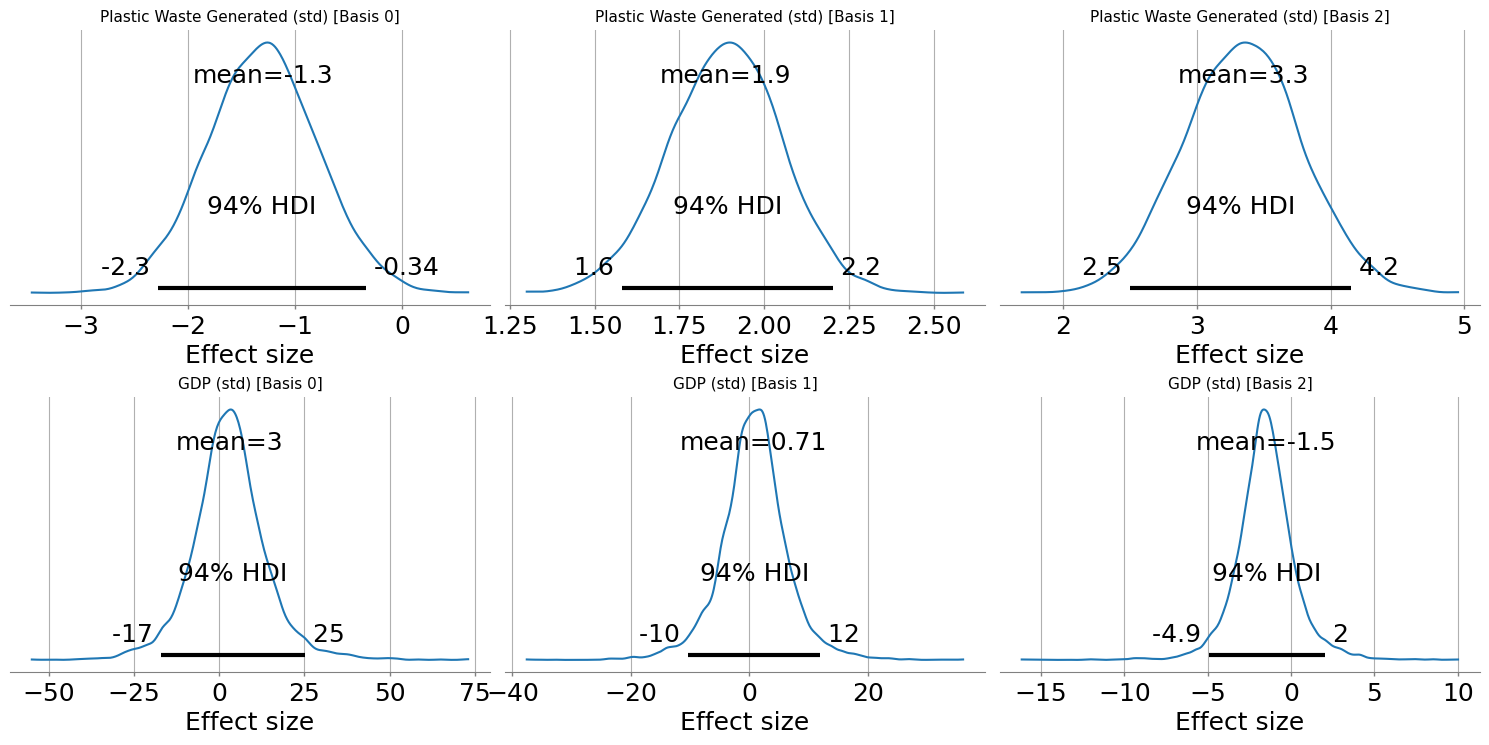

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import os

# Each variable and how many basis terms it has
spline_vars = {
    "bs(pwg_log_std, df=3)": 3,
    "bs(gdp_std, df=3)": 3
}
readable_names = {
    "bs(pwg_log_std, df=3)": "Plastic Waste Generated (std)",
    "bs(gdp_std, df=3)": "GDP (std)"
}
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

i = 0
for var, n_basis in spline_vars.items():
    for j in range(n_basis):
        az.plot_posterior(
            idata3B,
            var_names=[var],
            coords={f"{var}_dim": [j]},
            hdi_prob=0.94,
            point_estimate="mean",
            ax=axes[i]
        )
        axes[i].set_title(f"{readable_names[var]} [Basis {j}]", fontsize=11)
        axes[i].set_xlabel("Effect size")
        axes[i].grid(True)
        i += 1

# plt.suptitle("Posterior Distributions of Spline Terms", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(os.path.join(image_folder, "3B_spline_posterior_subplot.pdf"), format="pdf", dpi=300)
plt.show()


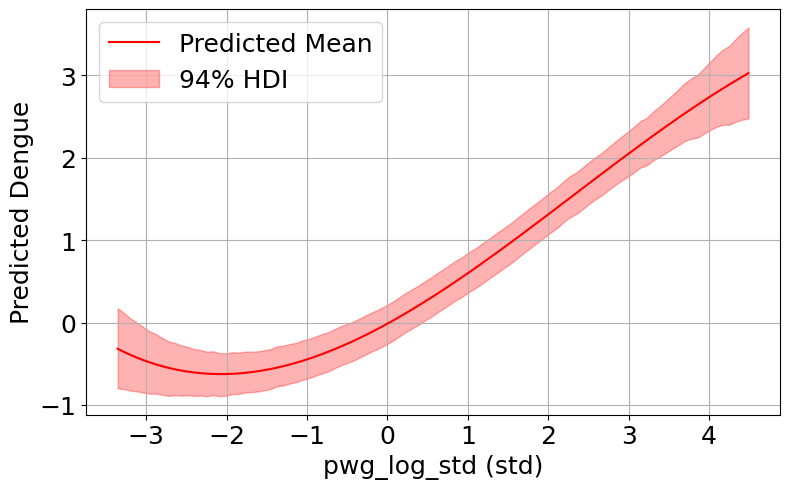

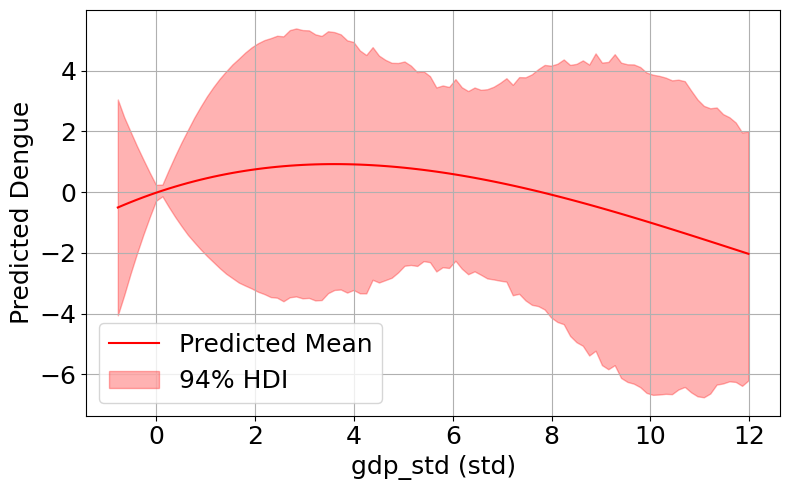

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["pwg_log_std", "gdp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std": "Plastic Litter Emmitted (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe with all means
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals  # vary current var
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # known group

    # Predict
    pred = model_pwg_gdp_std_splines.predict(idata=idata3B, data=df_pred, kind="response_params", inplace=False)

    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.94)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDI")
    plt.xlabel(f"{var} (std)")
    plt.ylabel("Predicted Dengue")
    # plt.title(f"Marginal Effect of {map_names[var]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"3B_marginal_effect_pwg_log_std_std{var}.pdf"), format='pdf', dpi=3000)

    plt.show()





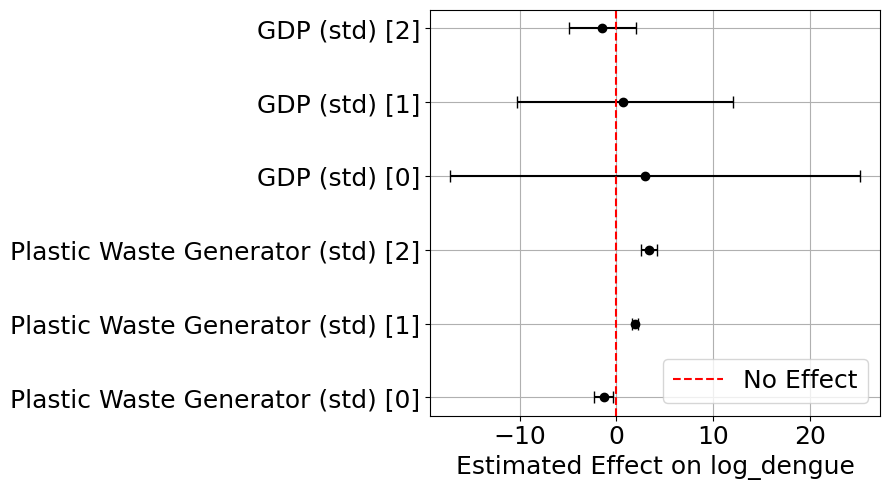

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
readable_names = {
    "bs(pwg_log_std, df=3)": "Plastic Waste Generator (std)",
    "bs(gdp_std, df=3)": "GDP (std)"
}
summary = az.summary(
    idata3B,
    var_names=["bs(pwg_log_std, df=3)", "bs(gdp_std, df=3)"]
)
new_index = []
for var in summary.index:
    # Match spline var name (e.g., "bs(pwg_log_std, df=3)[0]") to key
    base_name = var.split("[")[0]
    idx = var.split("[")[1].rstrip("]") if "[" in var else ""
    label = f"{readable_names.get(base_name, base_name)} [{idx}]"
    new_index.append(label)

summary.index = new_index
means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

plt.figure(figsize=(9, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"3B_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()

## **4AA plas_litter_gdp_std**

In [ ]:
model_plas_litter_gdp_std = bmb.Model(
    "log_dengue_std  ~ log_plas_litter_std + gdp_std + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_plas_litter_gdp_std = model_plas_litter_gdp_std.fit(
    draws=2000,
    tune=1000,
    idata_kwargs={"log_likelihood": True},
    chains = 4,
    target_accept=0.98,
    cores = 2)

az.summary(results_plas_litter_gdp_std, round_to = 4)

Output()

mean      sd  hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.3910  0.5763 -1.5814   0.6412   
1|adm_0_name[brazil]                    0.7234  0.5421 -0.2938   1.7841   
1|adm_0_name[china]                     0.7910  0.8487 -0.8670   2.2995   
1|adm_0_name[colombia]                  0.4917  0.5800 -0.6413   1.5842   
1|adm_0_name[costa rica]                0.8521  0.5888 -0.2608   2.0150   
1|adm_0_name[pakistan]                 -2.2052  0.6391 -3.3737  -0.9861   
1|adm_0_name[peru]                      0.1135  0.5867 -1.0539   1.1941   
1|adm_0_name[united states of america] -0.5331  1.2284 -2.9851   1.5851   
1|adm_0_name_sigma                      1.3560  0.4771  0.6336   2.2095   
Intercept                              -0.6255  0.5453 -1.6801   0.4116   
gdp_std                                -0.0264  0.1125 -0.2322   0.1872   
log_plas_litter_std                     0.4752  0.0124  0.4528   0.4991   
sigma                                   0.8888  0.0079  0.8739   0.9033   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0148   0.0104  1533.4887   
1|adm_0_name[brazil]                       0.0137   0.0097  1574.1998   
1|adm_0_name[china]                        0.0143   0.0116  3760.9029   
1|adm_0_name[colombia]                     0.0149   0.0105  1522.0002   
1|adm_0_name[costa rica]                   0.0149   0.0105  1587.4801   
1|adm_0_name[pakistan]                     0.0159   0.0112  1651.7518   
1|adm_0_name[peru]                         0.0151   0.0107  1524.3190   
1|adm_0_name[united states of america]     0.0218   0.0161  3410.3385   
1|adm_0_name_sigma                         0.0107   0.0076  1852.5925   
Intercept                                  0.0138   0.0098  1568.0356   
gdp_std                                    0.0024   0.0018  2362.7491   
log_plas_litter_std                        0.0001   0.0001  6851.3418   
sigma                                      0.0001   0.0001  7394.3801   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 2395.0301  1.0027  
1|adm_0_name[brazil]                    2485.6606  1.0026  
1|adm_0_name[china]                     4114.0123  1.0015  
1|adm_0_name[colombia]                  2451.4700  1.0028  
1|adm_0_name[costa rica]                2323.7358  1.0026  
1|adm_0_name[pakistan]                  2875.2682  1.0018  
1|adm_0_name[peru]                      2313.5206  1.0027  
1|adm_0_name[united states of america]  3530.0461  1.0010  
1|adm_0_name_sigma                      3643.3606  1.0023  
Intercept                               2465.1091  1.0026  
gdp_std                                 3033.5088  1.0019  
log_plas_litter_std                     4966.6897  1.0003  
sigma                                   4548.5238  1.0013

In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata4A = results_plas_litter_gdp_std
"log_likelihood" in idata4A.groups()

True

In [ ]:
idata4A = results_plas_litter_gdp_std


In [ ]:
az.summary(idata4A, round_to = 4)


mean      sd  hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.3910  0.5763 -1.5814   0.6412   
1|adm_0_name[brazil]                    0.7234  0.5421 -0.2938   1.7841   
1|adm_0_name[china]                     0.7910  0.8487 -0.8670   2.2995   
1|adm_0_name[colombia]                  0.4917  0.5800 -0.6413   1.5842   
1|adm_0_name[costa rica]                0.8521  0.5888 -0.2608   2.0150   
1|adm_0_name[pakistan]                 -2.2052  0.6391 -3.3737  -0.9861   
1|adm_0_name[peru]                      0.1135  0.5867 -1.0539   1.1941   
1|adm_0_name[united states of america] -0.5331  1.2284 -2.9851   1.5851   
1|adm_0_name_sigma                      1.3560  0.4771  0.6336   2.2095   
Intercept                              -0.6255  0.5453 -1.6801   0.4116   
gdp_std                                -0.0264  0.1125 -0.2322   0.1872   
log_plas_litter_std                     0.4752  0.0124  0.4528   0.4991   
sigma                                   0.8888  0.0079  0.8739   0.9033   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0148   0.0104  1533.4887   
1|adm_0_name[brazil]                       0.0137   0.0097  1574.1998   
1|adm_0_name[china]                        0.0143   0.0116  3760.9029   
1|adm_0_name[colombia]                     0.0149   0.0105  1522.0002   
1|adm_0_name[costa rica]                   0.0149   0.0105  1587.4801   
1|adm_0_name[pakistan]                     0.0159   0.0112  1651.7518   
1|adm_0_name[peru]                         0.0151   0.0107  1524.3190   
1|adm_0_name[united states of america]     0.0218   0.0161  3410.3385   
1|adm_0_name_sigma                         0.0107   0.0076  1852.5925   
Intercept                                  0.0138   0.0098  1568.0356   
gdp_std                                    0.0024   0.0018  2362.7491   
log_plas_litter_std                        0.0001   0.0001  6851.3418   
sigma                                      0.0001   0.0001  7394.3801   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 2395.0301  1.0027  
1|adm_0_name[brazil]                    2485.6606  1.0026  
1|adm_0_name[china]                     4114.0123  1.0015  
1|adm_0_name[colombia]                  2451.4700  1.0028  
1|adm_0_name[costa rica]                2323.7358  1.0026  
1|adm_0_name[pakistan]                  2875.2682  1.0018  
1|adm_0_name[peru]                      2313.5206  1.0027  
1|adm_0_name[united states of america]  3530.0461  1.0010  
1|adm_0_name_sigma                      3643.3606  1.0023  
Intercept                               2465.1091  1.0026  
gdp_std                                 3033.5088  1.0019  
log_plas_litter_std                     4966.6897  1.0003  
sigma                                   4548.5238  1.0013

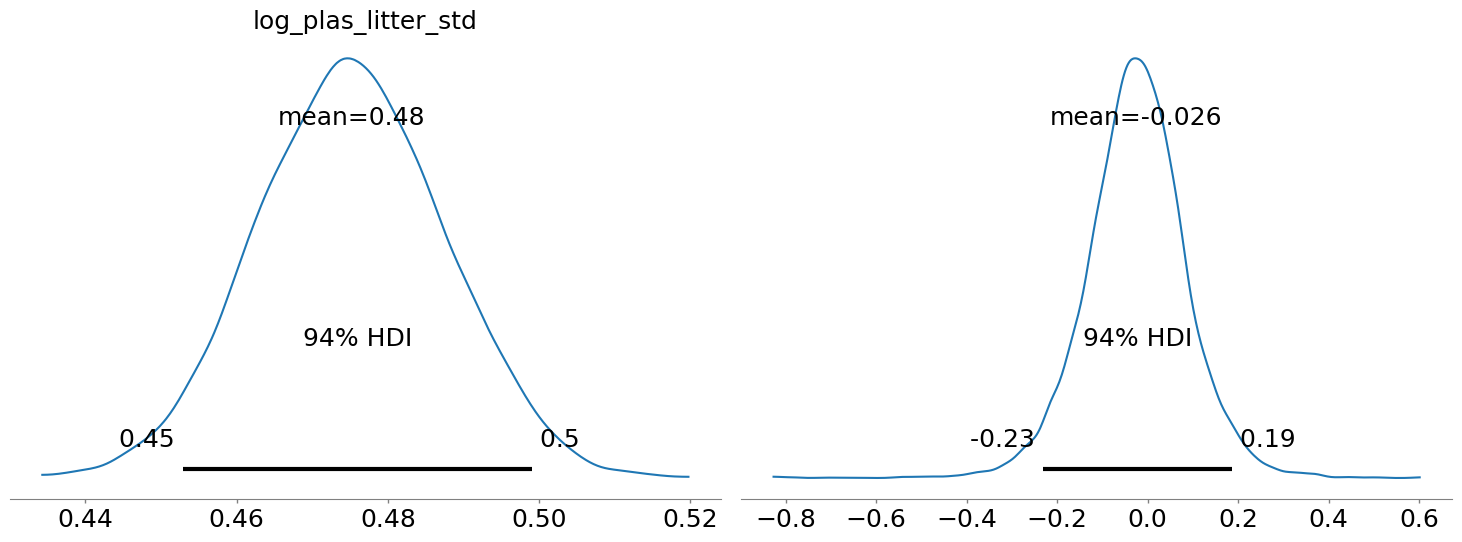

In [ ]:
az.plot_posterior(results_plas_litter_gdp_std, var_names=["log_plas_litter_std", "gdp_std"], hdi_prob=0.94)
plt.gca().set_title("")  # clears title for current axis

plt.tight_layout()
plt.gca().set_title("")  # clears title for current axis

plt.savefig(os.path.join(image_folder, f"4A_model_plas_litter_gdp_std_plot_posterior.pdf"), format='pdf', dpi=3000)
plt.show()


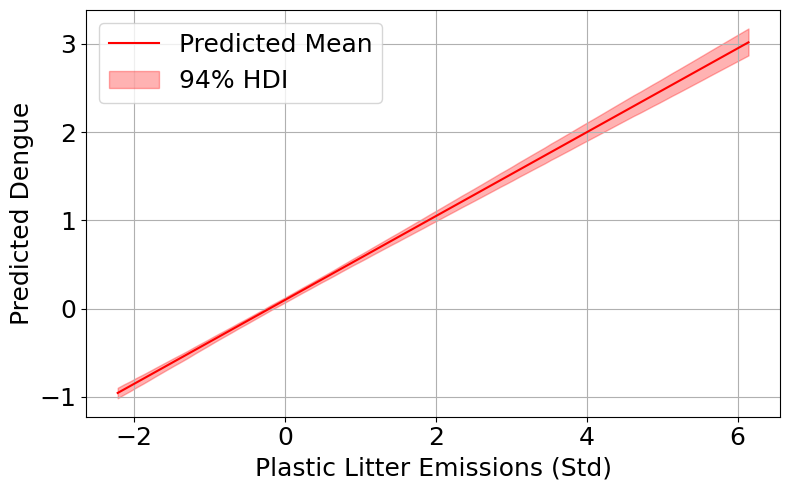

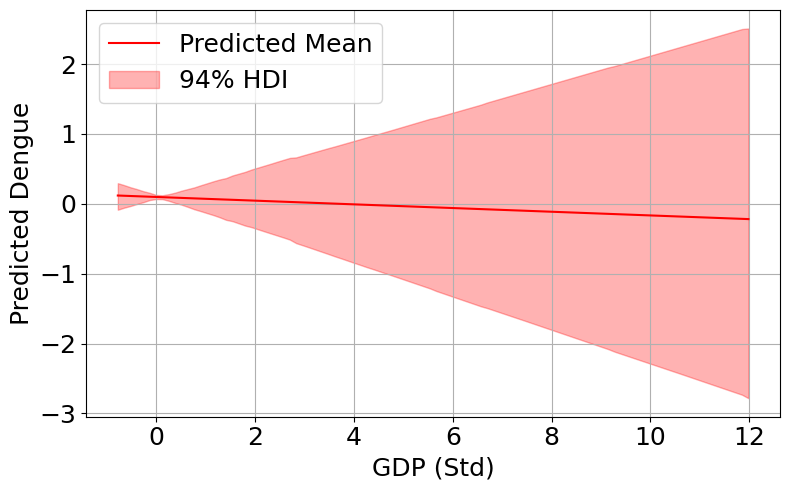

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["log_plas_litter_std", "gdp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std" : "Plastic Litter Emissions (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe with all means
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals  # vary current var
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # known group

    # Predict
    pred = model_plas_litter_gdp_std.predict(idata=idata4A, data=df_pred, kind="response_params", inplace=False)

    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.95)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDI")
    plt.xlabel(map_names[var])
    plt.ylabel("Predicted Dengue")
    # plt.title(f"Marginal Effect of {map_names[var]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"4A_marginal_effect_plas_litter_gdp_std{var}.pdf"), format='pdf', dpi=3000)

    plt.show()


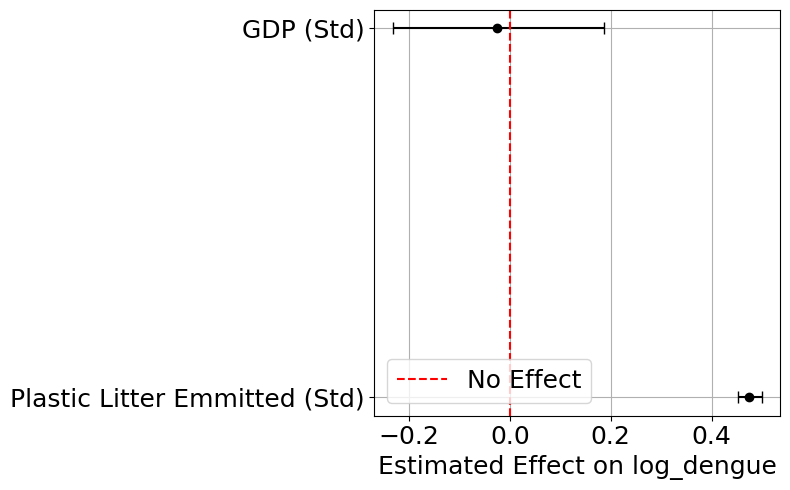

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

map_names = {
    "log_plas_litter_std": "Plastic Litter Emmitted (Std)",
    "gdp_std": "GDP (Std)"
}

summary = az.summary(
    idata4A,
    var_names=["log_plas_litter_std", "gdp_std" ]
)
summary.index = [map_names.get(var, var) for var in summary.index]

means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

plt.figure(figsize=(8, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"4A_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()

## **4BB plas_litter_gdp_std_splines**

In [ ]:
model_plas_litter_gdp_std_spline = bmb.Model(
    "log_dengue_std  ~  bs(log_plas_litter_std, df = 3) +  bs(gdp_std, df = 3) + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_plas_litter_gdp_std_spline = model_plas_litter_gdp_std_spline.fit(
    draws=2000,
    tune=1000,
    chains = 4,
    idata_kwargs={"log_likelihood": True},
    target_accept=0.98,
    cores = 2)

idata4B = results_plas_litter_gdp_std_spline

Output()

ERROR:pymc.stats.convergence:There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata4B = results_plas_litter_gdp_std_spline
"log_likelihood" in idata4B.groups()

True

In [ ]:
az.summary(idata4B, round_to = 4)


mean       sd   hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.2435   0.8792  -1.8528   1.4085   
1|adm_0_name[brazil]                    0.3596   1.8121  -3.0131   3.8722   
1|adm_0_name[china]                     0.0242   2.0803  -4.0401   3.9754   
1|adm_0_name[colombia]                  0.7305   0.9199  -0.9691   2.5141   
1|adm_0_name[costa rica]                1.2145   1.1016  -0.9846   3.2975   
1|adm_0_name[pakistan]                 -2.2638   0.9599  -4.0641  -0.4639   
1|adm_0_name[peru]                      0.3150   0.9670  -1.5369   2.1601   
1|adm_0_name[united states of america] -0.0633   2.0401  -3.9824   3.8079   
1|adm_0_name_sigma                      1.9043   0.9467   0.6432   3.5720   
Intercept                              -1.7224   1.1023  -3.8149   0.4427   
bs(gdp_std, df=3)[0]                    4.1214  13.3724 -22.1768  28.7429   
bs(gdp_std, df=3)[1]                    0.2225   7.1565 -13.8649  13.8468   
bs(gdp_std, df=3)[2]                   -0.5481   2.3162  -4.7414   4.0234   
bs(log_plas_litter_std, df=3)[0]        0.3574   0.2654  -0.1480   0.8457   
bs(log_plas_litter_std, df=3)[1]        3.0845   0.2858   2.5392   3.6084   
bs(log_plas_litter_std, df=3)[2]        3.8120   0.5344   2.8367   4.8440   
sigma                                   0.8873   0.0077   0.8725   0.9018   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0245   0.0173  1358.4307   
1|adm_0_name[brazil]                       0.0557   0.0394  1123.8090   
1|adm_0_name[china]                        0.0370   0.0290  3322.0147   
1|adm_0_name[colombia]                     0.0253   0.0179  1358.1212   
1|adm_0_name[costa rica]                   0.0301   0.0213  1363.2204   
1|adm_0_name[pakistan]                     0.0255   0.0180  1486.0179   
1|adm_0_name[peru]                         0.0265   0.0188  1354.0467   
1|adm_0_name[united states of america]     0.0472   0.0355  2182.9043   
1|adm_0_name_sigma                         0.0265   0.0188  1408.2974   
Intercept                                  0.0304   0.0215  1339.9692   
bs(gdp_std, df=3)[0]                       0.4107   0.2905  1121.1992   
bs(gdp_std, df=3)[1]                       0.2046   0.1447  1288.8954   
bs(gdp_std, df=3)[2]                       0.0612   0.0443  1604.0315   
bs(log_plas_litter_std, df=3)[0]           0.0053   0.0038  2472.7637   
bs(log_plas_litter_std, df=3)[1]           0.0061   0.0043  2223.9315   
bs(log_plas_litter_std, df=3)[2]           0.0111   0.0079  2304.2515   
sigma                                      0.0001   0.0001  6057.7582   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 1810.1338  1.0013  
1|adm_0_name[brazil]                    1542.8829  1.0015  
1|adm_0_name[china]                     3430.3878  1.0013  
1|adm_0_name[colombia]                  1814.6825  1.0010  
1|adm_0_name[costa rica]                1594.1121  1.0006  
1|adm_0_name[pakistan]                  1872.8137  1.0008  
1|adm_0_name[peru]                      1669.6442  1.0009  
1|adm_0_name[united states of america]  1763.3392  1.0016  
1|adm_0_name_sigma                      1821.0098  1.0020  
Intercept                               1557.8461  1.0008  
bs(gdp_std, df=3)[0]                    1663.4982  1.0013  
bs(gdp_std, df=3)[1]                    1677.3414  1.0022  
bs(gdp_std, df=3)[2]                    1929.5430  1.0021  
bs(log_plas_litter_std, df=3)[0]        3670.4662  1.0019  
bs(log_plas_litter_std, df=3)[1]        3220.3838  1.0018  
bs(log_plas_litter_std, df=3)[2]        3406.1317  1.0017  
sigma                                   5224.0092  1.0005

In [ ]:
idata4B.posterior.keys()


KeysView(<xarray.Dataset> Size: 1MB
Dimensions:                            (chain: 4, draw: 2000,
                                        adm_0_name__factor_dim: 8,
                                        bs(gdp_std, df=3)_dim: 3,
                                        bs(log_plas_litter_std, df=3)_dim: 3)
Coordinates:
  * chain                              (chain) int64 32B 0 1 2 3
  * draw                               (draw) int64 16kB 0 1 2 ... 1998 1999
  * adm_0_name__factor_dim             (adm_0_name__factor_dim) <U24 768B 'ar...
  * bs(gdp_std, df=3)_dim              (bs(gdp_std, df=3)_dim) int64 24B 0 1 2
  * bs(log_plas_litter_std, df=3)_dim  (bs(log_plas_litter_std, df=3)_dim) int64 24B ...
Data variables:
    1|adm_0_name                       (chain, draw, adm_0_name__factor_dim) float64 512kB ...
    1|adm_0_name_sigma                 (chain, draw) float64 64kB 1.46 ... 1.643
    Intercept                          (chain, draw) float64 64kB -1.322 ... ...
    bs(gdp_std

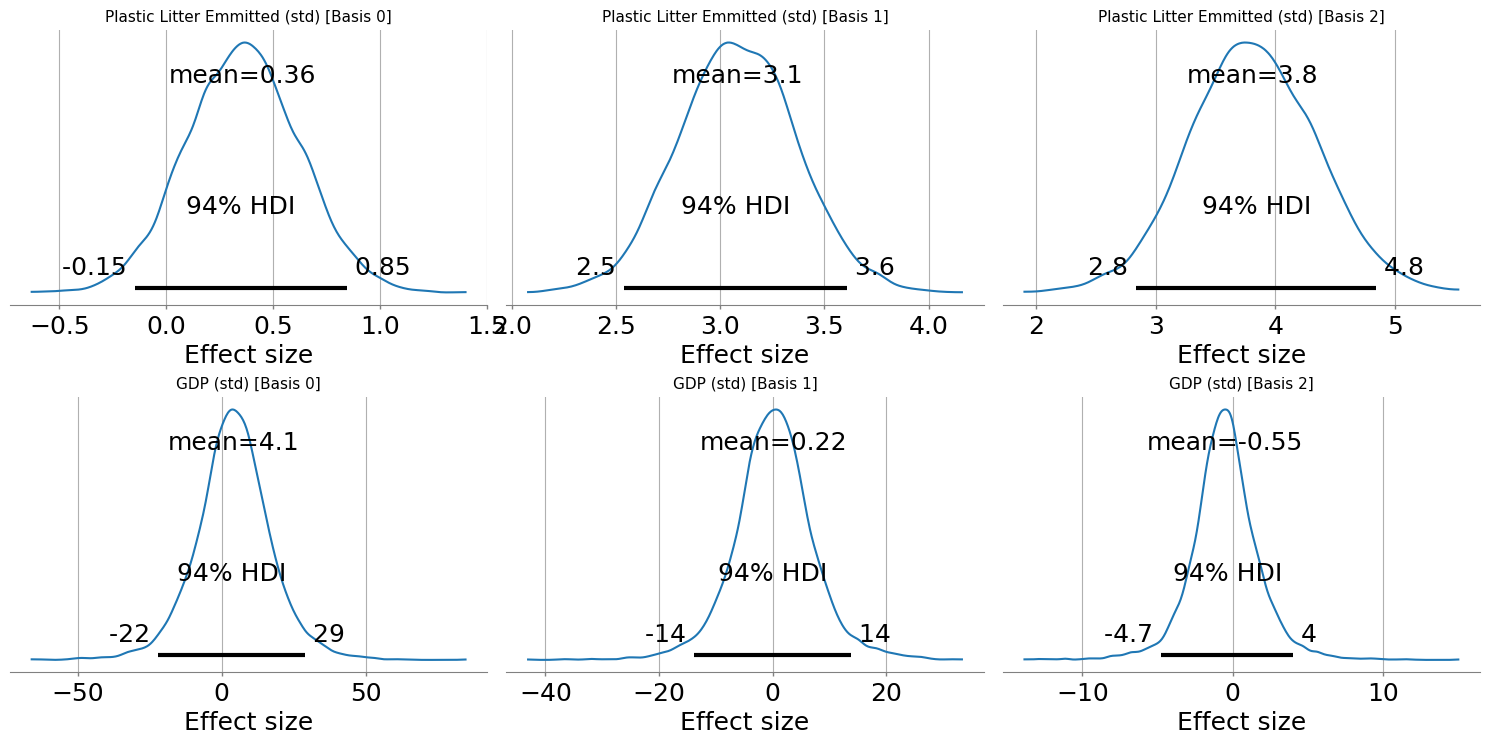

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import os

# Each variable and how many basis terms it has
spline_vars = {
    "bs(log_plas_litter_std, df=3)": 3,
    "bs(gdp_std, df=3)": 3
}
readable_names = {
    "bs(log_plas_litter_std, df=3)": "Plastic Litter Emmitted (std)",
    "bs(gdp_std, df=3)": "GDP (std)"
}
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

i = 0
for var, n_basis in spline_vars.items():
    for j in range(n_basis):
        az.plot_posterior(
            idata4B,
            var_names=[var],
            coords={f"{var}_dim": [j]},
            hdi_prob=0.94,
            point_estimate="mean",
            ax=axes[i]
        )
        axes[i].set_title(f"{readable_names[var]} [Basis {j}]", fontsize=11)
        axes[i].set_xlabel("Effect size")
        axes[i].grid(True)
        i += 1

# plt.suptitle("Posterior Distributions of Spline Terms", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(os.path.join(image_folder, "4B_spline_posterior_subplot.pdf"), format="pdf", dpi=300)
plt.show()


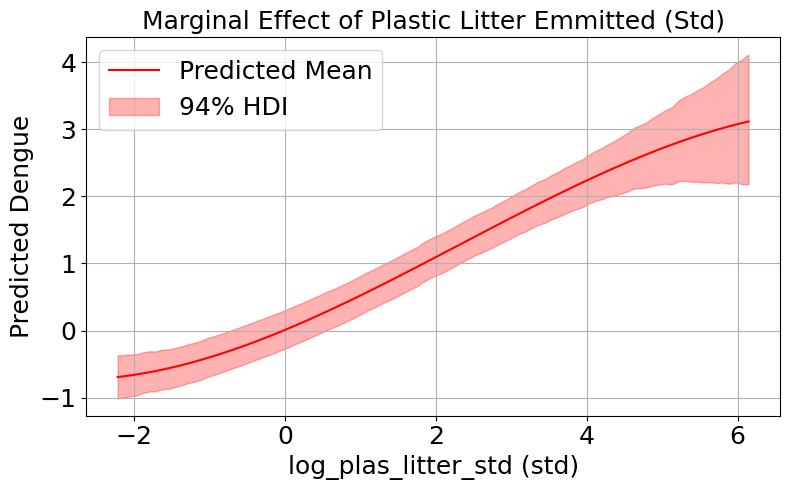

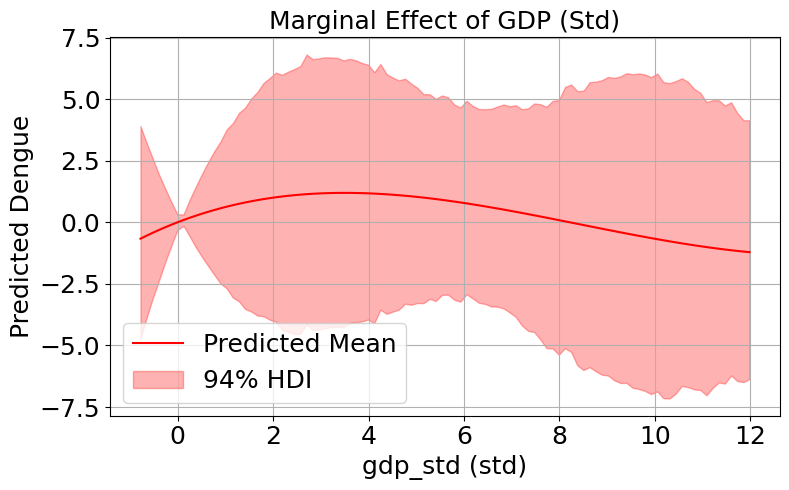

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["log_plas_litter_std", "gdp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std": "Plastic Litter Emmitted (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe with all means
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals  # vary current var
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # known group

    # Predict
    pred = model_plas_litter_gdp_std_spline.predict(idata=idata4B, data=df_pred, kind="response_params", inplace=False)

    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.94)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDI")
    plt.xlabel(f"{var} (std)")
    plt.ylabel("Predicted Dengue")
    plt.title(f"Marginal Effect of {map_names[var]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"4B_marginal_effect_plas_litter_gdp_std{var}.pdf"), format='pdf', dpi=3000)

    plt.show()





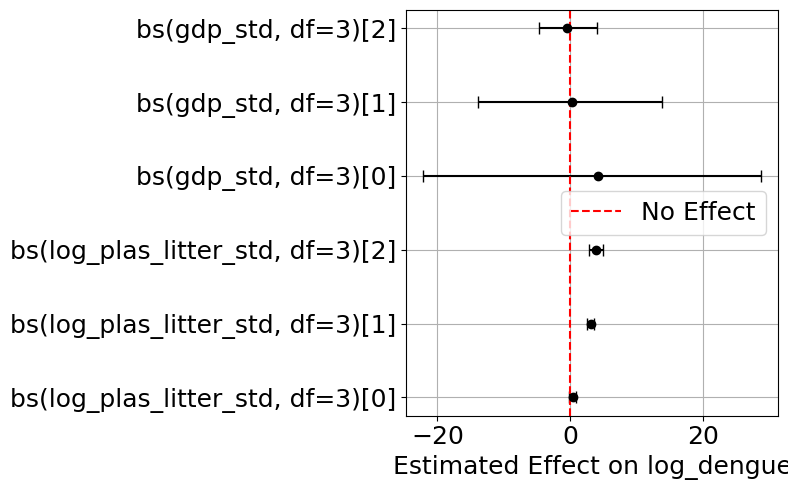

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

readable_names = {
    "bs(log_plas_litter_std, df=3)": "Plastic Ltter Emmitted (std)",
    "bs(gdp_std, df=3)": "GDP (std)"
}

summary = az.summary(
    idata4B,
    var_names=["bs(log_plas_litter_std, df=3)", "bs(gdp_std, df=3)"]
)

means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

plt.figure(figsize=(8, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"4B_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()

# 5A

## **5A pwg_temp_std**

In [ ]:
df_scaled.columns

Index(['adm_0_name', 'adm_1_name', 'adm_2_name', 'gdp', 'ERA5_t2m', 'ERA5_tp',
       'mean_dengue_2014_2023', 'pwg', 'plas_litter_em', 'log_dengue',
       'log_plas_litter', 'pwg_log', 'gdp_std', 'ERA5_t2m_std', 'ERA5_tp_std',
       'pwg_std', 'plas_litter_em_std', 'log_dengue_std',
       'log_plas_litter_std', 'pwg_log_std'],
      dtype='object')

In [ ]:
model_pwg_temp_std = bmb.Model(
    "log_dengue_std  ~ pwg_log_std + ERA5_t2m_std + ERA5_tp_std + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_pwg_temp_std = model_pwg_temp_std.fit(
    draws=2000,
    tune=1000,
    chains = 4,
    idata_kwargs={"log_likelihood": True},
    target_accept=0.98,
    cores = 2)

idata5A = results_pwg_temp_std

Output()

In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata5A = results_pwg_temp_std
"log_likelihood" in idata5A.groups()

True

In [ ]:
az.summary(idata5A, round_to = 4)

mean      sd  hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.2046  0.4081 -0.9742   0.5641   
1|adm_0_name[brazil]                    0.4610  0.4066 -0.3025   1.2228   
1|adm_0_name[china]                     0.4433  0.4332 -0.3522   1.2774   
1|adm_0_name[colombia]                  0.5450  0.4079 -0.1915   1.3393   
1|adm_0_name[costa rica]                0.7502  0.4109  0.0137   1.5497   
1|adm_0_name[pakistan]                 -1.3525  0.4671 -2.2456  -0.5241   
1|adm_0_name[peru]                      0.7575  0.4123 -0.0438   1.5166   
1|adm_0_name[united states of america] -1.4719  0.4232 -2.2797  -0.6805   
1|adm_0_name_sigma                      1.1012  0.3668  0.5490   1.7713   
ERA5_t2m_std                            0.2804  0.0110  0.2598   0.3010   
ERA5_tp_std                            -0.0763  0.0125 -0.1010  -0.0542   
Intercept                              -0.4410  0.4064 -1.2032   0.3209   
pwg_log_std                             0.5294  0.0109  0.5086   0.5493   
sigma                                   0.8069  0.0070  0.7930   0.8195   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0091   0.0064  1997.0208   
1|adm_0_name[brazil]                       0.0092   0.0065  1967.7982   
1|adm_0_name[china]                        0.0091   0.0064  2283.2791   
1|adm_0_name[colombia]                     0.0092   0.0065  1973.5975   
1|adm_0_name[costa rica]                   0.0091   0.0064  2026.1177   
1|adm_0_name[pakistan]                     0.0093   0.0066  2524.9840   
1|adm_0_name[peru]                         0.0092   0.0065  2021.6887   
1|adm_0_name[united states of america]     0.0092   0.0065  2106.5588   
1|adm_0_name_sigma                         0.0077   0.0055  2103.8840   
ERA5_t2m_std                               0.0001   0.0001  7371.9991   
ERA5_tp_std                                0.0001   0.0001  7761.5878   
Intercept                                  0.0091   0.0065  1969.7869   
pwg_log_std                                0.0001   0.0001  7079.1051   
sigma                                      0.0001   0.0001  7039.7358   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 2636.9733  1.0017  
1|adm_0_name[brazil]                    2602.4129  1.0016  
1|adm_0_name[china]                     3408.1466  1.0011  
1|adm_0_name[colombia]                  2537.4240  1.0016  
1|adm_0_name[costa rica]                2961.0017  1.0014  
1|adm_0_name[pakistan]                  3706.7021  1.0008  
1|adm_0_name[peru]                      2707.8463  1.0016  
1|adm_0_name[united states of america]  3178.6337  1.0010  
1|adm_0_name_sigma                      3360.4390  1.0007  
ERA5_t2m_std                            5137.7224  1.0006  
ERA5_tp_std                             5305.6452  1.0007  
Intercept                               2598.5987  1.0016  
pwg_log_std                             5018.9312  1.0002  
sigma                                   5516.4809  1.0010

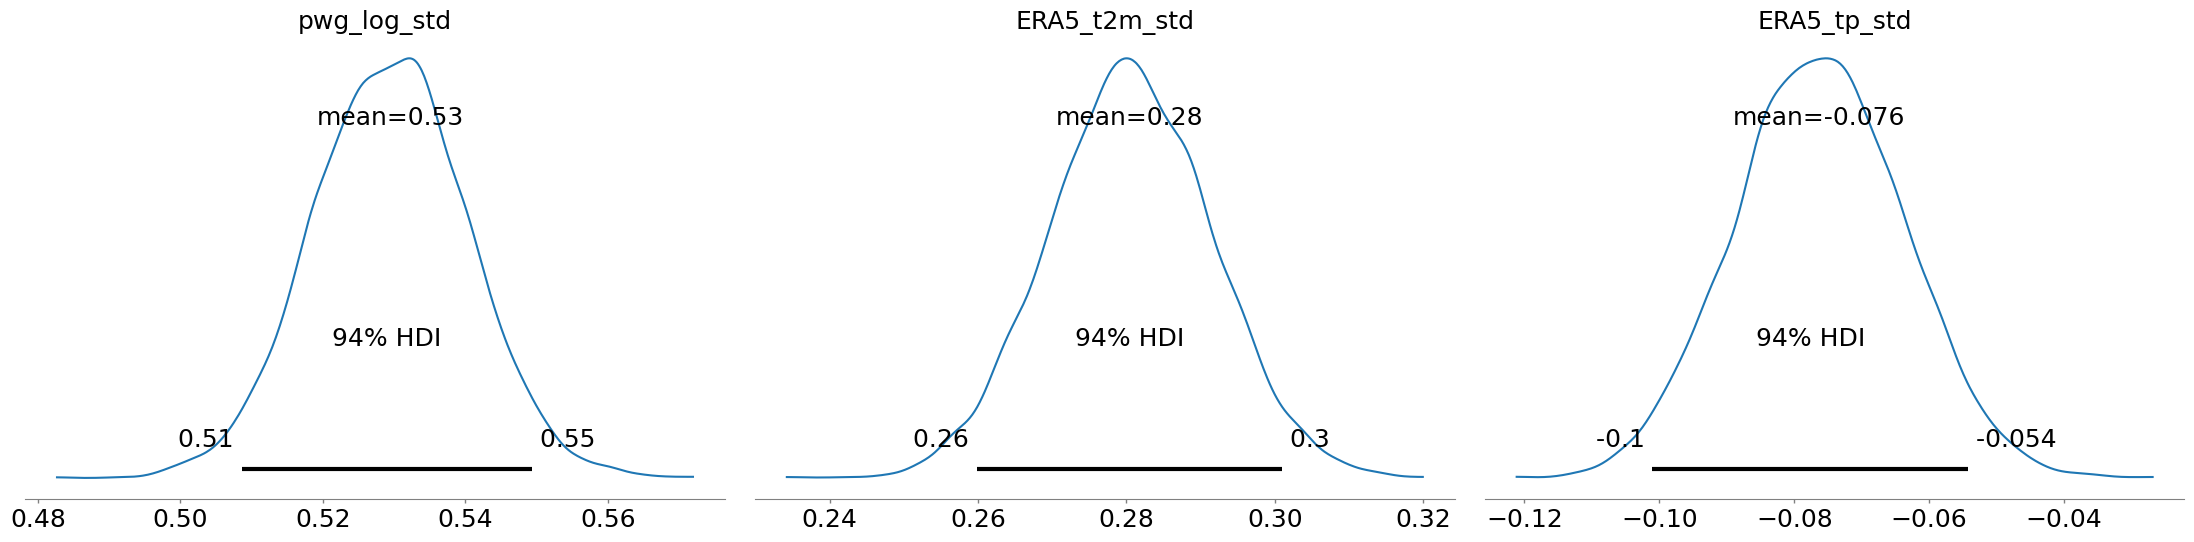

In [ ]:
map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "gdp_std": "GDP (Std)"
}

az.plot_posterior(idata5A, var_names=["pwg_log_std", "ERA5_t2m_std", "ERA5_tp_std", ], hdi_prob=0.94)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"5A_pwg_temp_std_plot_posterior.pdf"), format='pdf', dpi=3000)
plt.show()

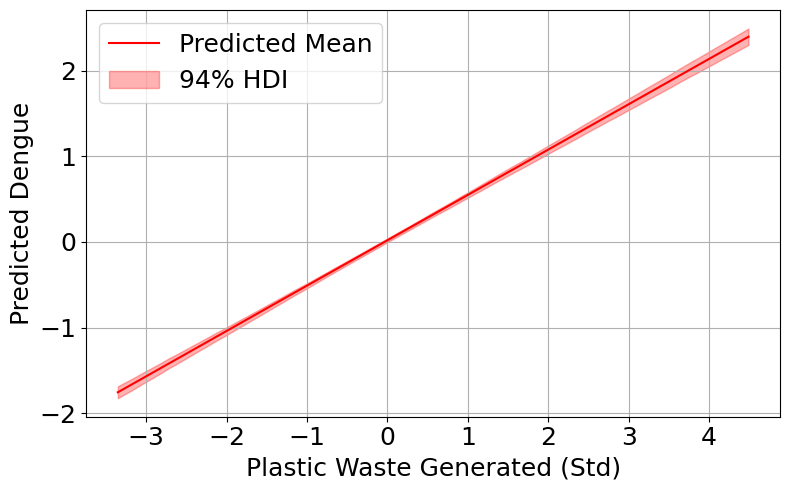

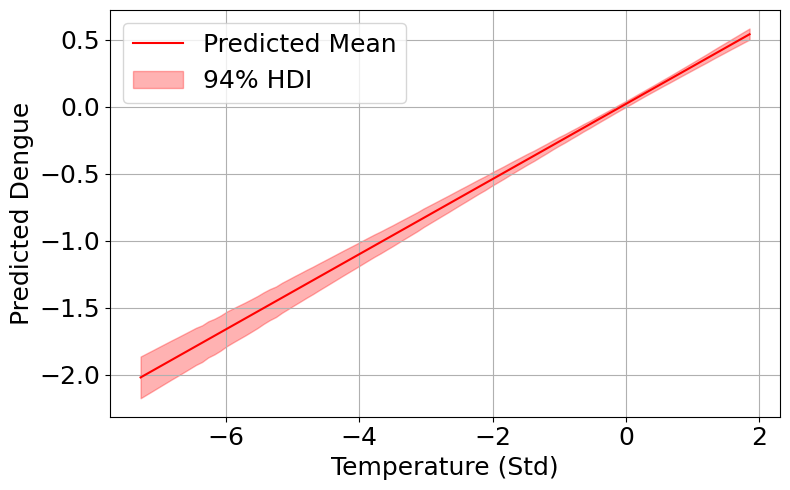

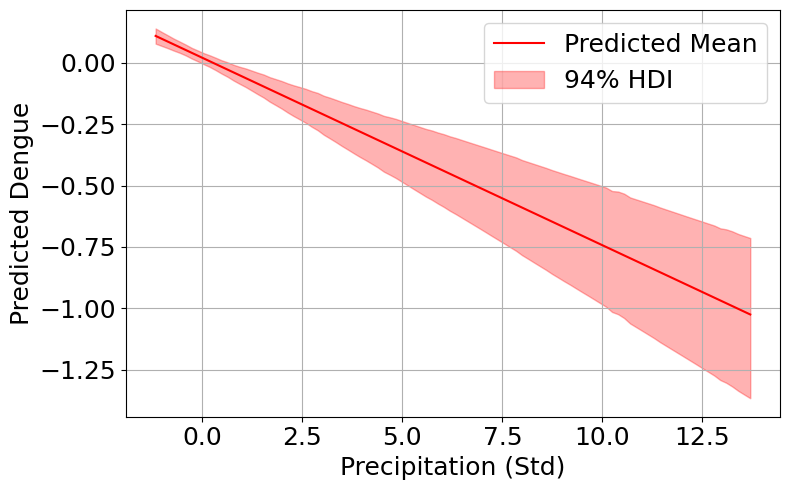

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["pwg_log_std", "ERA5_t2m_std", "ERA5_tp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std" : "Plastic Litter Emissions (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe with all means
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals  # vary current var
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # known group

    # Predict
    pred = model_pwg_temp_std.predict(idata=idata5A, data=df_pred, kind="response_params", inplace=False)

    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.94)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDI")
    plt.xlabel(map_names[var])
    plt.ylabel("Predicted Dengue")
    # plt.title(f"Marginal Effect of {map_names[var]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"5A_marginal_effect_pwg_temp_std{var}.pdf"), format='pdf', dpi=3000)

    plt.show()


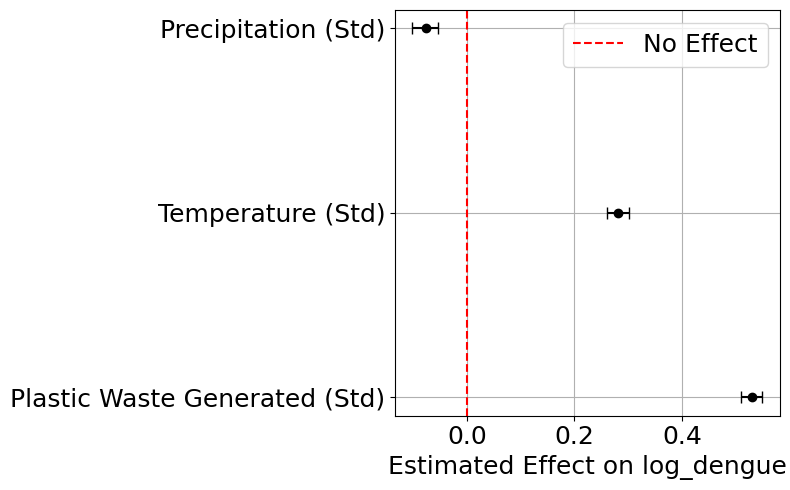

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "gdp_std": "GDP (Std)"
}

summary = az.summary(
    idata5A,
    var_names=["pwg_log_std", "ERA5_t2m_std", "ERA5_tp_std" ]
)
summary.index = [map_names.get(var, var) for var in summary.index]

means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

plt.figure(figsize=(8, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"5A_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()

# 5B_pwg_temp_splines

In [ ]:
model_pwg_temp_std_spliness = bmb.Model(
    "log_dengue_std  ~  bs(pwg_log_std, df = 3) +  bs(ERA5_t2m_std, df = 3)
    + bs(ERA5_tp_std, df = 3) + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_pwg_temp_std_spliness = model_pwg_temp_std_spliness.fit(
    draws=2000,
    tune=1000,
    chains = 4,
    idata_kwargs={"log_likelihood": True},
    target_accept=0.99,
    max_treedepth= 30,
    cores = 2)

idata5Bss = results_pwg_temp_std_spliness

Output()

In [ ]:
model_pwg_temp_std_spline = bmb.Model(
    "log_dengue_std  ~  bs(pwg_log_std, df = 3) +  bs(ERA5_t2m_std, df = 3) + bs(ERA5_tp_std, df = 3) + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_pwg_temp_std_spline = model_pwg_temp_std_spline.fit(
    draws=2000,
    tune=1000,
    chains = 4,
    idata_kwargs={"log_likelihood": True},
    target_accept=0.98,
    cores = 2)

idata5B = results_pwg_temp_std_spline

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata5B = results_pwg_temp_std_spline
"log_likelihood" in idata5B.groups()

True

In [ ]:
az.summary(idata5Bss, round_to = 4)


mean      sd   hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                  0.1116  0.6586  -1.1467   1.3177   
1|adm_0_name[brazil]                     0.6012  0.6579  -0.6242   1.8381   
1|adm_0_name[china]                      0.1165  0.6742  -1.0904   1.4162   
1|adm_0_name[colombia]                   1.1070  0.6585  -0.0577   2.4052   
1|adm_0_name[costa rica]                 1.1062  0.6618  -0.1095   2.3517   
1|adm_0_name[pakistan]                  -2.5594  0.6935  -3.8005  -1.1964   
1|adm_0_name[peru]                       1.3580  0.6618   0.1359   2.5979   
1|adm_0_name[united states of america]  -1.7102  0.6675  -2.9263  -0.4275   
1|adm_0_name_sigma                       1.7882  0.6622   0.8937   3.0008   
Intercept                                5.4688  0.8895   3.7241   7.0894   
bs(ERA5_t2m_std, df=3)[0]              -16.3866  0.8775 -17.9987 -14.7222   
bs(ERA5_t2m_std, df=3)[1]               -0.9279  0.4977  -1.9105  -0.0446   
bs(ERA5_t2m_std, df=3)[2]               -6.3345  0.5948  -7.4063  -5.1866   
bs(ERA5_tp_std, df=3)[0]                -1.7879  0.1821  -2.1342  -1.4523   
bs(ERA5_tp_std, df=3)[1]                -0.2019  0.3724  -0.9256   0.4804   
bs(ERA5_tp_std, df=3)[2]                -0.5230  0.3678  -1.2392   0.1381   
bs(pwg_log_std, df=3)[0]                -2.6488  0.4359  -3.4817  -1.8542   
bs(pwg_log_std, df=3)[1]                 1.5268  0.1457   1.2543   1.8039   
bs(pwg_log_std, df=3)[2]                 2.6803  0.3698   1.9905   3.3588   
sigma                                    0.7291  0.0064   0.7161   0.7408   

                                        mcse_mean  mcse_sd    ess_bulk  \
1|adm_0_name[argentina]                    0.0146   0.0103   2100.2641   
1|adm_0_name[brazil]                       0.0146   0.0103   2092.6807   
1|adm_0_name[china]                        0.0147   0.0104   2174.0943   
1|adm_0_name[colombia]                     0.0146   0.0103   2101.6815   
1|adm_0_name[costa rica]                   0.0145   0.0103   2135.8389   
1|adm_0_name[pakistan]                     0.0148   0.0104   2274.2722   
1|adm_0_name[peru]                         0.0146   0.0103   2145.7057   
1|adm_0_name[united states of america]     0.0146   0.0103   2155.1815   
1|adm_0_name_sigma                         0.0139   0.0098   2235.3354   
Intercept                                  0.0161   0.0114   3082.6345   
bs(ERA5_t2m_std, df=3)[0]                  0.0122   0.0086   5184.4289   
bs(ERA5_t2m_std, df=3)[1]                  0.0068   0.0048   5378.3269   
bs(ERA5_t2m_std, df=3)[2]                  0.0083   0.0059   5177.1360   
bs(ERA5_tp_std, df=3)[0]                   0.0020   0.0014   8584.6056   
bs(ERA5_tp_std, df=3)[1]                   0.0042   0.0034   7985.7297   
bs(ERA5_tp_std, df=3)[2]                   0.0039   0.0031   8773.0712   
bs(pwg_log_std, df=3)[0]                   0.0053   0.0037   6866.1011   
bs(pwg_log_std, df=3)[1]                   0.0016   0.0012   8109.2907   
bs(pwg_log_std, df=3)[2]                   0.0047   0.0034   6197.3196   
sigma                                      0.0001   0.0000  10392.3924   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 2613.6695  1.0012  
1|adm_0_name[brazil]                    2533.5318  1.0011  
1|adm_0_name[china]                     2815.2375  1.0013  
1|adm_0_name[colombia]                  2508.4841  1.0013  
1|adm_0_name[costa rica]                2664.6709  1.0012  
1|adm_0_name[pakistan]                  3106.4164  1.0007  
1|adm_0_name[peru]                      2638.6950  1.0012  
1|adm_0_name[united states of america]  2655.3340  1.0012  
1|adm_0_name_sigma                      3295.4148  1.0009  
Intercept                               3734.2707  1.0006  
bs(ERA5_t2m_std, df=3)[0]               4845.4689  1.0010  
bs(ERA5_t2m_std, df=3)[1]               5169.1308  1.0005  
bs(ERA5_t2m_std, df=3)[2]               4824.4003  1.0009  
bs(ERA5_tp_std, df=3)[0]      

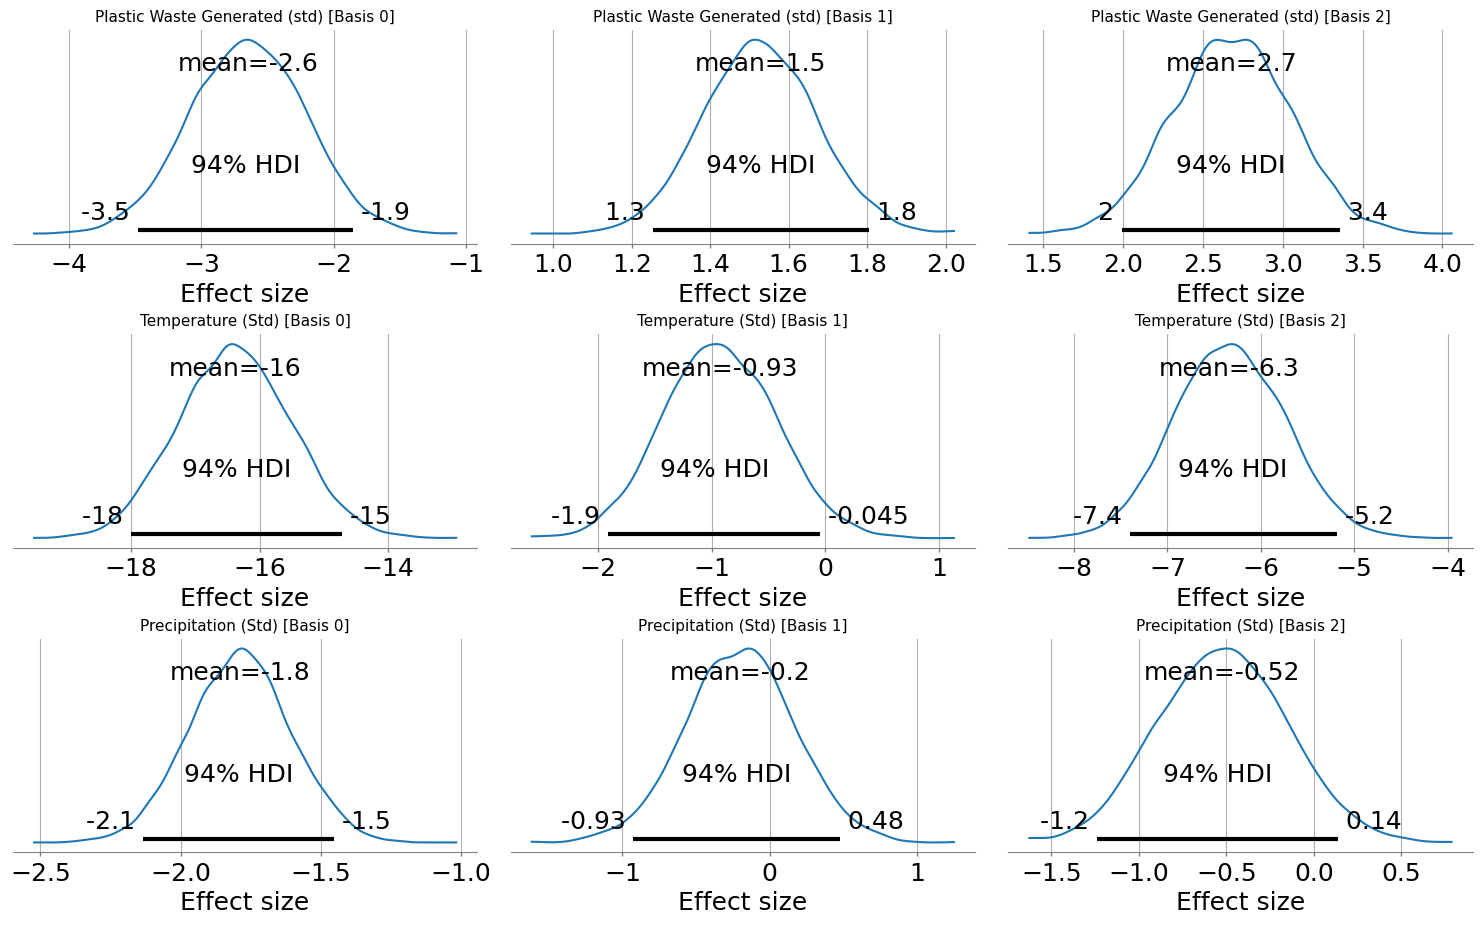

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import os

# Each variable and how many basis terms it has
spline_vars = {
    "bs(pwg_log_std, df=3)": 3,
    "bs(ERA5_t2m_std, df=3)" : 3,
    "bs(ERA5_tp_std, df=3)": 3

}
readable_names = {
    "bs(pwg_log_std, df=3)": "Plastic Waste Generated (std)",
    "bs(gdp_std, df=3)": "GDP (std)",
    "bs(ERA5_t2m_std, df=3)": "Temperature (Std)",
    "bs(ERA5_tp_std, df=3)": "Precipitation (Std)"

}
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 9 slots for 9 plots

axes = axes.flatten()

i = 0
for var, n_basis in spline_vars.items():
    for j in range(n_basis):
        az.plot_posterior(
            idata5Bss,
            var_names=[var],
            coords={f"{var}_dim": [j]},
            hdi_prob=0.94,
            point_estimate="mean",
            ax=axes[i]
        )
        axes[i].set_title(f"{readable_names[var]} [Basis {j}]", fontsize=11)
        axes[i].set_xlabel("Effect size")
        axes[i].grid(True)
        i += 1

# plt.suptitle("Posterior Distributions of Spline Terms", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(os.path.join(image_folder, "5B_spline_posterior_subplot.pdf"), format="pdf", dpi=3000)
plt.show()


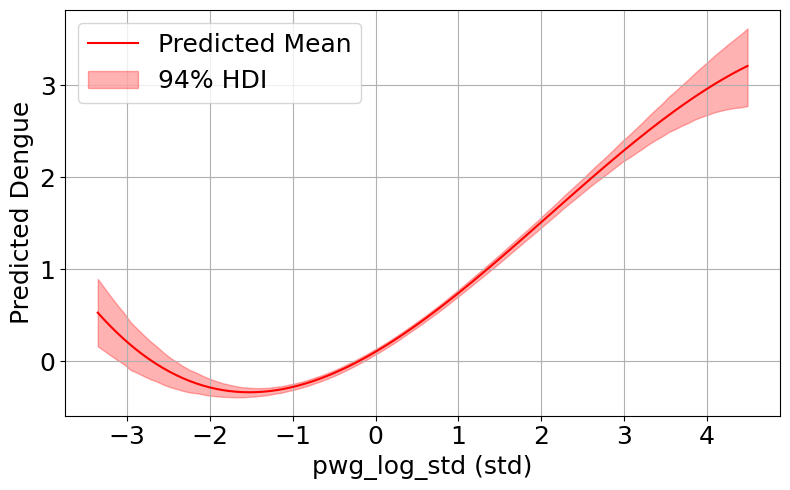

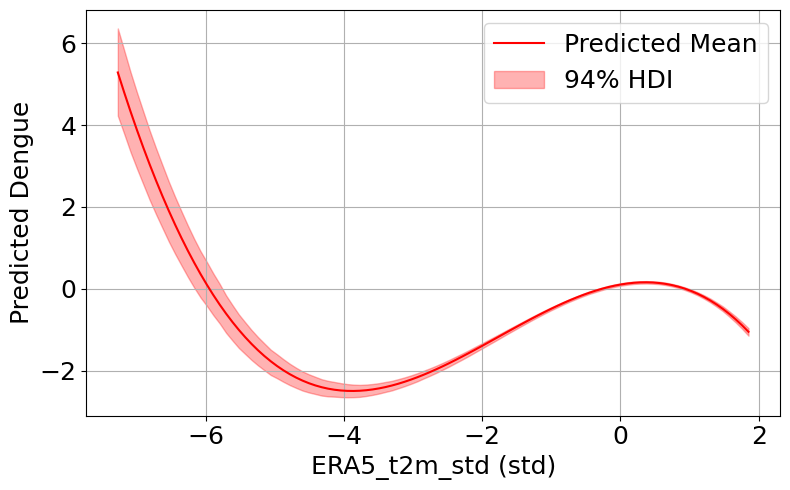

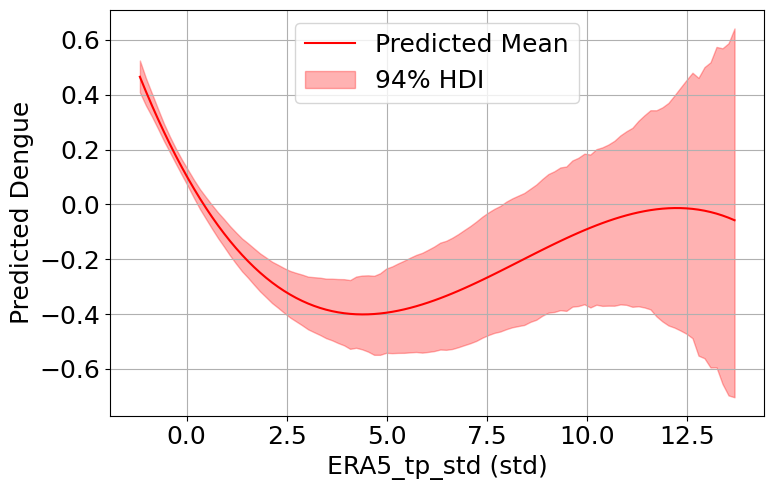

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["pwg_log_std", "ERA5_t2m_std", "ERA5_tp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std": "Plastic Litter Emmitted (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe with all means
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals  # vary current var
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # known group

    # Predict
    pred = model_pwg_temp_std_spliness.predict(idata=idata5Bss, data=df_pred, kind="response_params", inplace=False)

    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.94)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDI")
    plt.xlabel(f"{var} (std)")
    plt.ylabel("Predicted Dengue")
    # plt.title(f"Marginal Effect of {map_names[var]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"5B_marginal_effect_pwg_log_std_std{var}.pdf"), format='pdf', dpi=3000)

    plt.show()


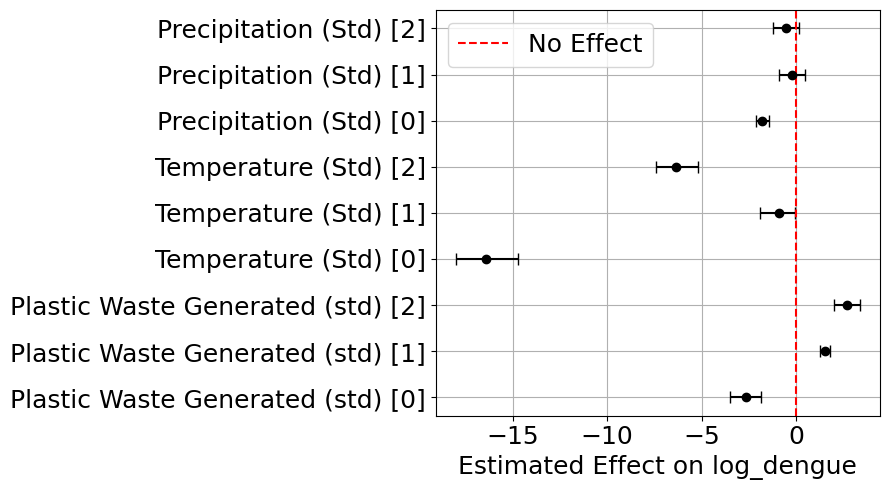

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
readable_names = {
    "bs(pwg_log_std, df=3)": "Plastic Waste Generated (std)",
    "bs(gdp_std, df=3)": "GDP (std)",
    "bs(ERA5_t2m_std, df=3)": "Temperature (Std)",
    "bs(ERA5_tp_std, df=3)": "Precipitation (Std)"
}
summary = az.summary(
    idata5Bss,
    var_names=["bs(pwg_log_std, df=3)", "bs(ERA5_t2m_std, df=3)", "bs(ERA5_tp_std, df=3)" ]
)
new_index = []
for var in summary.index:
    # Match spline var name (e.g., "bs(pwg_log_std, df=3)[0]") to key
    base_name = var.split("[")[0]
    idx = var.split("[")[1].rstrip("]") if "[" in var else ""
    label = f"{readable_names.get(base_name, base_name)} [{idx}]"
    new_index.append(label)

summary.index = new_index
means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

plt.figure(figsize=(9, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"5B_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()

# 6A_plas_litter_temp_std

In [ ]:
model_plas_litter_temp_std = bmb.Model(
    "log_dengue_std  ~ log_plas_litter_std + ERA5_t2m_std + ERA5_tp_std + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_plas_litter_temp_std = model_plas_litter_temp_std.fit(
    draws=2000,
    tune=1000,
    idata_kwargs={"log_likelihood": True},
    chains = 4,
    target_accept=0.98,
    cores = 2)

idata6A = results_plas_litter_temp_std

Output()

In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata6A = results_plas_litter_temp_std
"log_likelihood" in idata6A.groups()

True

In [ ]:
az.summary(idata6A, round_to = 4)

mean      sd  hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.1705  0.4451 -1.0491   0.6701   
1|adm_0_name[brazil]                    0.5264  0.4427 -0.3514   1.3631   
1|adm_0_name[china]                     0.5700  0.4723 -0.3504   1.4607   
1|adm_0_name[colombia]                  0.6128  0.4446 -0.3116   1.4095   
1|adm_0_name[costa rica]                0.9561  0.4506  0.1094   1.8313   
1|adm_0_name[pakistan]                 -2.1239  0.5124 -3.1109  -1.1515   
1|adm_0_name[peru]                      0.4913  0.4485 -0.4119   1.3258   
1|adm_0_name[united states of america] -0.8783  0.4580 -1.7745  -0.0066   
1|adm_0_name_sigma                      1.2328  0.4029  0.6144   1.9442   
ERA5_t2m_std                            0.2567  0.0121  0.2346   0.2796   
ERA5_tp_std                            -0.0773  0.0135 -0.1023  -0.0517   
Intercept                              -0.5029  0.4426 -1.3364   0.3767   
log_plas_litter_std                     0.4569  0.0118  0.4343   0.4783   
sigma                                   0.8530  0.0076  0.8385   0.8669   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0106   0.0075  1764.8793   
1|adm_0_name[brazil]                       0.0106   0.0075  1742.1327   
1|adm_0_name[china]                        0.0108   0.0077  1910.4597   
1|adm_0_name[colombia]                     0.0107   0.0075  1743.4041   
1|adm_0_name[costa rica]                   0.0107   0.0076  1775.1964   
1|adm_0_name[pakistan]                     0.0108   0.0078  2277.4457   
1|adm_0_name[peru]                         0.0106   0.0075  1794.0770   
1|adm_0_name[united states of america]     0.0107   0.0076  1840.0660   
1|adm_0_name_sigma                         0.0088   0.0062  2054.5276   
ERA5_t2m_std                               0.0001   0.0001  7310.5395   
ERA5_tp_std                                0.0002   0.0001  6773.0869   
Intercept                                  0.0106   0.0075  1742.6771   
log_plas_litter_std                        0.0001   0.0001  7467.2824   
sigma                                      0.0001   0.0001  7705.0840   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 2380.1992  1.0037  
1|adm_0_name[brazil]                    2259.8115  1.0037  
1|adm_0_name[china]                     2722.4665  1.0031  
1|adm_0_name[colombia]                  2286.6218  1.0037  
1|adm_0_name[costa rica]                2479.8248  1.0038  
1|adm_0_name[pakistan]                  3119.4296  1.0034  
1|adm_0_name[peru]                      2477.3939  1.0036  
1|adm_0_name[united states of america]  2684.6925  1.0034  
1|adm_0_name_sigma                      3537.5815  1.0021  
ERA5_t2m_std                            4907.4515  1.0003  
ERA5_tp_std                             5330.5003  0.9999  
Intercept                               2251.9192  1.0037  
log_plas_litter_std                     5398.6066  1.0008  
sigma                                   5058.9801  1.0002

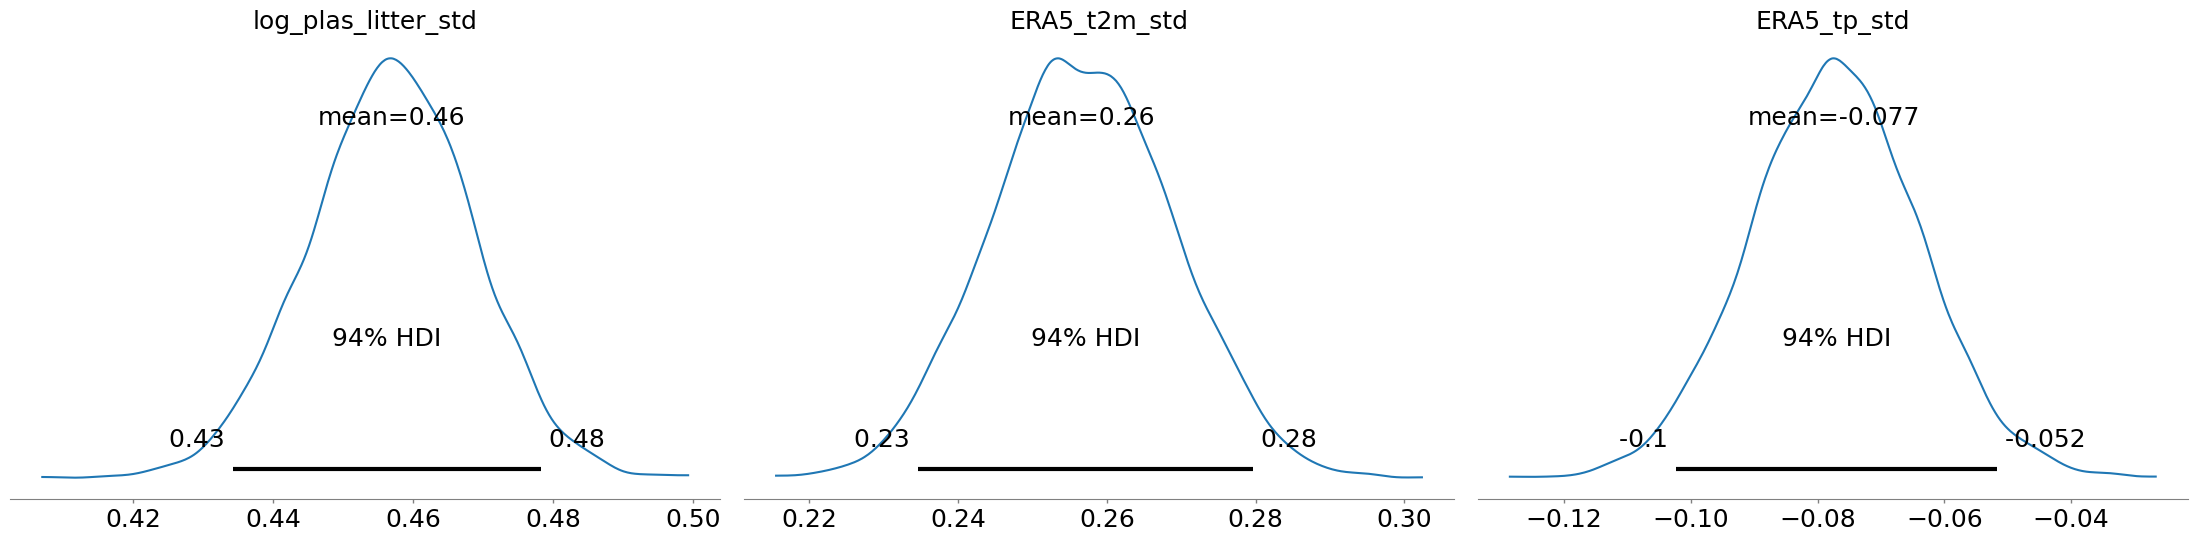

In [ ]:
map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std": "Plastic Litter Emmissions (Std)",
    "gdp_std": "GDP (Std)"
}

az.plot_posterior(idata6A, var_names=["log_plas_litter_std", "ERA5_t2m_std", "ERA5_tp_std", ], hdi_prob=0.94)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"6A_pwg_temp_std_plot_posterior.pdf"), format='pdf', dpi=3000)
plt.show()

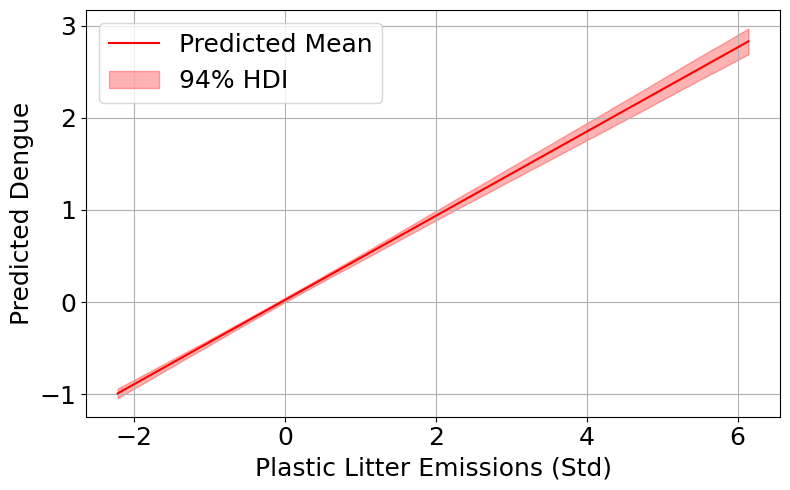

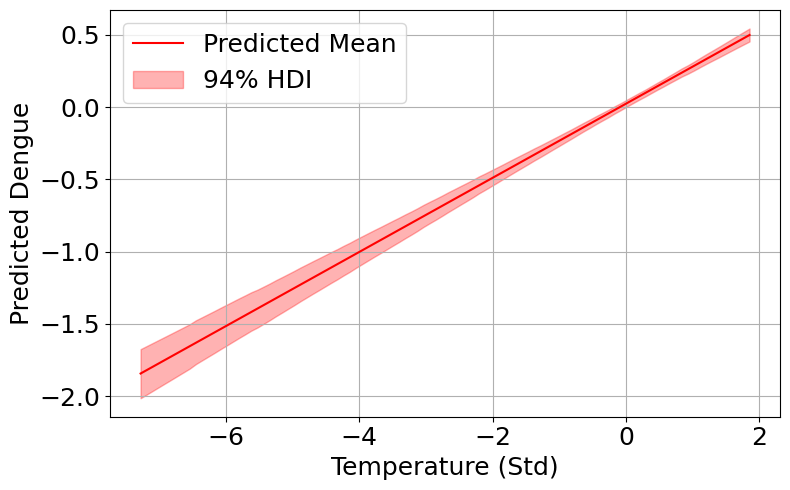

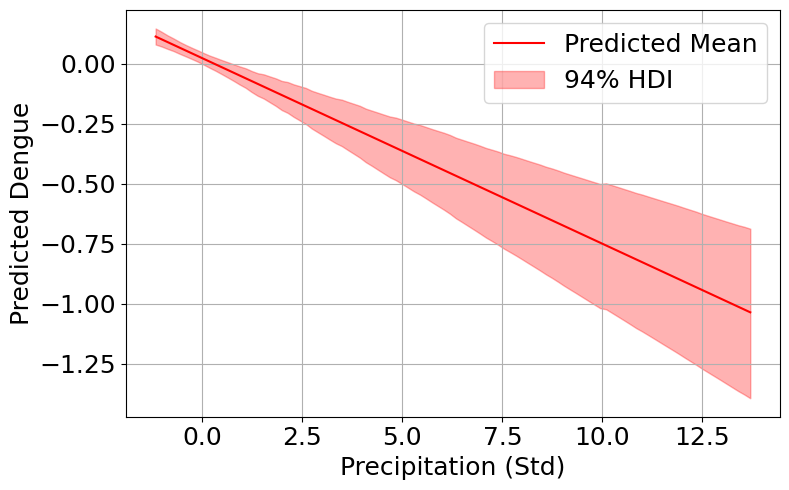

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["log_plas_litter_std", "ERA5_t2m_std", "ERA5_tp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std" : "Plastic Litter Emissions (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe with all means
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals  # vary current var
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # known group

    # Predict
    pred = model_plas_litter_temp_std.predict(idata=idata6A, data=df_pred, kind="response_params", inplace=False)

    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.94)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDI")
    plt.xlabel(map_names[var])
    plt.ylabel("Predicted Dengue")
    # plt.title(f"Marginal Effect of {map_names[var]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"6A_marginal_effect_pwg_temp_std{var}.pdf"), format='pdf', dpi=3000)

    plt.show()


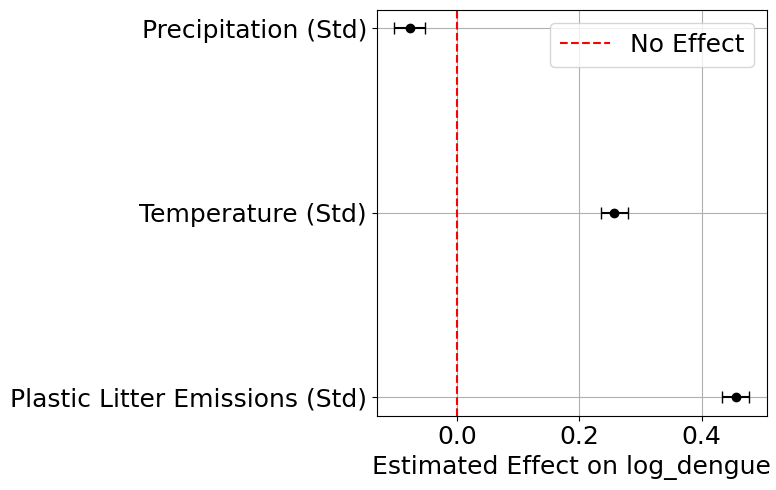

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std" : "Plastic Litter Emissions (Std)",
    "gdp_std": "GDP (Std)"
}

summary = az.summary(
    idata6A,
    var_names=["log_plas_litter_std", "ERA5_t2m_std", "ERA5_tp_std" ]
)
summary.index = [map_names.get(var, var) for var in summary.index]

means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

plt.figure(figsize=(8, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"6A_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()

## 6B_plas_litter_temp_splines

In [ ]:
model_plas_litter_temp_std_spline = bmb.Model(
    "log_dengue_std  ~  bs(log_plas_litter_std, df = 3) +  bs(ERA5_t2m_std, df = 3) + bs(ERA5_tp_std, df = 3) + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_plas_litter_temp_std_spline = model_plas_litter_temp_std_spline.fit(
    draws=2000,
    tune=1000,
    chains = 4,
    idata_kwargs={"log_likelihood": True},
    target_accept=0.98,
    cores = 2)

idata6B = results_plas_litter_temp_std_spline

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata6B = results_plas_litter_temp_std_spline
"log_likelihood" in idata6B.groups()

True

In [ ]:
az.summary(idata6B, round_to = 4)


mean      sd   hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                  0.0897  0.7080  -1.2596   1.4526   
1|adm_0_name[brazil]                     0.6113  0.7065  -0.6133   2.0936   
1|adm_0_name[china]                      0.2768  0.7172  -1.0540   1.6874   
1|adm_0_name[colombia]                   1.1707  0.7067  -0.0923   2.6169   
1|adm_0_name[costa rica]                 1.2381  0.7134  -0.1889   2.5319   
1|adm_0_name[pakistan]                  -3.3904  0.7625  -4.7742  -1.9153   
1|adm_0_name[peru]                       0.9829  0.7092  -0.3396   2.3633   
1|adm_0_name[united states of america]  -0.9908  0.7158  -2.3058   0.4260   
1|adm_0_name_sigma                       1.9011  0.6681   0.9734   3.1635   
Intercept                                4.4988  0.9296   2.6756   6.2070   
bs(ERA5_t2m_std, df=3)[0]              -16.5831  0.9442 -18.3557 -14.8487   
bs(ERA5_t2m_std, df=3)[1]               -0.5671  0.5355  -1.5627   0.4426   
bs(ERA5_t2m_std, df=3)[2]               -6.4634  0.6413  -7.6367  -5.2501   
bs(ERA5_tp_std, df=3)[0]                -1.7276  0.1985  -2.1122  -1.3669   
bs(ERA5_tp_std, df=3)[1]                -0.6732  0.4049  -1.4088   0.0919   
bs(ERA5_tp_std, df=3)[2]                -0.2594  0.3940  -1.0044   0.4827   
bs(log_plas_litter_std, df=3)[0]        -0.0317  0.2373  -0.4700   0.4109   
bs(log_plas_litter_std, df=3)[1]         3.2072  0.2543   2.7284   3.6782   
bs(log_plas_litter_std, df=3)[2]         3.6722  0.4701   2.8213   4.5576   
sigma                                    0.7787  0.0070   0.7657   0.7921   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0158   0.0112  1994.1758   
1|adm_0_name[brazil]                       0.0158   0.0112  1991.6506   
1|adm_0_name[china]                        0.0159   0.0112  2042.5807   
1|adm_0_name[colombia]                     0.0158   0.0112  1999.2174   
1|adm_0_name[costa rica]                   0.0159   0.0112  2015.3789   
1|adm_0_name[pakistan]                     0.0164   0.0116  2179.9305   
1|adm_0_name[peru]                         0.0159   0.0112  2001.2398   
1|adm_0_name[united states of america]     0.0160   0.0113  1992.6078   
1|adm_0_name_sigma                         0.0136   0.0096  2351.1859   
Intercept                                  0.0192   0.0136  2336.8341   
bs(ERA5_t2m_std, df=3)[0]                  0.0139   0.0099  4605.3655   
bs(ERA5_t2m_std, df=3)[1]                  0.0078   0.0060  4762.9271   
bs(ERA5_t2m_std, df=3)[2]                  0.0095   0.0068  4545.9796   
bs(ERA5_tp_std, df=3)[0]                   0.0025   0.0018  6489.0749   
bs(ERA5_tp_std, df=3)[1]                   0.0051   0.0036  6214.7739   
bs(ERA5_tp_std, df=3)[2]                   0.0048   0.0037  6744.1504   
bs(log_plas_litter_std, df=3)[0]           0.0032   0.0025  5506.0385   
bs(log_plas_litter_std, df=3)[1]           0.0036   0.0026  4923.0974   
bs(log_plas_litter_std, df=3)[2]           0.0066   0.0047  5056.6912   
sigma                                      0.0001   0.0001  8923.3489   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 3102.9453  1.0012  
1|adm_0_name[brazil]                    3073.1647  1.0011  
1|adm_0_name[china]                     3102.6861  1.0010  
1|adm_0_name[colombia]                  3019.2524  1.0012  
1|adm_0_name[costa rica]                3028.1498  1.0011  
1|adm_0_name[pakistan]                  3441.9256  1.0007  
1|adm_0_name[peru]                      3122.7885  1.0013  
1|adm_0_name[united states of america]  3207.4453  1.0014  
1|adm_0_name_sigma                      3437.3171  1.0011  
Intercept                               3583.5941  1.0015  
bs(ERA5_t2m_std, df=3)[0]               4444.0414  1.0002  
bs(ERA5_t2m_std, df=3)[1]               4438.8999  1.0003  
bs(ERA5_t2m_std, df=3)[2]               4003.1465  1.0003  
bs(ERA5_tp_std, df=3)[0]                5603.7632  

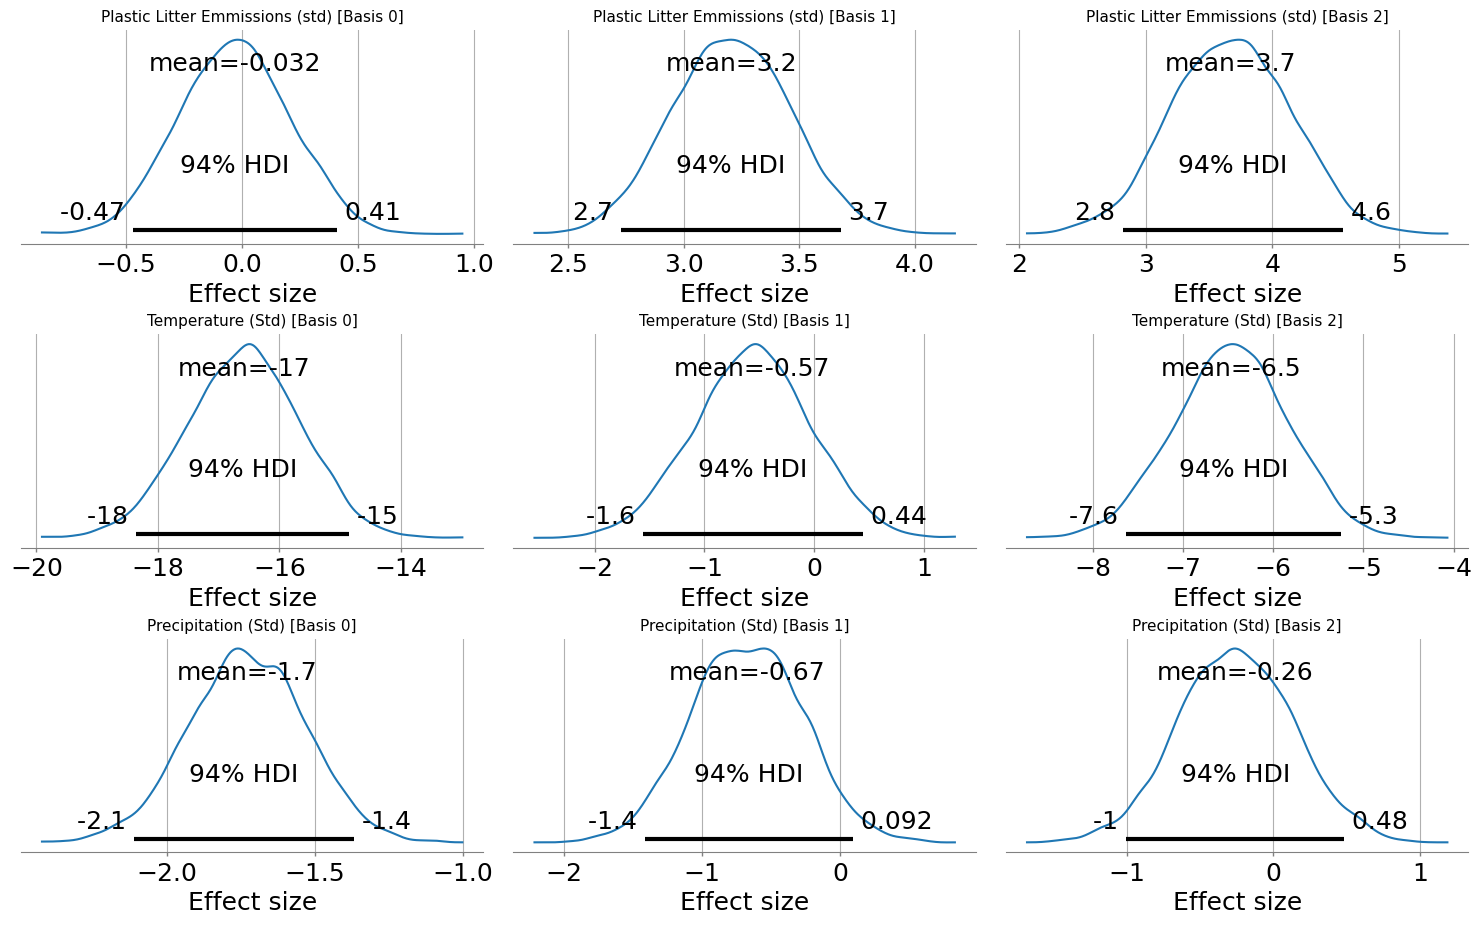

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import os

# Each variable and how many basis terms it has
spline_vars = {
    "bs(log_plas_litter_std, df=3)": 3,
    "bs(ERA5_t2m_std, df=3)" : 3,
    "bs(ERA5_tp_std, df=3)": 3

}
readable_names = {
    "bs(pwg_log_std, df=3)": "Plastic Waste Generated (std)",
    "bs(log_plas_litter_std, df=3)": "Plastic Litter Emmissions (std)",

    "bs(gdp_std, df=3)": "GDP (std)",
    "bs(ERA5_t2m_std, df=3)": "Temperature (Std)",
    "bs(ERA5_tp_std, df=3)": "Precipitation (Std)"

}
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 9 slots for 9 plots

axes = axes.flatten()

i = 0
for var, n_basis in spline_vars.items():
    for j in range(n_basis):
        az.plot_posterior(
            idata6B,
            var_names=[var],
            coords={f"{var}_dim": [j]},
            hdi_prob=0.94,
            point_estimate="mean",
            ax=axes[i]
        )
        axes[i].set_title(f"{readable_names[var]} [Basis {j}]", fontsize=11)
        axes[i].set_xlabel("Effect size")
        axes[i].grid(True)
        i += 1

# plt.suptitle("Posterior Distributions of Spline Terms", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(os.path.join(image_folder, "6B_spline_posterior_subplot.pdf"), format="pdf", dpi=3000)
plt.show()


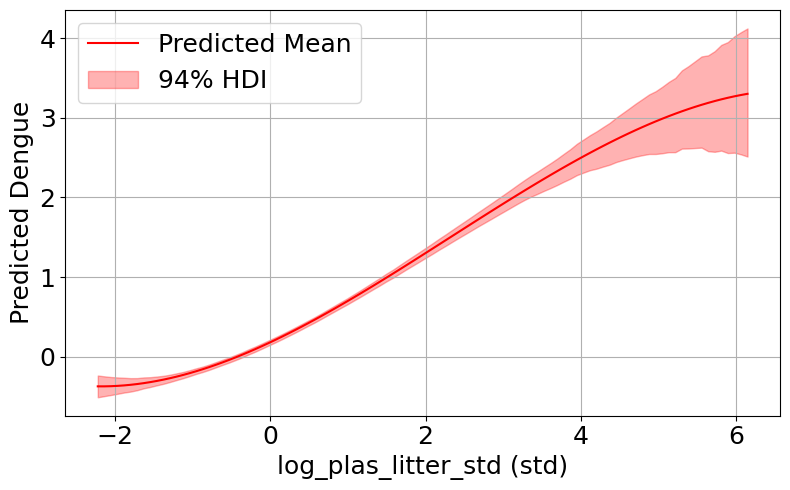

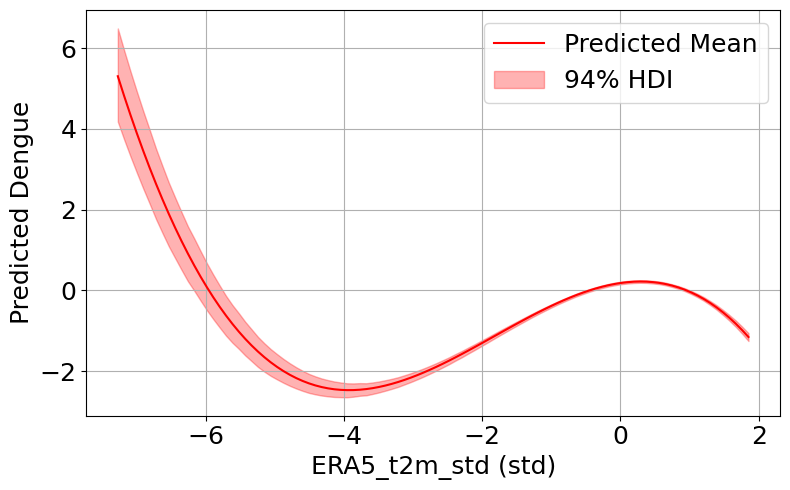

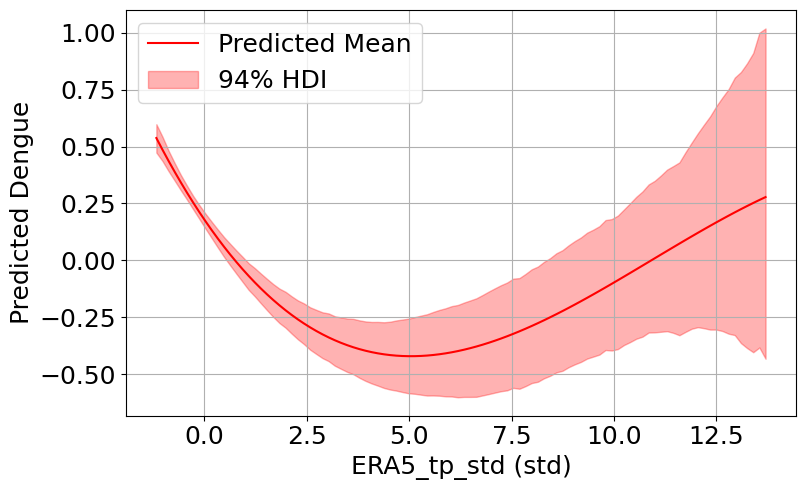

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["log_plas_litter_std", "ERA5_t2m_std", "ERA5_tp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std": "Plastic Litter Emmitted (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe with all means
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals  # vary current var
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # known group

    # Predict
    pred = model_plas_litter_temp_std_spline.predict(idata=idata6B, data=df_pred, kind="response_params", inplace=False)

    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.94)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDI")
    plt.xlabel(f"{var} (std)")
    plt.ylabel("Predicted Dengue")
    # plt.title(f"Marginal Effect of {map_names[var]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"6B_marginal_effect_pwg_log_std_std{var}.pdf"), format='pdf', dpi=3000)

    plt.show()


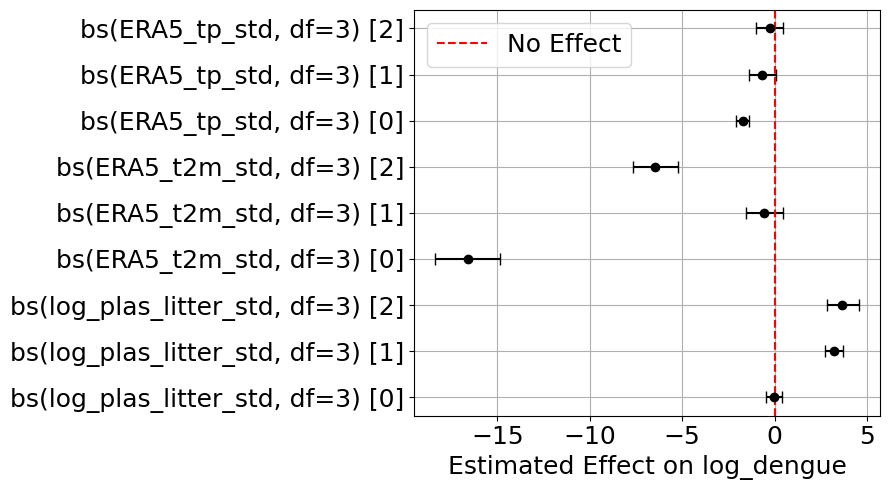

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

readable_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std": "Plastic Litter Emmitted (Std)",
    "gdp_std": "GDP (Std)"
}
summary = az.summary(
    idata6B,
    var_names=["bs(log_plas_litter_std, df=3)", "bs(ERA5_t2m_std, df=3)", "bs(ERA5_tp_std, df=3)" ]
)
new_index = []
for var in summary.index:
    # Match spline var name (e.g., "bs(pwg_log_std, df=3)[0]") to key
    base_name = var.split("[")[0]
    idx = var.split("[")[1].rstrip("]") if "[" in var else ""
    label = f"{readable_names.get(base_name, base_name)} [{idx}]"
    new_index.append(label)

summary.index = new_index
means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

plt.figure(figsize=(9, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"6B_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()

## **7A pwg_temp_gdp_std**

In [ ]:
model_pwg_all_std = bmb.Model(
    "log_dengue_std  ~ pwg_log_std + ERA5_t2m_std + ERA5_tp_std + gdp_std + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_pwg_all_std = model_pwg_all_std.fit(
    draws=2000,
    tune=1000,
    idata_kwargs={"log_likelihood": True},
    chains = 4,
    target_accept=0.98,
    cores = 2
    )

Output()

In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata7A = results_pwg_all_std
"log_likelihood" in idata7A.groups()

True

In [ ]:
idata7A = results_pwg_all_std

az.summary(idata7A, round_to = 4)

mean      sd  hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.4513  0.4669 -1.3695   0.4024   
1|adm_0_name[brazil]                    0.2722  0.4414 -0.5632   1.1060   
1|adm_0_name[china]                     0.9375  0.6747 -0.3062   2.2101   
1|adm_0_name[colombia]                  0.2912  0.4682 -0.6253   1.1519   
1|adm_0_name[costa rica]                0.4891  0.4803 -0.4501   1.3683   
1|adm_0_name[pakistan]                 -1.5812  0.5189 -2.5605  -0.6146   
1|adm_0_name[peru]                      0.4996  0.4716 -0.3868   1.4036   
1|adm_0_name[united states of america] -0.6142  0.9575 -2.5230   1.1323   
1|adm_0_name_sigma                      1.0958  0.4114  0.5236   1.8287   
ERA5_t2m_std                            0.2806  0.0116  0.2584   0.3021   
ERA5_tp_std                            -0.0759  0.0126 -0.0994  -0.0524   
Intercept                              -0.2460  0.4433 -1.0762   0.6012   
gdp_std                                -0.0892  0.0872 -0.2540   0.0789   
pwg_log_std                             0.5296  0.0108  0.5099   0.5509   
sigma                                   0.8067  0.0070  0.7932   0.8194   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0112   0.0080  1738.6935   
1|adm_0_name[brazil]                       0.0104   0.0074  1789.9527   
1|adm_0_name[china]                        0.0110   0.0083  4069.0079   
1|adm_0_name[colombia]                     0.0112   0.0079  1741.0241   
1|adm_0_name[costa rica]                   0.0115   0.0081  1752.8106   
1|adm_0_name[pakistan]                     0.0112   0.0082  2222.4103   
1|adm_0_name[peru]                         0.0113   0.0080  1743.3799   
1|adm_0_name[united states of america]     0.0160   0.0132  3838.2081   
1|adm_0_name_sigma                         0.0091   0.0065  1961.7439   
ERA5_t2m_std                               0.0001   0.0001  9539.5969   
ERA5_tp_std                                0.0001   0.0001  8541.7004   
Intercept                                  0.0105   0.0074  1777.3168   
gdp_std                                    0.0017   0.0012  2741.7886   
pwg_log_std                                0.0001   0.0001  8519.2692   
sigma                                      0.0001   0.0001  8788.4151   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 2749.9291  1.0024  
1|adm_0_name[brazil]                    2834.4169  1.0022  
1|adm_0_name[china]                     4248.2507  1.0009  
1|adm_0_name[colombia]                  2768.0212  1.0023  
1|adm_0_name[costa rica]                2743.0358  1.0023  
1|adm_0_name[pakistan]                  3057.5172  1.0013  
1|adm_0_name[peru]                      2803.5872  1.0026  
1|adm_0_name[united states of america]  3716.8040  1.0015  
1|adm_0_name_sigma                      3538.2873  1.0012  
ERA5_t2m_std                            5431.2987  0.9999  
ERA5_tp_std                             5662.3795  1.0012  
Intercept                               2886.0534  1.0022  
gdp_std                                 3526.9830  1.0026  
pwg_log_std                             5364.1792  1.0002  
sigma                                   5468.9516  0.9999

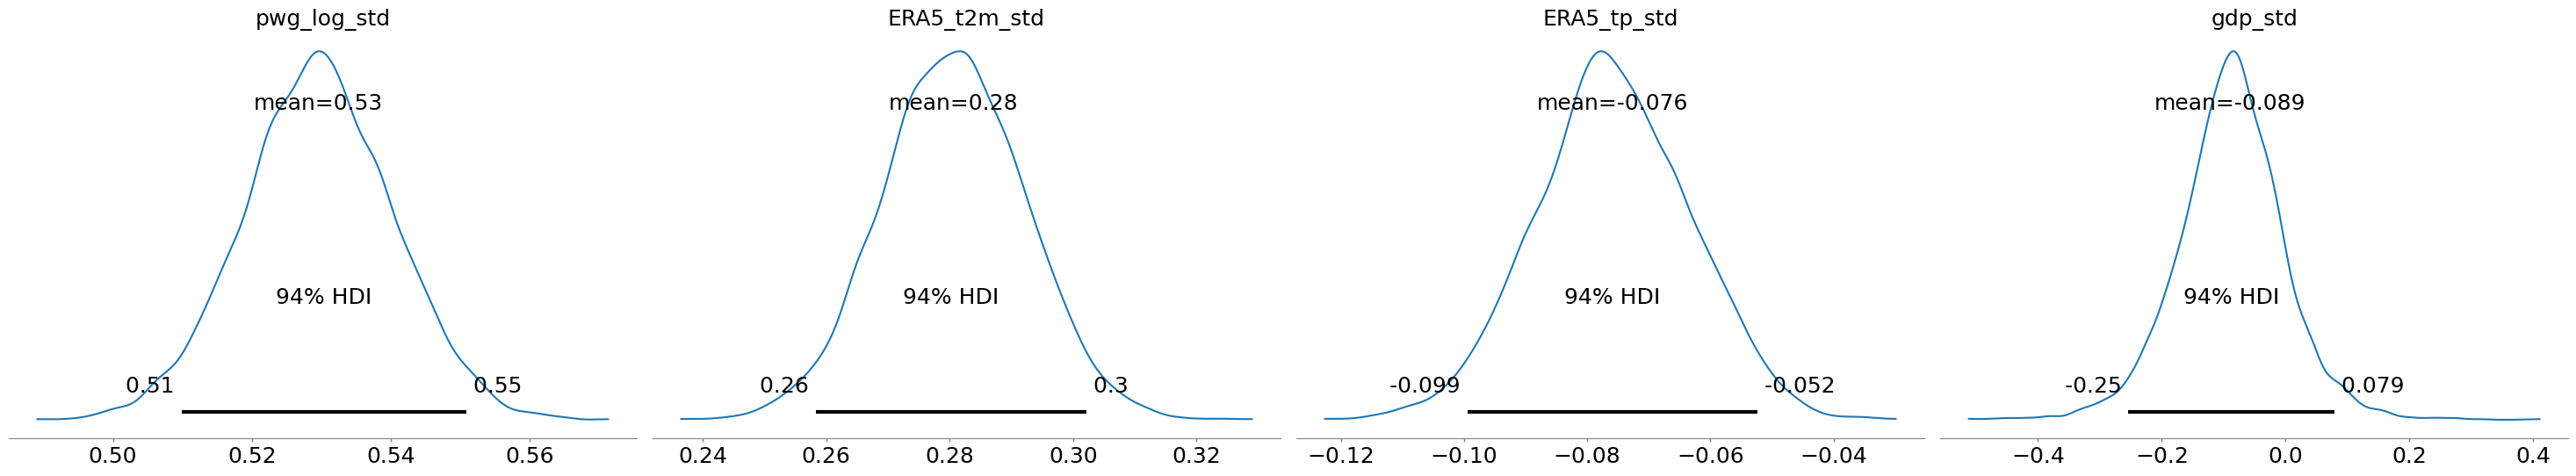

In [ ]:
map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "gdp_std": "GDP (Std)"
}

az.plot_posterior(idata7A, var_names=["pwg_log_std", "ERA5_t2m_std", "ERA5_tp_std", "gdp_std"], hdi_prob=0.94)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"7A_model_pwg_all_plot_posterior.pdf"), format='pdf', dpi=3000)
plt.show()

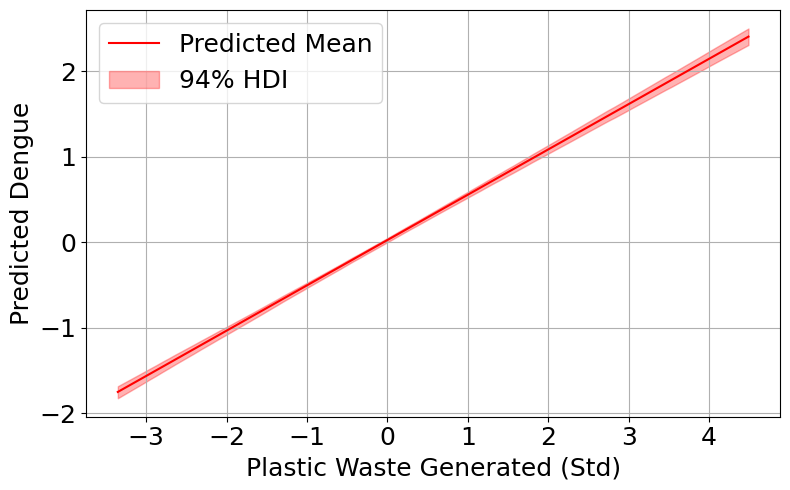

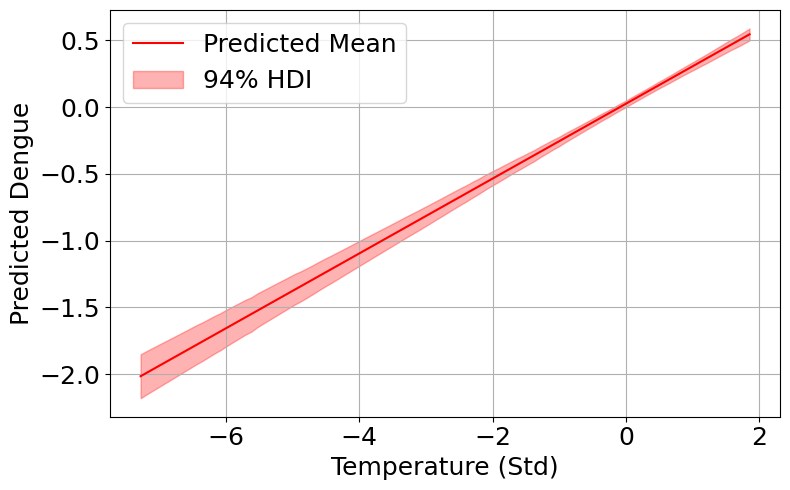

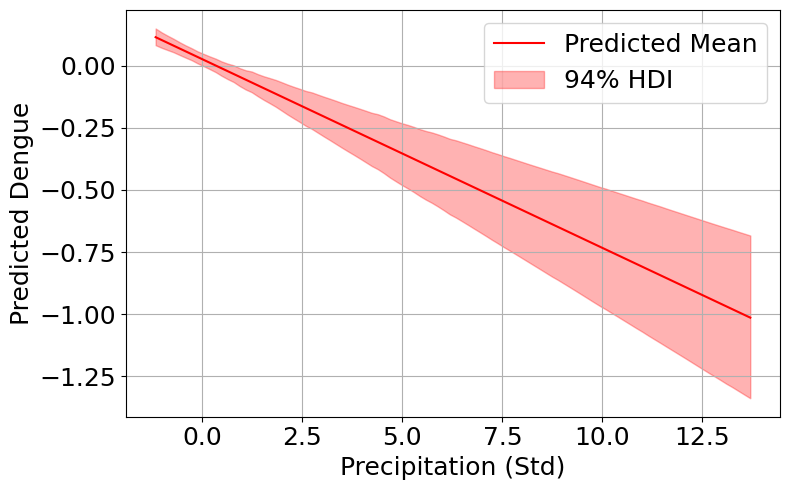

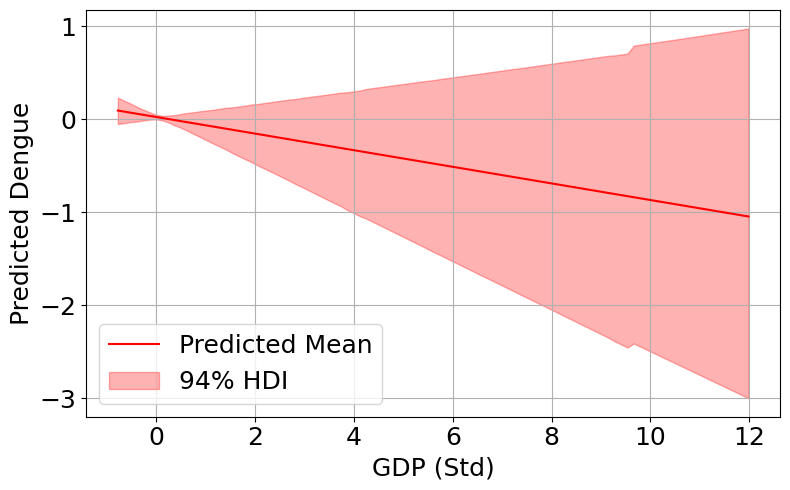

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["pwg_log_std", "ERA5_t2m_std", "ERA5_tp_std", "gdp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]

    # Predict
    pred = model_pwg_all_std.predict(idata=idata7A, data=df_pred, kind="response_params", inplace=False)
    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.94)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDI")
    plt.xlabel(map_names[var])
    plt.ylabel("Predicted Dengue")
    # No title
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"7A_marginal_effect_all_std_{var}.pdf"), format='pdf', dpi=3000)
    plt.show()


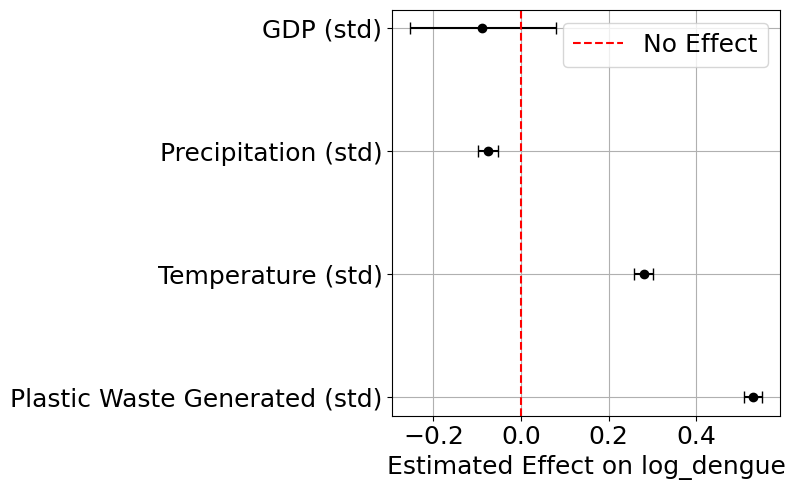

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import os

# Mapping internal variable names to readable labels
readable_names = {
    "pwg_log_std": "Plastic Waste Generated (std)",
    "ERA5_t2m_std": "Temperature (std)",
    "ERA5_tp_std": "Precipitation (std)",
    "gdp_std": "GDP (std)"
}

# Get posterior summary
summary = az.summary(
    idata7A,
    var_names=["pwg_log_std", "ERA5_t2m_std", "ERA5_tp_std", "gdp_std"]
)

# Apply readable labels to the index
summary.index = [readable_names.get(name, name) for name in summary.index]

# Extract values
means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, "7A_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)
plt.show()


## **7B pwg_temp_gdp_std_Splines**

In [ ]:
model_pwg_all_std_spliness = bmb.Model(
    "log_dengue_std  ~ bs(pwg_log_std, df = 3) + bs(ERA5_t2m_std, df = 3)
    + bs(ERA5_tp_std, df = 3) + bs(gdp_std, df = 3) + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_pwg_all_std_spliness = model_pwg_all_std_spliness.fit(
    draws=2000,
    tune=1000,
    idata_kwargs={"log_likelihood": True},
    chains = 4,
    target_accept=0.98,
    max_treedepth = 30,
    cores = 2)

idata7Bss = results_pwg_all_std_spliness

Buffered data was truncated after reaching the output size limit.

In [ ]:
model_pwg_all_std_splines = bmb.Model(
    "log_dengue_std  ~ bs(pwg_log_std, df = 3) + bs(ERA5_t2m_std, df = 3) + bs(ERA5_tp_std, df = 3) + bs(gdp_std, df = 3) + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_pwg_all_std_splines = model_pwg_all_std_splines.fit(
    draws=2000,
    tune=1000,
    idata_kwargs={"log_likelihood": True},
    chains = 4,
    target_accept=0.98,
    cores = 2)

idata7B = results_pwg_all_std_splines

Output()

ERROR:pymc.stats.convergence:There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata7B = results_pwg_all_std_splines
"log_likelihood" in idata7B.groups()

True

In [ ]:
idata7Bss = results_pwg_all_std_spliness

az.summary(idata7Bss, round_to = 4)


mean       sd   hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                 -0.1542   1.1001  -2.1889   1.9780   
1|adm_0_name[brazil]                     0.3162   2.2702  -4.0736   4.6127   
1|adm_0_name[china]                     -0.0354   2.6353  -5.0915   4.9538   
1|adm_0_name[colombia]                   0.8432   1.1353  -1.3813   2.9403   
1|adm_0_name[costa rica]                 0.8465   1.3248  -1.7296   3.3149   
1|adm_0_name[pakistan]                  -2.8432   1.1351  -4.9737  -0.6769   
1|adm_0_name[peru]                       1.0959   1.1784  -1.0881   3.4204   
1|adm_0_name[united states of america]  -0.0095   2.7715  -5.3497   5.1450   
1|adm_0_name_sigma                       2.3908   1.2882   0.8766   4.6418   
Intercept                                5.7181   1.4450   2.9127   8.3431   
bs(ERA5_t2m_std, df=3)[0]              -16.3682   0.8652 -17.9674 -14.7118   
bs(ERA5_t2m_std, df=3)[1]               -0.9221   0.4946  -1.8553  -0.0021   
bs(ERA5_t2m_std, df=3)[2]               -6.3236   0.5883  -7.4514  -5.2258   
bs(ERA5_tp_std, df=3)[0]                -1.7872   0.1791  -2.1211  -1.4442   
bs(ERA5_tp_std, df=3)[1]                -0.2090   0.3732  -0.8849   0.5063   
bs(ERA5_tp_std, df=3)[2]                -0.5200   0.3634  -1.1628   0.1977   
bs(gdp_std, df=3)[0]                     0.0513  16.1507 -31.1650  31.1663   
bs(gdp_std, df=3)[1]                     1.1684   9.2261 -16.3386  19.1994   
bs(gdp_std, df=3)[2]                    -1.9805   3.0554  -7.6582   4.0008   
bs(pwg_log_std, df=3)[0]                -2.6393   0.4373  -3.4178  -1.7977   
bs(pwg_log_std, df=3)[1]                 1.5181   0.1445   1.2373   1.7805   
bs(pwg_log_std, df=3)[2]                 2.6994   0.3685   2.0128   3.3883   
sigma                                    0.7291   0.0064   0.7169   0.7407   

                                        mcse_mean  mcse_sd    ess_bulk  \
1|adm_0_name[argentina]                    0.0236   0.0215   2541.1168   
1|adm_0_name[brazil]                       0.0509   0.0504   2499.0549   
1|adm_0_name[china]                        0.0338   0.0357   7318.1681   
1|adm_0_name[colombia]                     0.0235   0.0166   2477.9410   
1|adm_0_name[costa rica]                   0.0255   0.0181   2608.3799   
1|adm_0_name[pakistan]                     0.0235   0.0188   2524.1942   
1|adm_0_name[peru]                         0.0237   0.0168   2486.5057   
1|adm_0_name[united states of america]     0.0503   0.0492   4151.2836   
1|adm_0_name_sigma                         0.0404   0.0352   1903.4416   
Intercept                                  0.0273   0.0193   2722.4661   
bs(ERA5_t2m_std, df=3)[0]                  0.0130   0.0092   4397.7540   
bs(ERA5_t2m_std, df=3)[1]                  0.0075   0.0054   4343.5752   
bs(ERA5_t2m_std, df=3)[2]                  0.0090   0.0064   4281.2956   
bs(ERA5_tp_std, df=3)[0]                   0.0020   0.0014   7668.9801   
bs(ERA5_tp_std, df=3)[1]                   0.0047   0.0036   6391.3012   
bs(ERA5_tp_std, df=3)[2]                   0.0040   0.0029   8269.8287   
bs(gdp_std, df=3)[0]                       0.3294   0.2368   2547.0245   
bs(gdp_std, df=3)[1]                       0.1958   0.1697   2629.6575   
bs(gdp_std, df=3)[2]                       0.0580   0.0460   3244.8692   
bs(pwg_log_std, df=3)[0]                   0.0056   0.0040   6051.1283   
bs(pwg_log_std, df=3)[1]                   0.0015   0.0010   9576.6292   
bs(pwg_log_std, df=3)[2]                   0.0050   0.0035   5468.7302   
sigma                                      0.0001   0.0000  11397.7658   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 2043.1584  1.0005  
1|adm_0_name[brazil]                    1407.0037  1.0037  
1|adm_0_name[china]                     4700.5599  1.0006  
1|adm_0_name[colombia]                  2283.0835  1.0005  
1|adm_0_name[costa rica]                2648.6129  1.0006  
1|adm_0_name[pakistan]           

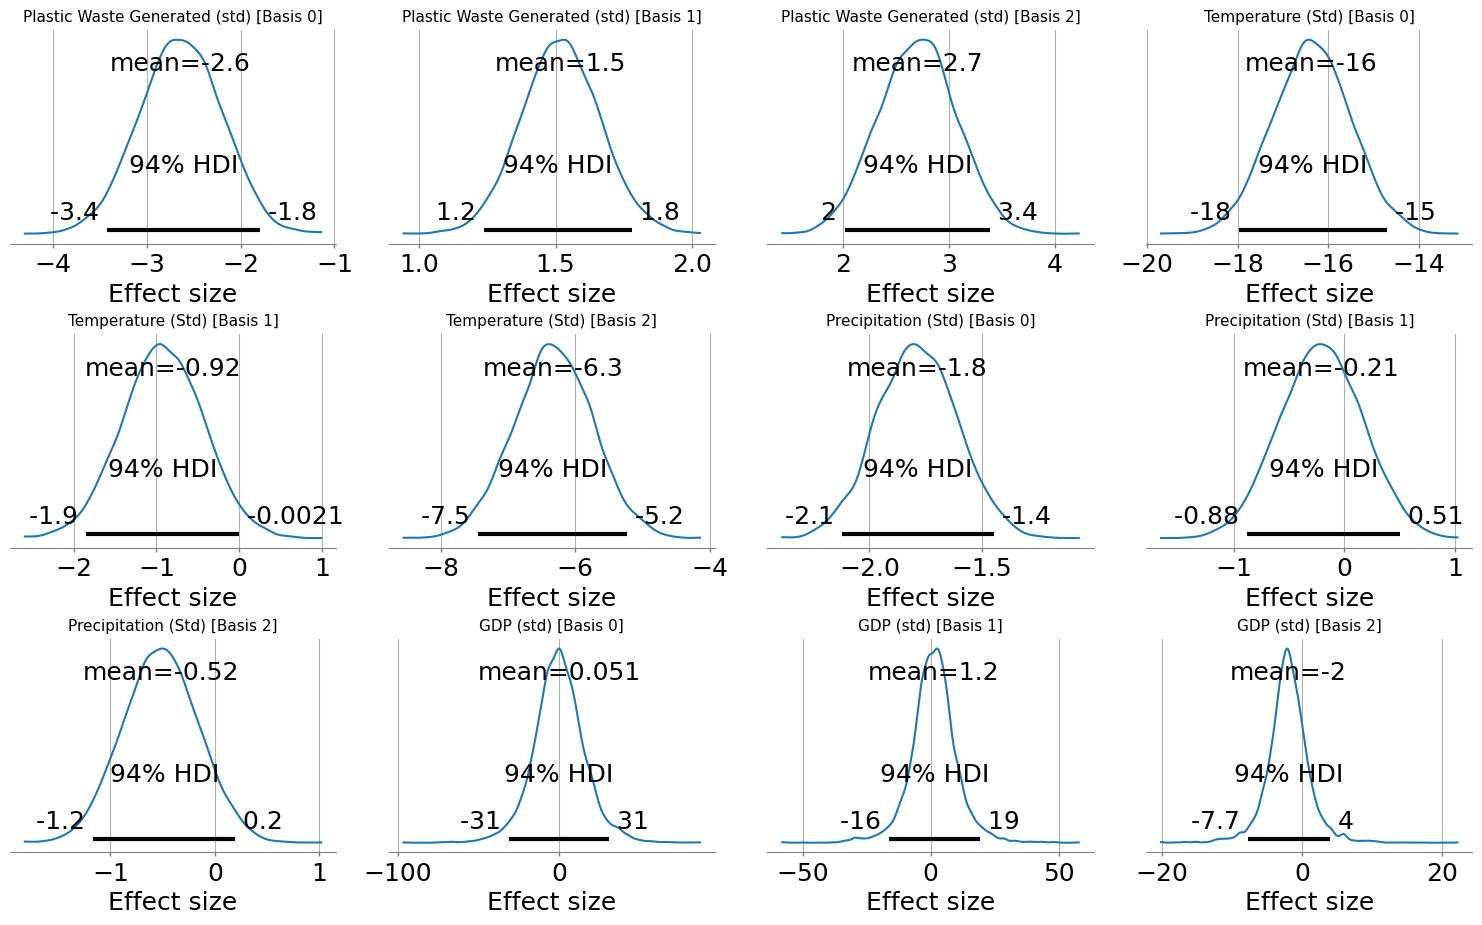

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import os

# Each variable and how many basis terms it has
spline_vars = {
    "bs(pwg_log_std, df=3)": 3,
    "bs(ERA5_t2m_std, df=3)" : 3,
    "bs(ERA5_tp_std, df=3)": 3,
    "bs(gdp_std, df=3)": 3

}
readable_names = {
    "bs(pwg_log_std, df=3)": "Plastic Waste Generated (std)",
    "bs(log_plas_litter_std, df=3)": "Plastic Litter Emmissions (std)",

    "bs(gdp_std, df=3)": "GDP (std)",
    "bs(ERA5_t2m_std, df=3)": "Temperature (Std)",
    "bs(ERA5_tp_std, df=3)": "Precipitation (Std)"

}
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 9 slots for 9 plots

axes = axes.flatten()

i = 0
for var, n_basis in spline_vars.items():
    for j in range(n_basis):
        az.plot_posterior(
            idata7Bss,
            var_names=[var],
            coords={f"{var}_dim": [j]},
            hdi_prob=0.94,
            point_estimate="mean",
            ax=axes[i]
        )
        axes[i].set_title(f"{readable_names[var]} [Basis {j}]", fontsize=11)
        axes[i].set_xlabel("Effect size")
        axes[i].grid(True)
        i += 1

# plt.suptitle("Posterior Distributions of Spline Terms", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(os.path.join(image_folder, "7B_spline_posterior_subplot.pdf"), format="pdf", dpi=3000)
plt.show()


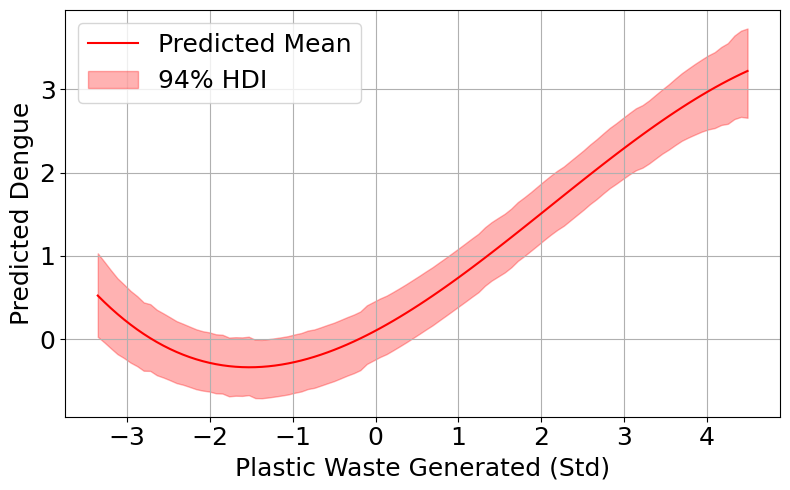

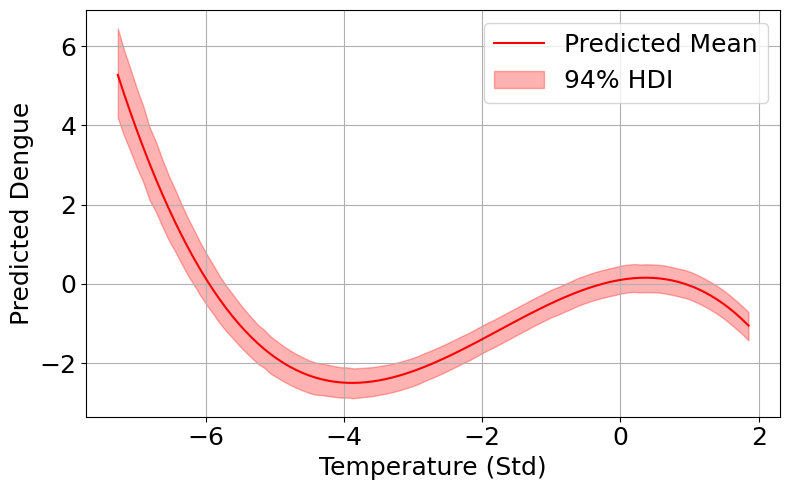

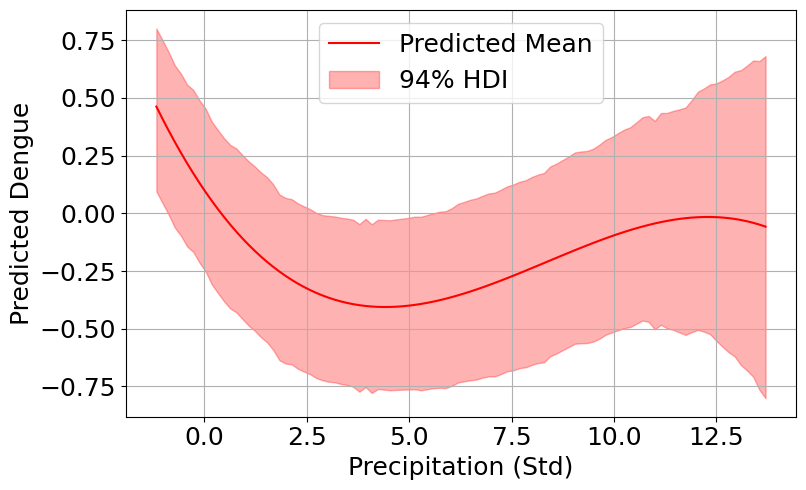

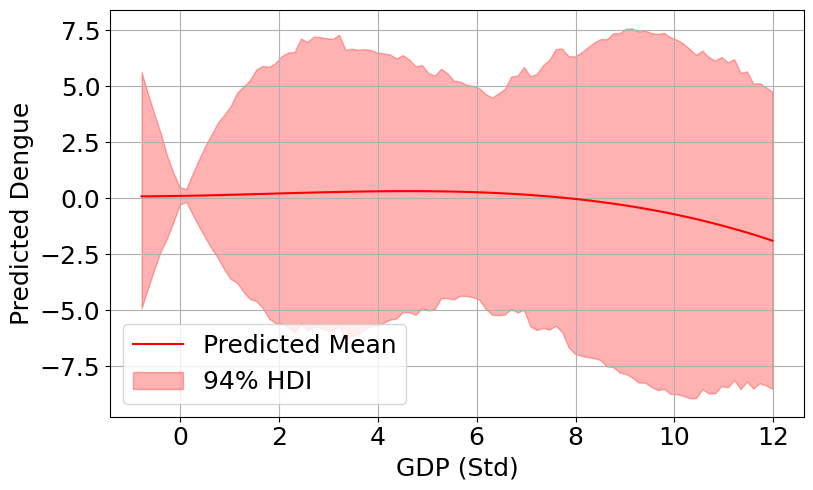

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import os

predictors = ["pwg_log_std", "ERA5_t2m_std", "ERA5_tp_std", "gdp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std": "Plastic Litter Emmitted (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]

    # Predict
    pred = model_pwg_all_std_spliness.predict(idata=idata7Bss, data=df_pred, kind="response_params", inplace=False)
    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.94)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDI")
    plt.xlabel(map_names[var])  # ✅ Use readable name
    plt.ylabel("Predicted Dengue")
    # No title, as requested
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"7B_marginal_effect_pwg_log_std_std_{var}.pdf"), format='pdf', dpi=3000)
    plt.show()


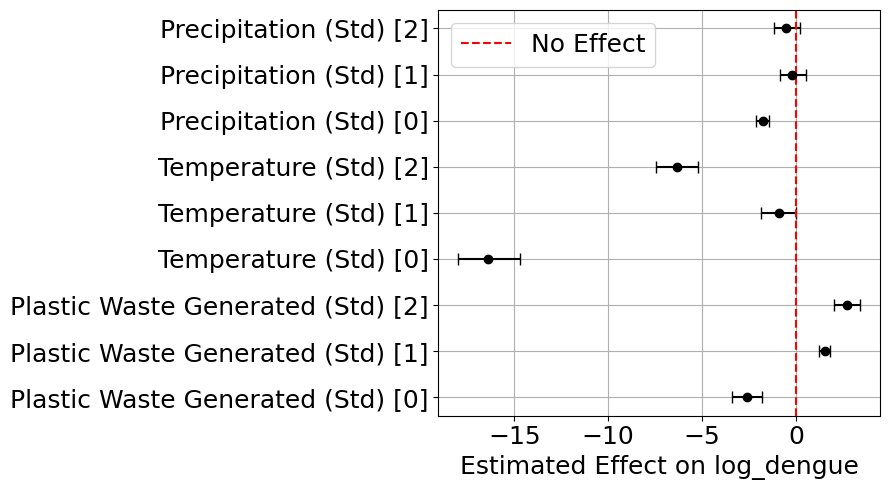

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import os

# Corrected mapping: base names must match exactly
readable_names = {
    "bs(pwg_log_std, df=3)": "Plastic Waste Generated (Std)",
    "bs(ERA5_t2m_std, df=3)": "Temperature (Std)",
    "bs(ERA5_tp_std, df=3)": "Precipitation (Std)"
}

# Get summary
summary = az.summary(
    idata7Bss,
    var_names=[
        "bs(pwg_log_std, df=3)",
        "bs(ERA5_t2m_std, df=3)",
        "bs(ERA5_tp_std, df=3)"
    ]
)

# Remap variable names
new_index = []
for var in summary.index:
    base_name = var.split("[")[0]
    idx = var.split("[")[1].rstrip("]") if "[" in var else ""
    label = f"{readable_names.get(base_name, base_name)} [{idx}]"
    new_index.append(label)

summary.index = new_index

# Extract values
means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]

# Plot
plt.figure(figsize=(9, 5))
plt.errorbar(means, summary.index, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, "7B_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)
plt.show()


## 8A_plas_litter_all_std

In [ ]:
model_plas_litter_all_std = bmb.Model(
    "log_dengue_std  ~ log_plas_litter_std + ERA5_t2m_std + ERA5_tp_std + gdp_std + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
results_plas_litter_all_std = model_plas_litter_all_std.fit(
    draws=2000,
    tune=1000,
    chains = 4,
    idata_kwargs={"log_likelihood": True},
    target_accept=0.98,
    cores = 2)

idata8A = results_plas_litter_all_std

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata8A = results_plas_litter_all_std
"log_likelihood" in idata8A.groups()

True

In [ ]:
az.summary(idata8A, round_to = 4)

mean      sd  hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                -0.2659  0.5681 -1.3927   0.7983   
1|adm_0_name[brazil]                    0.4524  0.5348 -0.6175   1.4310   
1|adm_0_name[china]                     0.7582  0.8273 -0.8379   2.3008   
1|adm_0_name[colombia]                  0.5151  0.5716 -0.6276   1.5685   
1|adm_0_name[costa rica]                0.8539  0.5837 -0.3048   1.9404   
1|adm_0_name[pakistan]                 -2.2310  0.6173 -3.3817  -1.0348   
1|adm_0_name[peru]                      0.3932  0.5765 -0.7397   1.4860   
1|adm_0_name[united states of america] -0.5637  1.2006 -2.8934   1.6727   
1|adm_0_name_sigma                      1.3561  0.4714  0.6598   2.2278   
ERA5_t2m_std                            0.2566  0.0121  0.2348   0.2799   
ERA5_tp_std                            -0.0775  0.0133 -0.1021  -0.0526   
Intercept                              -0.4265  0.5378 -1.3928   0.6710   
gdp_std                                -0.0333  0.1100 -0.2425   0.1752   
log_plas_litter_std                     0.4571  0.0121  0.4345   0.4799   
sigma                                   0.8529  0.0074  0.8387   0.8665   

                                        mcse_mean  mcse_sd    ess_bulk  \
1|adm_0_name[argentina]                    0.0127   0.0090   1993.6137   
1|adm_0_name[brazil]                       0.0119   0.0084   2016.9188   
1|adm_0_name[china]                        0.0133   0.0099   4039.2327   
1|adm_0_name[colombia]                     0.0128   0.0091   1970.2274   
1|adm_0_name[costa rica]                   0.0130   0.0092   1996.7797   
1|adm_0_name[pakistan]                     0.0127   0.0090   2382.4457   
1|adm_0_name[peru]                         0.0129   0.0091   1990.8267   
1|adm_0_name[united states of america]     0.0200   0.0159   3771.0604   
1|adm_0_name_sigma                         0.0093   0.0066   2501.0823   
ERA5_t2m_std                               0.0001   0.0001   9431.3172   
ERA5_tp_std                                0.0001   0.0001  10007.1225   
Intercept                                  0.0120   0.0085   2011.6765   
gdp_std                                    0.0021   0.0015   2838.2082   
log_plas_litter_std                        0.0001   0.0001   9580.1231   
sigma                                      0.0001   0.0001  10381.8310   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 2718.9117  1.0033  
1|adm_0_name[brazil]                    2769.2980  1.0032  
1|adm_0_name[china]                     4115.1628  1.0002  
1|adm_0_name[colombia]                  2715.1377  1.0033  
1|adm_0_name[costa rica]                2799.3392  1.0032  
1|adm_0_name[pakistan]                  3625.5549  1.0020  
1|adm_0_name[peru]                      2710.1427  1.0032  
1|adm_0_name[united states of america]  3985.6671  1.0002  
1|adm_0_name_sigma                      3883.4411  1.0019  
ERA5_t2m_std                            5758.9221  1.0002  
ERA5_tp_std                             5615.1692  1.0005  
Intercept                               2779.3665  1.0032  
gdp_std                                 3370.9326  1.0011  
log_plas_litter_std                     5068.1541  0.9998  
sigma                                   5683.5337  0.9998

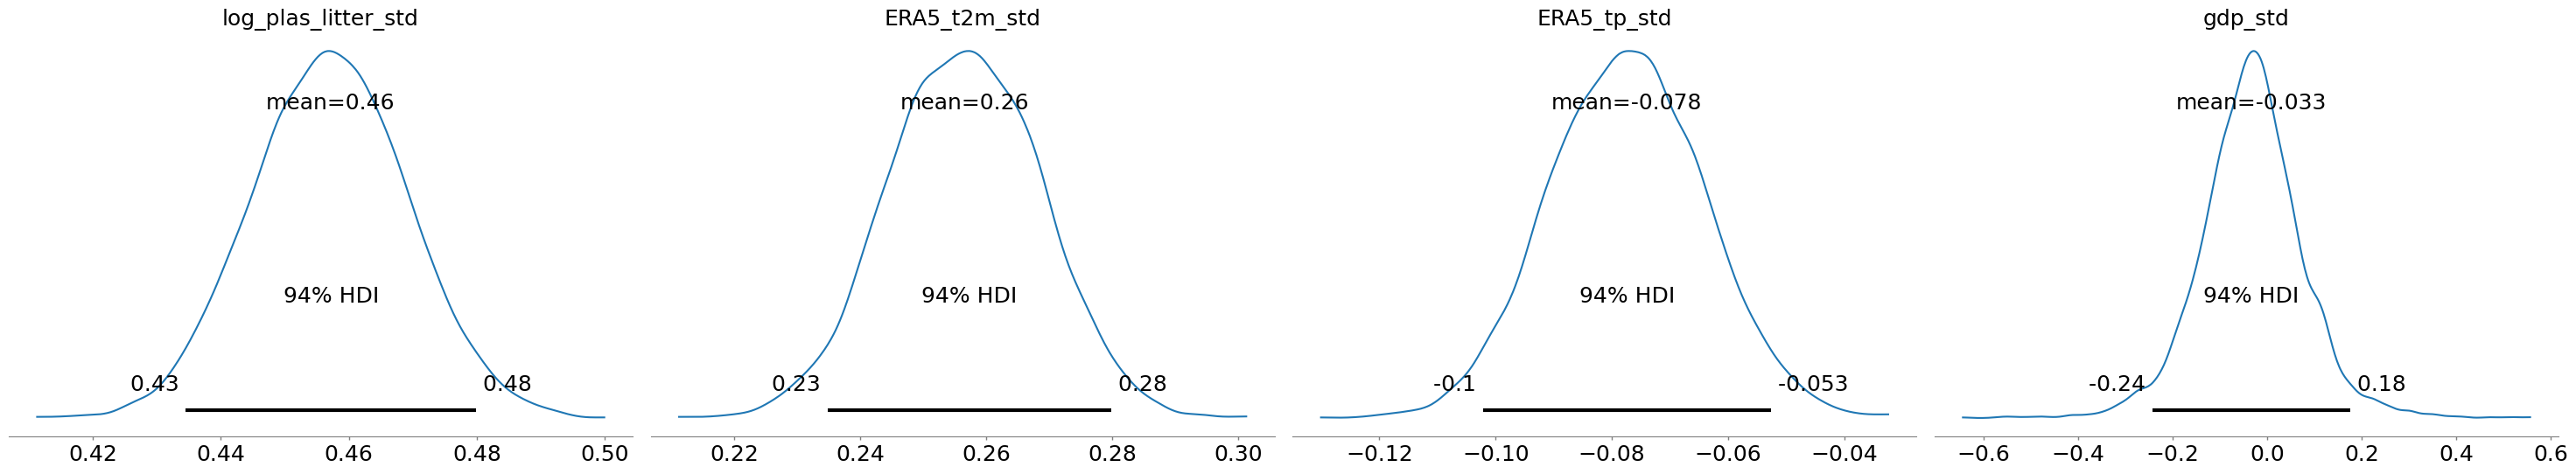

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import os

from arviz.labels import BaseLabeller

# Define a simple labeller with variable name replacements
map_names = {
    "log_plas_litter_std": "Plastic Litter Emissions (Std)",
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "gdp_std": "GDP (Std)"
}

class SimpleLabeller(BaseLabeller):
    def var_name(self, name, **kwargs):
        return map_names.get(name, name)

az.plot_posterior(
    idata8A,
    var_names=["log_plas_litter_std", "ERA5_t2m_std", "ERA5_tp_std", "gdp_std"],
    hdi_prob=0.94,
    labeller=SimpleLabeller()
)

plt.tight_layout()
plt.savefig(os.path.join(image_folder, "8A_plas_litter_temp_std_plot_posterior.pdf"), format="pdf", dpi=3000)
plt.show()


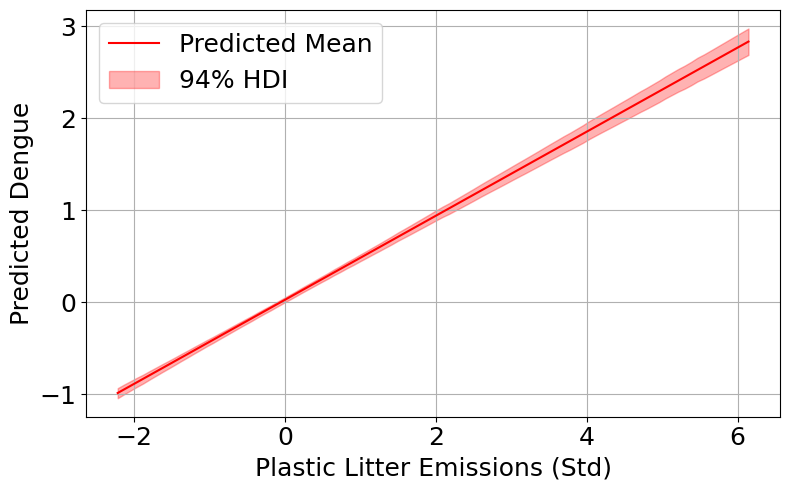

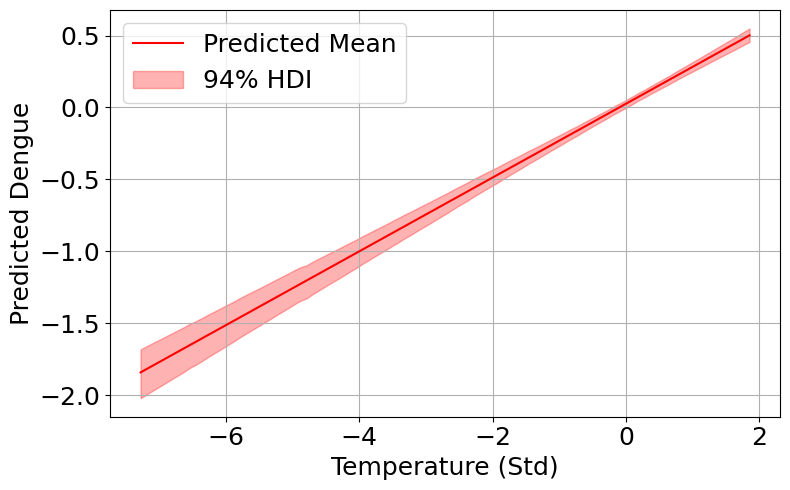

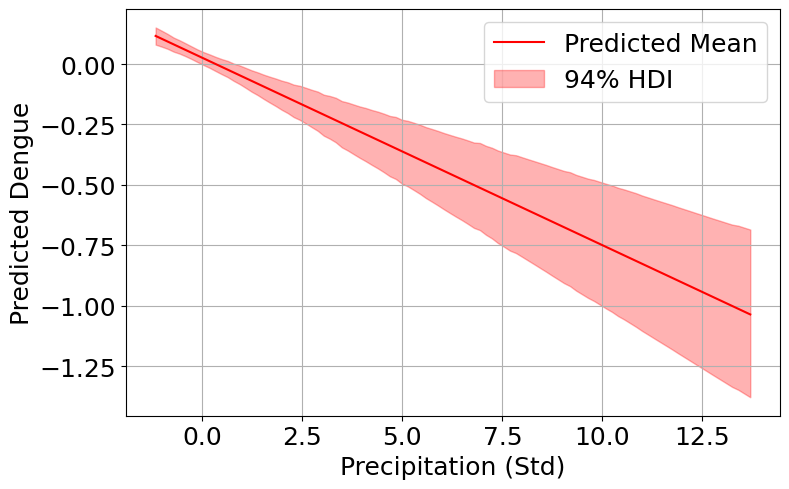

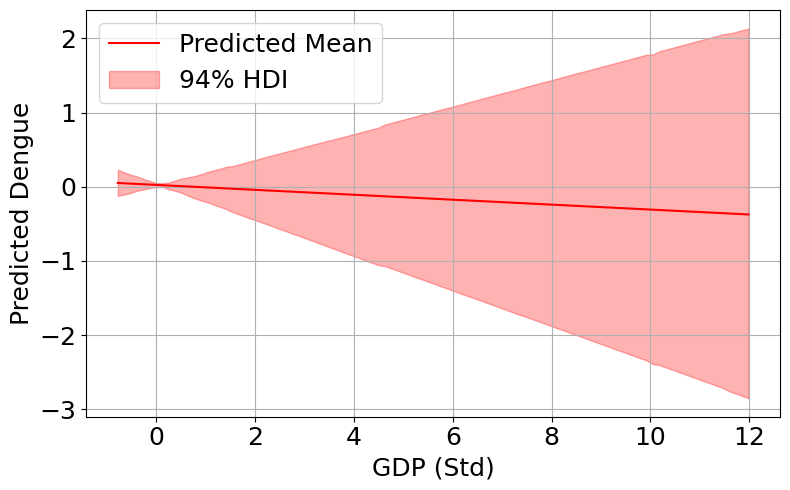

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["log_plas_litter_std", "ERA5_t2m_std", "ERA5_tp_std", "gdp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std" : "Plastic Litter Emissions (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe with all means
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals  # vary current var
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # known group

    # Predict
    pred = model_plas_litter_all_std.predict(idata=idata8A, data=df_pred, kind="response_params", inplace=False)

    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.94)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDI")
    plt.xlabel(map_names[var])
    plt.ylabel("Predicted Dengue")
    # plt.title(f"Marginal Effect of {map_names[var]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"8A_marginal_effect_plas_litter_temp_std{var}.pdf"), format='pdf', dpi=3000)

    plt.show()


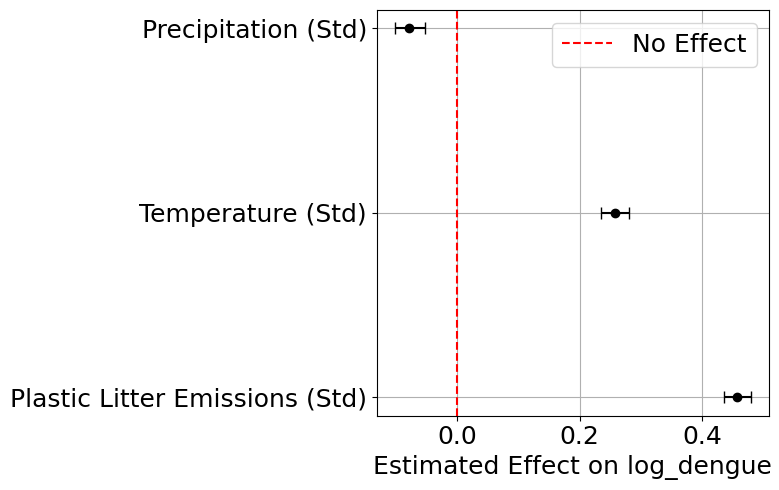

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std" : "Plastic Litter Emissions (Std)",
    "gdp_std": "GDP (Std)"
}

summary = az.summary(
    idata8A,
    var_names=["log_plas_litter_std", "ERA5_t2m_std", "ERA5_tp_std" ]
)
summary.index = [map_names.get(var, var) for var in summary.index]

means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]
variables = summary.index

plt.figure(figsize=(8, 5))
plt.errorbar(means, variables, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"8A_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)

plt.show()

## 8B_plas_litter_all_splines

In [ ]:
model_plas_litter_all_std_spline = bmb.Model(
    "log_dengue_std  ~  bs(log_plas_litter_std, df = 3) +  bs(ERA5_t2m_std, df = 3) + bs(ERA5_tp_std, df = 3) +  bs(gdp_std, df = 3)+ (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
result_plas_litter_all_std_spline = model_plas_litter_all_std_spline.fit(
    draws=2000,
    tune=1000,
    chains = 4,
    idata_kwargs={"log_likelihood": True},
    max_treedepth=20,
    target_accept=0.99,
    cores = 2)

idata8B = result_plas_litter_all_std_spline

Buffered data was truncated after reaching the output size limit.

In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata8B = result_plas_litter_all_std_spline
"log_likelihood" in idata8B.groups()

True

In [ ]:
az.summary(idata8B, round_to = 4)


mean       sd   hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                  0.0478   1.2761  -2.2967   2.4960   
1|adm_0_name[brazil]                     0.4582   2.5083  -4.7801   4.8334   
1|adm_0_name[china]                      0.0996   2.8955  -5.5429   5.3895   
1|adm_0_name[colombia]                   1.1433   1.3258  -1.3850   3.6158   
1|adm_0_name[costa rica]                 1.2331   1.5527  -1.6622   4.2650   
1|adm_0_name[pakistan]                  -3.4796   1.3459  -5.9852  -0.9047   
1|adm_0_name[peru]                       0.9595   1.3840  -1.6903   3.5438   
1|adm_0_name[united states of america]   0.0118   2.8536  -5.4162   5.2887   
1|adm_0_name_sigma                       2.7784   1.2268   1.1188   5.0504   
Intercept                                4.5279   1.6429   1.5928   7.8760   
bs(ERA5_t2m_std, df=3)[0]              -16.6230   0.9344 -18.4173 -14.8516   
bs(ERA5_t2m_std, df=3)[1]               -0.5846   0.5350  -1.6055   0.4020   
bs(ERA5_t2m_std, df=3)[2]               -6.4896   0.6357  -7.7533  -5.3403   
bs(ERA5_tp_std, df=3)[0]                -1.7303   0.1927  -2.1038  -1.3801   
bs(ERA5_tp_std, df=3)[1]                -0.6782   0.3970  -1.4261   0.0591   
bs(ERA5_tp_std, df=3)[2]                -0.2630   0.3931  -1.0126   0.4594   
bs(gdp_std, df=3)[0]                     0.7926  18.1268 -32.3296  38.5348   
bs(gdp_std, df=3)[1]                     0.7563  10.0630 -18.8183  19.8256   
bs(gdp_std, df=3)[2]                    -1.0188   3.2123  -6.7671   5.0861   
bs(log_plas_litter_std, df=3)[0]        -0.0234   0.2352  -0.4531   0.4258   
bs(log_plas_litter_std, df=3)[1]         3.1913   0.2531   2.7011   3.6437   
bs(log_plas_litter_std, df=3)[2]         3.7160   0.4735   2.8237   4.5994   
sigma                                    0.7785   0.0068   0.7665   0.7918   

                                        mcse_mean  mcse_sd   ess_bulk  \
1|adm_0_name[argentina]                    0.0678   0.0480   369.3172   
1|adm_0_name[brazil]                       0.1160   0.0863   494.5416   
1|adm_0_name[china]                        0.0803   0.0570  1371.1262   
1|adm_0_name[colombia]                     0.0710   0.0502   351.6841   
1|adm_0_name[costa rica]                   0.0792   0.0560   402.5693   
1|adm_0_name[pakistan]                     0.0661   0.0468   455.5040   
1|adm_0_name[peru]                         0.0740   0.0524   362.1452   
1|adm_0_name[united states of america]     0.0894   0.0737  1094.6978   
1|adm_0_name_sigma                         0.0461   0.0326   587.1441   
Intercept                                  0.0787   0.0557   450.0413   
bs(ERA5_t2m_std, df=3)[0]                  0.0440   0.0311   450.3877   
bs(ERA5_t2m_std, df=3)[1]                  0.0248   0.0175   465.7620   
bs(ERA5_t2m_std, df=3)[2]                  0.0304   0.0215   437.2697   
bs(ERA5_tp_std, df=3)[0]                   0.0049   0.0034  1572.5617   
bs(ERA5_tp_std, df=3)[1]                   0.0104   0.0073  1470.0170   
bs(ERA5_tp_std, df=3)[2]                   0.0098   0.0070  1602.5209   
bs(gdp_std, df=3)[0]                       0.8463   0.5988   467.8005   
bs(gdp_std, df=3)[1]                       0.4424   0.3130   542.4139   
bs(gdp_std, df=3)[2]                       0.1303   0.0922   640.6468   
bs(log_plas_litter_std, df=3)[0]           0.0086   0.0061   754.5203   
bs(log_plas_litter_std, df=3)[1]           0.0101   0.0071   632.4829   
bs(log_plas_litter_std, df=3)[2]           0.0184   0.0130   657.9280   
sigma                                      0.0001   0.0001  2691.2334   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                  825.3163  1.0093  
1|adm_0_name[brazil]                     429.8564  1.0058  
1|adm_0_name[china]                     1823.7255  1.0027  
1|adm_0_name[colombia]                   692.6176  1.0110  
1|adm_0_name[costa rica]                 587.9038  1.0126  
1|adm_0_name[pakistan]                   793.4327  1.0084

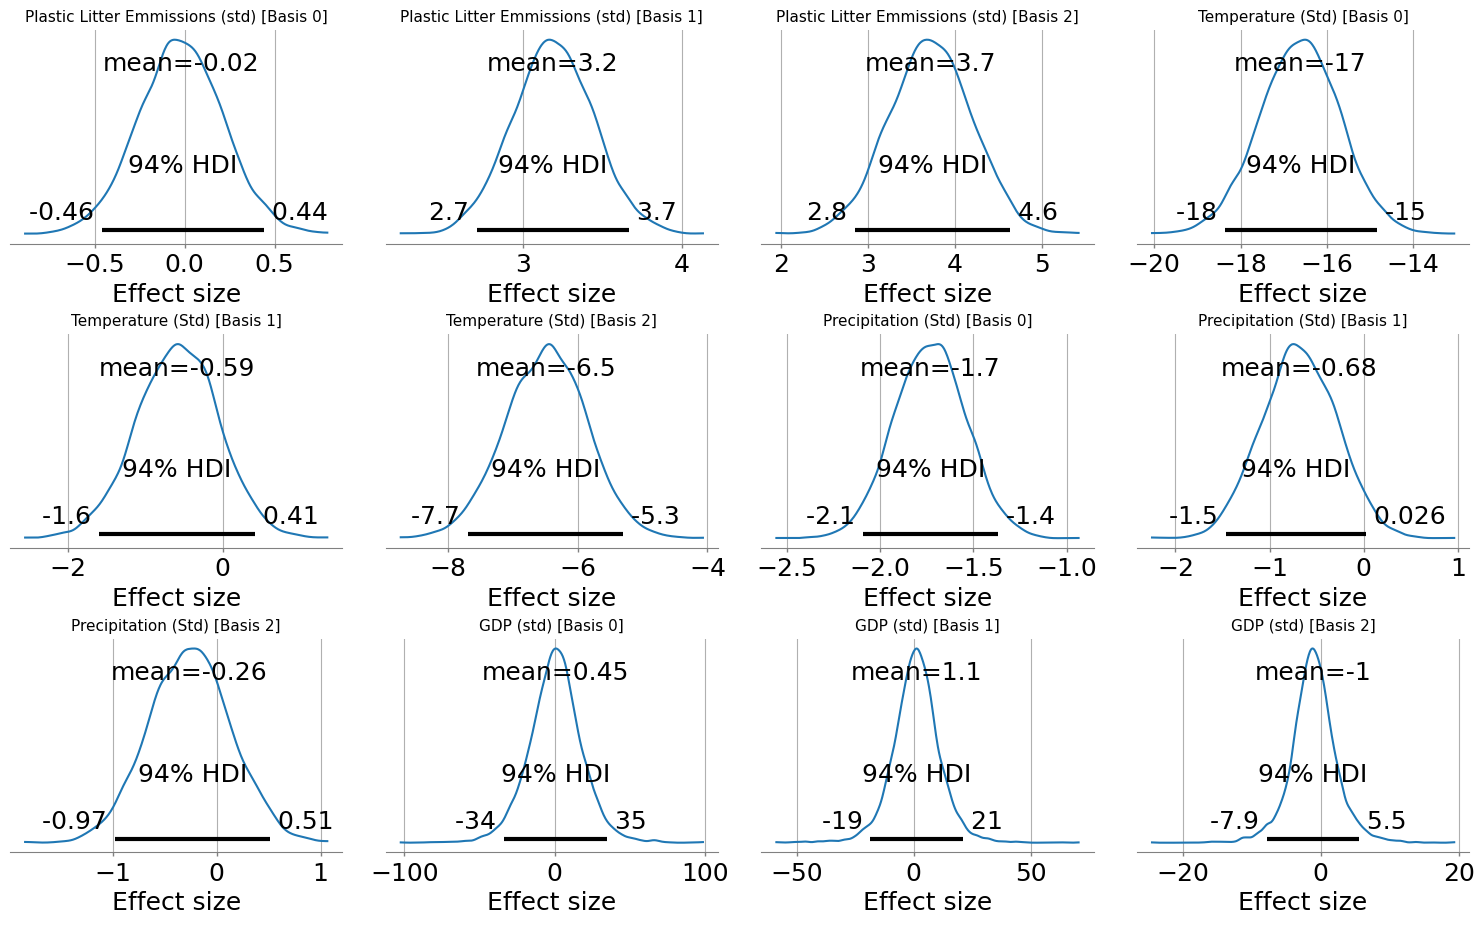

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import os

# Each variable and how many basis terms it has
spline_vars = {
    "bs(log_plas_litter_std, df=3)": 3,
    "bs(ERA5_t2m_std, df=3)" : 3,
    "bs(ERA5_tp_std, df=3)": 3,
    "bs(gdp_std, df=3)":3
}
readable_names = {
    "bs(pwg_log_std, df=3)": "Plastic Waste Generated (std)",
    "bs(log_plas_litter_std, df=3)": "Plastic Litter Emmissions (std)",

    "bs(gdp_std, df=3)": "GDP (std)",
    "bs(ERA5_t2m_std, df=3)": "Temperature (Std)",
    "bs(ERA5_tp_std, df=3)": "Precipitation (Std)"

}
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 9 slots for 9 plots

axes = axes.flatten()

i = 0
for var, n_basis in spline_vars.items():
    for j in range(n_basis):
        az.plot_posterior(
            idata8B,
            var_names=[var],
            coords={f"{var}_dim": [j]},
            hdi_prob=0.94,
            point_estimate="mean",
            ax=axes[i]
        )
        axes[i].set_title(f"{readable_names[var]} [Basis {j}]", fontsize=11)
        axes[i].set_xlabel("Effect size")
        axes[i].grid(True)
        i += 1

# plt.suptitle("Posterior Distributions of Spline Terms", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(os.path.join(image_folder, "8B_spline_posterior_subplot.pdf"), format="pdf", dpi=3000)
plt.show()


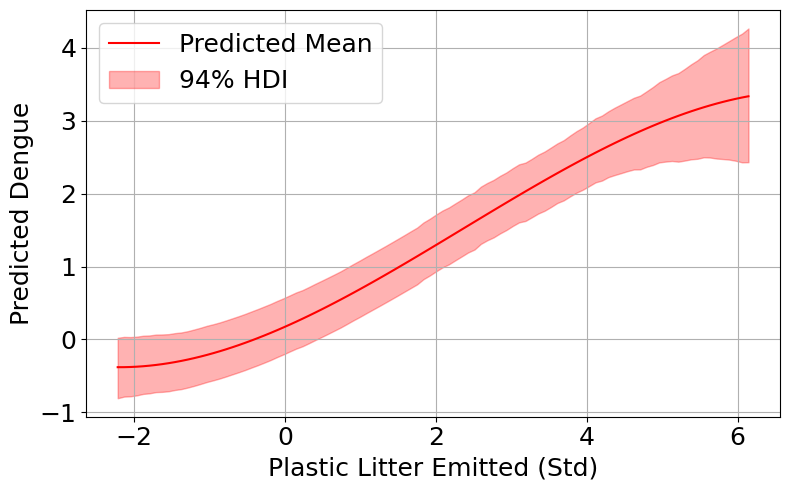

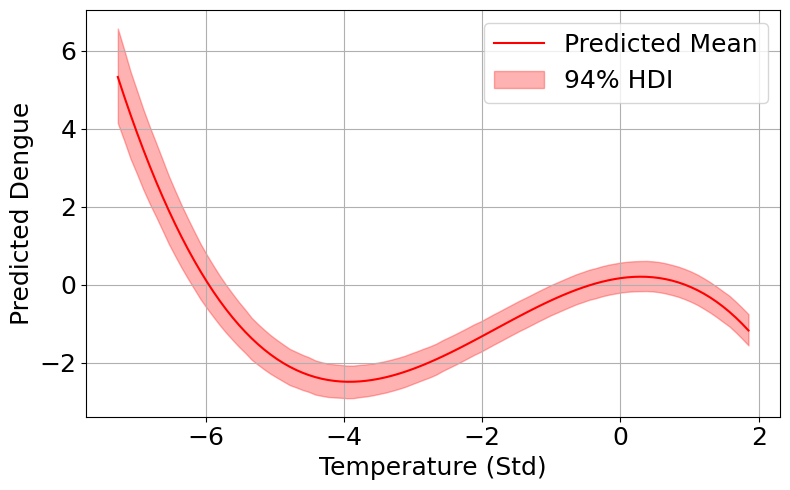

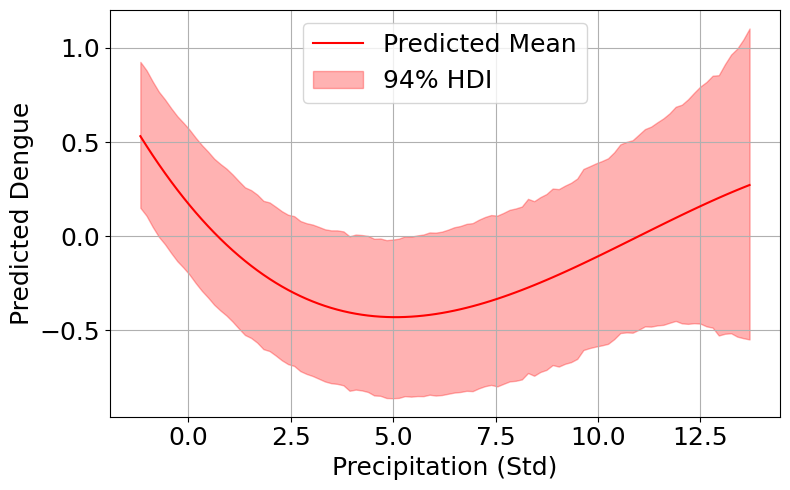

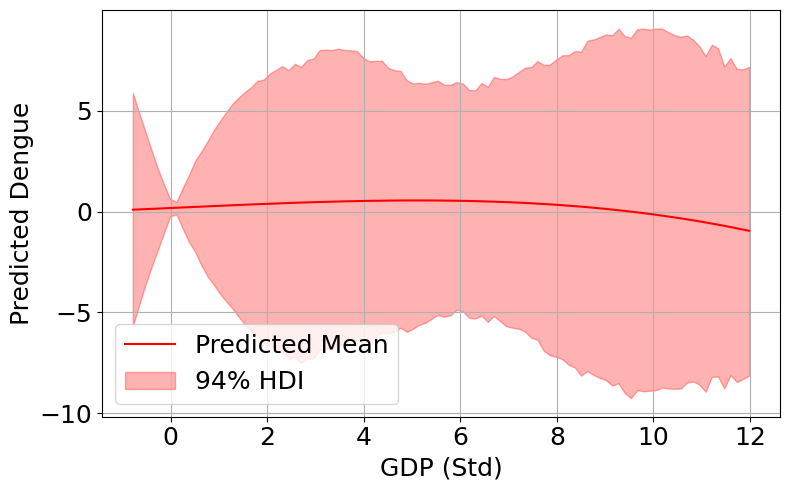

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["log_plas_litter_std", "ERA5_t2m_std", "ERA5_tp_std", "gdp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std": "Plastic Litter Emitted (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe with all means
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals  # vary current var
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # known group

    # Predict
    pred = model_plas_litter_all_std_spline.predict(
        idata=idata8B,
        data=df_pred,
        kind="response_params",
        inplace=False
    )

    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.94)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDI")
    plt.xlabel(map_names.get(var, var))
    plt.ylabel("Predicted Dengue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"8B_marginal_effect_plas_litter_all_std{var}.pdf"), format='pdf', dpi=3000)

    plt.show()


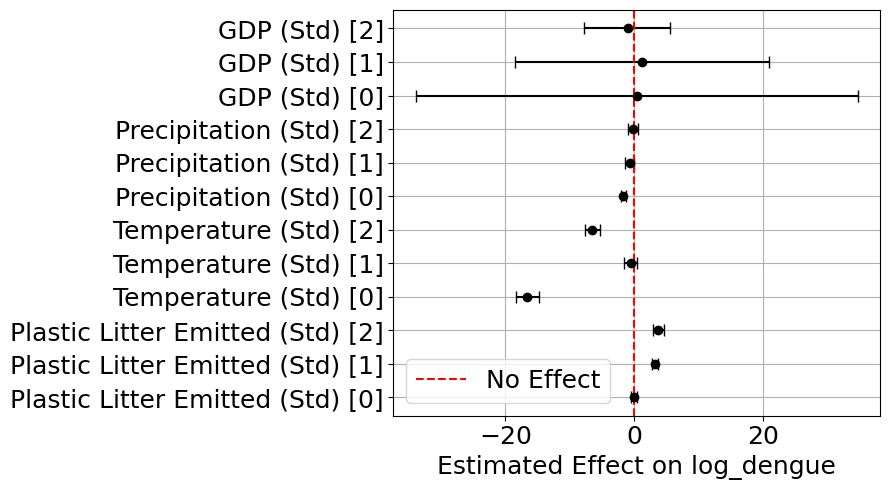

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

# Updated mapping for the base variable names (inside bs())
readable_names = {
    "log_plas_litter_std": "Plastic Litter Emitted (Std)",
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "gdp_std": "GDP (Std)"
}

# Extract summary for spline variables
summary = az.summary(
    idata8B,
    var_names=[
        "bs(log_plas_litter_std, df=3)",
        "bs(ERA5_t2m_std, df=3)",
        "bs(ERA5_tp_std, df=3)",
        "bs(gdp_std, df=3)"
    ]
)

# Clean variable names for y-axis labels
new_index = []
for var in summary.index:
    base_name = var.split("(")[1].split(",")[0]  # extract var name from bs(...)
    idx = var.split("[")[1].rstrip("]") if "[" in var else ""
    label = f"{readable_names.get(base_name, base_name)} [{idx}]"
    new_index.append(label)

summary.index = new_index

# Plot
means = summary["mean"]
lower = summary["hdi_3%"]
upper = summary["hdi_97%"]

plt.figure(figsize=(9, 5))
plt.errorbar(means, summary.index, xerr=[means - lower, upper - means], fmt='o', color='black', capsize=4)
plt.axvline(x=0, linestyle="--", color="red", label="No Effect")
plt.xlabel("Estimated Effect on log_dengue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"8B_Posterior_Means_and_95%_HDIs.pdf"), format='pdf', dpi=3000)
plt.show()


## 9A

In [ ]:
model_all_but_plastic_std_spline = bmb.Model(
    "log_dengue_std  ~  ERA5_t2m_std,  + ERA5_tp_std, +  gdp_std + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
result_all_but_plastic_std = model_all_but_plastic_std_spline.fit(
    draws=2000,
    tune=1000,
    chains = 4,
    idata_kwargs={"log_likelihood": True},
    target_accept=0.98,
    cores = 2)

idata9A = result_all_but_plastic_std

## 9B

In [ ]:
model_all_but_plastic_std_spline = bmb.Model(
    "log_dengue_std  ~  bs(ERA5_t2m_std, df = 3) + bs(ERA5_tp_std, df = 3) +  bs(gdp_std, df = 3) + (1|adm_0_name)",
    data=df_scaled,
    family="gaussian",
    noncentered=True

)
result_all_but_plastic_std_spline = model_all_but_plastic_std_spline.fit(
    draws=2000,
    tune=1000,
    chains = 4,
    idata_kwargs={"log_likelihood": True},
    target_accept=0.98,
    cores = 2)

idata9B = result_all_but_plastic_std_spline
az.summary(idata9A, round_to = 4)


Buffered data was truncated after reaching the output size limit.

In [ ]:
#     idata_kwargs={"log_likelihood": True},
idata9B = result_all_but_plastic_std_spline
"log_likelihood" in idata9B.groups()

True

In [ ]:
az.summary(idata9B, round_to = 4)


mean       sd   hdi_3%  hdi_97%  \
1|adm_0_name[argentina]                 -0.1208   0.6860  -1.3626   1.2654   
1|adm_0_name[brazil]                     0.2464   1.4696  -2.6753   2.9857   
1|adm_0_name[china]                     -0.0563   1.6409  -3.2183   2.9132   
1|adm_0_name[colombia]                   0.0530   0.7213  -1.2511   1.4980   
1|adm_0_name[costa rica]                 0.4249   0.8787  -1.1933   2.1340   
1|adm_0_name[pakistan]                  -1.6070   0.7441  -3.0763  -0.2467   
1|adm_0_name[peru]                       1.0135   0.7647  -0.3886   2.5238   
1|adm_0_name[united states of america]   0.0184   1.6900  -3.1705   3.2557   
1|adm_0_name_sigma                       1.4662   0.7738   0.4943   2.9375   
Intercept                                5.2901   1.0918   3.2447   7.3210   
bs(ERA5_t2m_std, df=3)[0]              -15.5159   1.0396 -17.4855 -13.5987   
bs(ERA5_t2m_std, df=3)[1]                0.0699   0.5878  -1.0511   1.1444   
bs(ERA5_t2m_std, df=3)[2]               -5.5034   0.7015  -6.7749  -4.1610   
bs(ERA5_tp_std, df=3)[0]                -1.2921   0.2192  -1.7139  -0.8859   
bs(ERA5_tp_std, df=3)[1]                -0.8556   0.4549  -1.7295  -0.0069   
bs(ERA5_tp_std, df=3)[2]                 0.1820   0.4437  -0.6180   1.0532   
bs(gdp_std, df=3)[0]                    -4.8892  11.0028 -25.3250  17.6301   
bs(gdp_std, df=3)[1]                     4.9180   5.7713  -5.9196  16.4784   
bs(gdp_std, df=3)[2]                    -1.2096   1.9112  -4.9705   2.4281   
sigma                                    0.8840   0.0078   0.8688   0.8984   

                                        mcse_mean  mcse_sd    ess_bulk  \
1|adm_0_name[argentina]                    0.0151   0.0107   2032.0804   
1|adm_0_name[brazil]                       0.0368   0.0260   1692.4902   
1|adm_0_name[china]                        0.0274   0.0237   4537.1376   
1|adm_0_name[colombia]                     0.0162   0.0114   1975.8837   
1|adm_0_name[costa rica]                   0.0207   0.0146   1818.5665   
1|adm_0_name[pakistan]                     0.0157   0.0111   2275.1976   
1|adm_0_name[peru]                         0.0174   0.0123   1921.0385   
1|adm_0_name[united states of america]     0.0304   0.0261   3701.8552   
1|adm_0_name_sigma                         0.0213   0.0151   1462.8703   
Intercept                                  0.0239   0.0170   2142.2217   
bs(ERA5_t2m_std, df=3)[0]                  0.0187   0.0133   3080.6694   
bs(ERA5_t2m_std, df=3)[1]                  0.0103   0.0073   3267.2848   
bs(ERA5_t2m_std, df=3)[2]                  0.0127   0.0090   3053.8893   
bs(ERA5_tp_std, df=3)[0]                   0.0029   0.0020   5726.1019   
bs(ERA5_tp_std, df=3)[1]                   0.0063   0.0045   5220.4537   
bs(ERA5_tp_std, df=3)[2]                   0.0056   0.0043   6241.4894   
bs(gdp_std, df=3)[0]                       0.2866   0.2027   1570.1374   
bs(gdp_std, df=3)[1]                       0.1392   0.1049   1882.5231   
bs(gdp_std, df=3)[2]                       0.0419   0.0296   2339.7666   
sigma                                      0.0001   0.0001  10547.0704   

                                         ess_tail   r_hat  
1|adm_0_name[argentina]                 2800.8803  1.0020  
1|adm_0_name[brazil]                    1868.7841  1.0021  
1|adm_0_name[china]                     3354.0501  1.0000  
1|adm_0_name[colombia]                  2797.2726  1.0020  
1|adm_0_name[costa rica]                2370.8249  1.0020  
1|adm_0_name[pakistan]                  3048.6590  1.0014  
1|adm_0_name[peru]                      2452.9132  1.0020  
1|adm_0_name[united states of america]  2642.5615  1.0011  
1|adm_0_name_sigma                      2228.1354  1.0010  
Intercept                               2682.2284  1.0019  
bs(ERA5_t2m_std, df=3)[0]               4856.0175  1.0008  
bs(ERA5_t2m_std, df=3)[1]               4720.8669  1.0004  
bs(ERA5_t2m_std, df=3)[2]               4330.7059  1.0007  
bs(ERA5_t

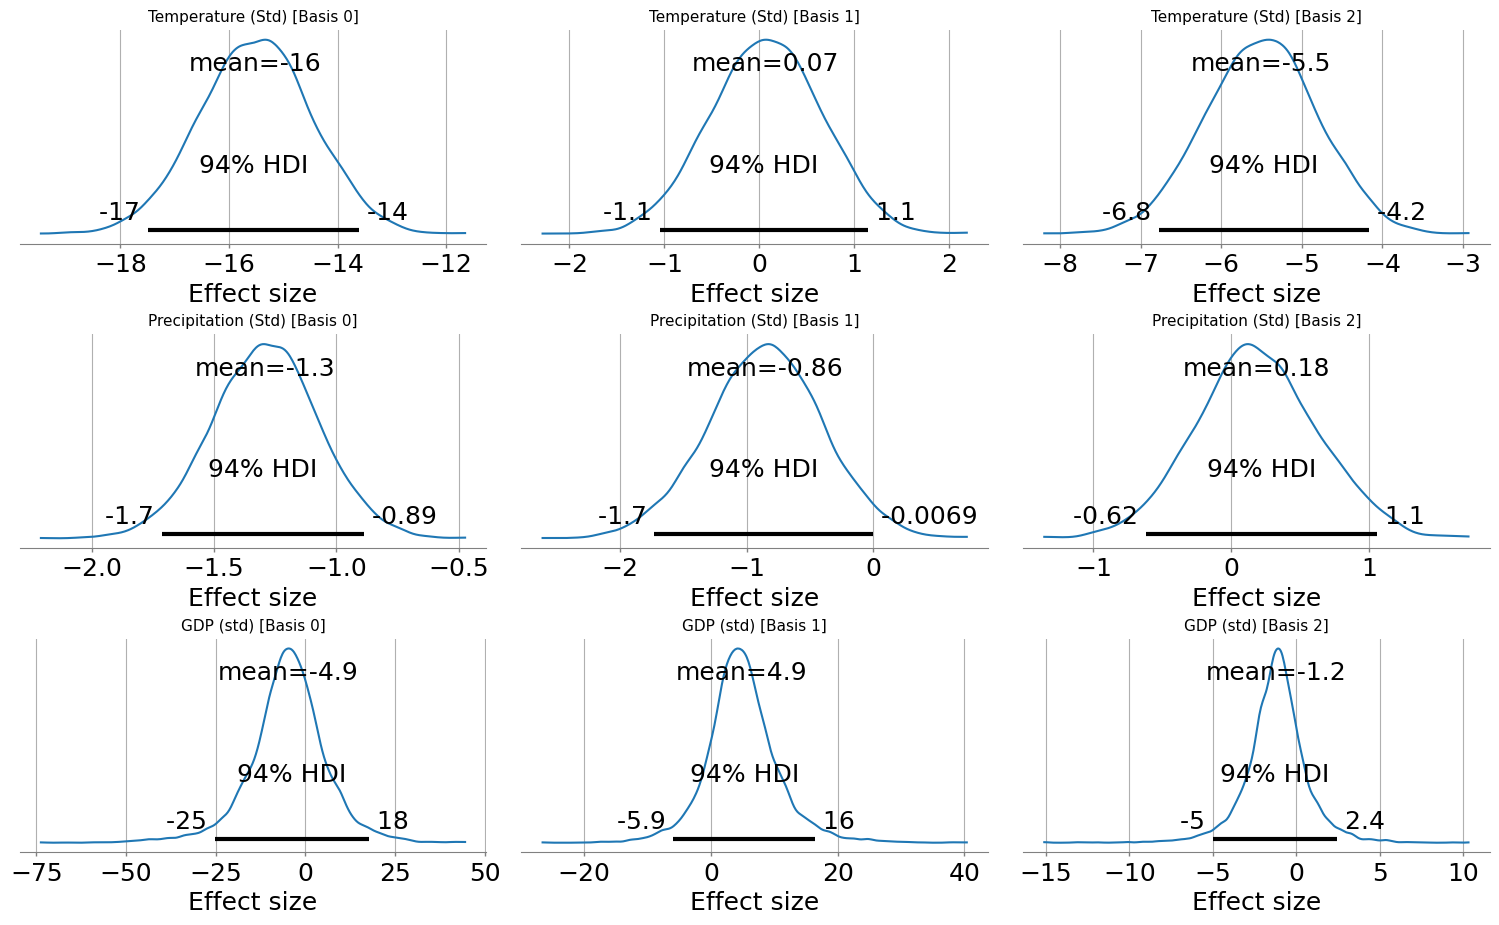

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import os

# Each variable and how many basis terms it has
spline_vars = {
    "bs(ERA5_t2m_std, df=3)" : 3,
    "bs(ERA5_tp_std, df=3)": 3,
    "bs(gdp_std, df=3)":3
}
readable_names = {
    "bs(pwg_log_std, df=3)": "Plastic Waste Generated (std)",
    "bs(log_plas_litter_std, df=3)": "Plastic Litter Emmissions (std)",

    "bs(gdp_std, df=3)": "GDP (std)",
    "bs(ERA5_t2m_std, df=3)": "Temperature (Std)",
    "bs(ERA5_tp_std, df=3)": "Precipitation (Std)"

}
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 9 slots for 9 plots

axes = axes.flatten()

i = 0
for var, n_basis in spline_vars.items():
    for j in range(n_basis):
        az.plot_posterior(
            idata9B,
            var_names=[var],
            coords={f"{var}_dim": [j]},
            hdi_prob=0.94,
            point_estimate="mean",
            ax=axes[i]
        )
        axes[i].set_title(f"{readable_names[var]} [Basis {j}]", fontsize=11)
        axes[i].set_xlabel("Effect size")
        axes[i].grid(True)
        i += 1

# plt.suptitle("Posterior Distributions of Spline Terms", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(os.path.join(image_folder, "9B_spline_posterior_subplot.pdf"), format="pdf", dpi=3000)
plt.show()


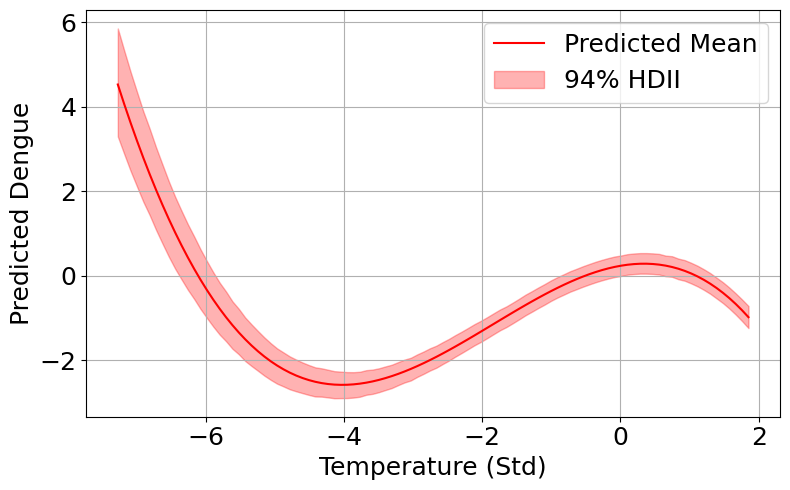

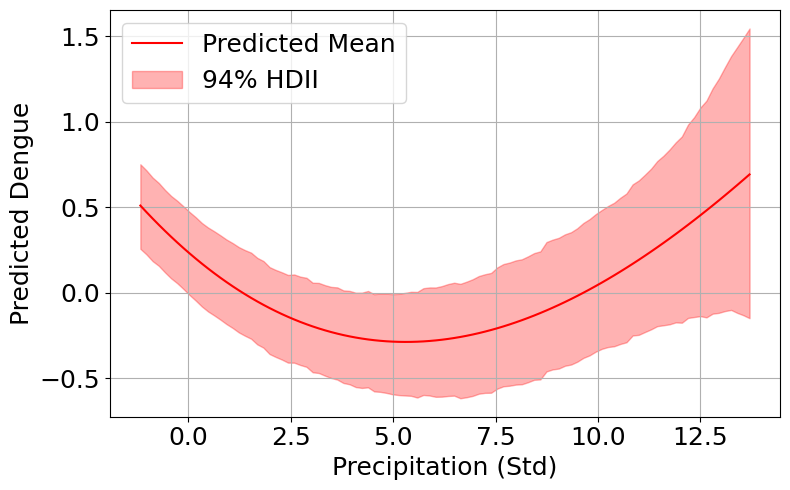

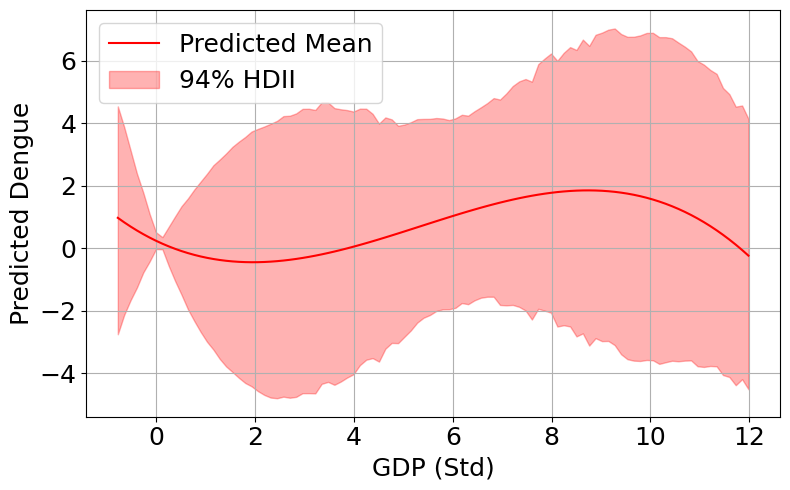

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

predictors = ["ERA5_t2m_std", "ERA5_tp_std", "gdp_std"]

map_names = {
    "ERA5_t2m_std": "Temperature (Std)",
    "ERA5_tp_std": "Precipitation (Std)",
    "pwg_log_std": "Plastic Waste Generated (Std)",
    "log_plas_litter_std": "Plastic Litter Emitted (Std)",
    "gdp_std": "GDP (Std)"
}

for var in predictors:
    x_vals = np.linspace(df_scaled[var].min(), df_scaled[var].max(), 100)

    # Create prediction dataframe with all means
    df_pred = pd.DataFrame({v: df_scaled[v].mean() for v in predictors}, index=range(100))
    df_pred[var] = x_vals  # vary current var
    df_pred["adm_0_name"] = df_scaled["adm_0_name"].mode()[0]  # known group

    # Predict
    pred = model_all_but_plastic_std_spline.predict(
        idata=idata9B,
        data=df_pred,
        kind="response_params",
        inplace=False
    )

    mu = pred.posterior["mu"]
    pred_mean = mu.mean(dim=["chain", "draw"]).values.flatten()
    pred_hdi = az.hdi(mu, hdi_prob=0.94)
    lower = pred_hdi["mu"].sel(hdi="lower").values.flatten()
    upper = pred_hdi["mu"].sel(hdi="higher").values.flatten()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, pred_mean, color="red", label="Predicted Mean")
    plt.fill_between(x_vals, lower, upper, color="red", alpha=0.3, label="94% HDII")
    plt.xlabel(map_names.get(var, var))
    plt.ylabel("Predicted Dengue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"9B_marginal_effect_all_but_plastic_std{var}.pdf"), format='pdf', dpi=3000)

    plt.show()

In [ ]:
import arviz as az

# Example: models using plastic litter
models = {
    "2a": idata2A,
    "2b": idata2B,
    "4a": idata4A,
    "4b": idata4B,
    "6a": idata6A,
    "6b": idata6B,
    "8a": idata8A,
    "8b": idata8B,
    "9B": idata9B
}

# Compare using WAIC
waic_results = az.compare(models, method="BB-pseudo-BMA", ic="waic")

# OR compare using LOO
loo_results = az.compare(models, method="BB-pseudo-BMA", ic="loo")

# Print the top-ranked model
print("Best model (plastic litter) by WAIC:")
print(waic_results.head())


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the

Best model (plastic litter) by WAIC:
    rank    elpd_waic     p_waic   elpd_diff         weight         se  \
8b     0 -7590.139324  41.893351    0.000000   6.306851e-01  65.271558   
6b     1 -7590.718858  42.552647    0.579534   3.693149e-01  65.409974   
8a     2 -8161.917785  14.542094  571.778461  2.300634e-178  56.143866   
6a     3 -8162.011854  14.618371  571.872530  2.159098e-178  56.133689   
9B     4 -8402.059746  26.569493  811.920422  1.011118e-286  68.792510   

          dse  warning scale  
8b   0.000000     True   log  
6b   0.461468     True   log  
8a  41.210580     True   log  
6a  41.229211     True   log  
9B  50.350010     True   log  


In [ ]:
waic_results

rank    elpd_waic     p_waic   elpd_diff         weight         se  \
8b     0 -7590.139324  41.893351    0.000000   6.306851e-01  65.271558   
6b     1 -7590.718858  42.552647    0.579534   3.693149e-01  65.409974   
8a     2 -8161.917785  14.542094  571.778461  2.300634e-178  56.143866   
6a     3 -8162.011854  14.618371  571.872530  2.159098e-178  56.133689   
9B     4 -8402.059746  26.569493  811.920422  1.011118e-286  68.792510   
4b     5 -8419.065627  15.317583  828.926304  1.641265e-279  53.010817   
2b     6 -8419.363943  15.506937  829.224619  1.088002e-279  52.980372   
2a     7 -8427.191108  12.088798  837.051784  2.199276e-284  53.189332   
4a     8 -8427.344550  12.283562  837.205227  1.922911e-284  53.199021   

          dse  warning scale  
8b   0.000000     True   log  
6b   0.461468     True   log  
8a  41.210580     True   log  
6a  41.229211     True   log  
9B  50.350010     True   log  
4b  49.029654     True   log  
2b  49.057812     True   log  
2a  49.225878     True   log  
4a  49.213858     True   log

In [ ]:
import arviz as az

# Example: models using plastic waste generator.
models = {
    "1a": idata1A,
    "1b": idata1B,
    "3a": idata3A,
    "3b": idata3B,
    "5a": idata5A,
    "5b": idata5B,
    "7a": idata7A,
    "7b": idata7B

}

# Compare using WAIC
waic_results_pwg = az.compare(models, method="BB-pseudo-BMA", ic="waic")

# OR compare using LOO
loo_results_pwg = az.compare(models, method="BB-pseudo-BMA", ic="loo")

# Print the top-ranked model
print("Best model (plastic litter) by WAIC:")
waic_results_pwg


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the

Best model (plastic litter) by WAIC:


<bound method NDFrame.head of     rank    elpd_waic     p_waic   elpd_diff         weight         se  \
7b     0 -7166.049757  45.155706    0.000000   7.095104e-01  70.990202   
5b     1 -7167.083406  46.406432    1.033649   2.904896e-01  71.275935   
5a     2 -7802.226412  15.242136  636.176654  4.314517e-197  54.272048   
7a     3 -7802.369900  15.356251  636.320143  4.079229e-197  54.298850   
1b     4 -8106.667704  15.917853  940.617947  1.184115e-312  53.624733   
3b     5 -8106.862096  16.144979  940.812339  8.052500e-313  53.685208   
1a     6 -8147.315633  12.604055  981.265875   0.000000e+00  53.040362   
3a     7 -8147.326094  12.588265  981.276337   0.000000e+00  53.043533   

          dse  warning scale  
7b   0.000000     True   log  
5b   0.863234     True   log  
5a  45.246158     True   log  
7a  45.289304     True   log  
1b  54.462830     True   log  
3b  54.451323     True   log  
1a  55.380817     True   log  
3a  55.381471     True   log  >

In [ ]:
import arviz as az

# Example: models using plastic waste generator.
models_all = {
    "1a": idata1A,
    "1b": idata1B,
    "3a": idata3A,
    "3b": idata3B,
    "5a": idata5A,
    "5b": idata5B,
    "7a": idata7A,
    "7b": idata7B,
    "2a": idata2A,
    "2b": idata2B,
    "4a": idata4A,
    "4b": idata4B,
    "6a": idata6A,
    "6b": idata6B,
    "8a": idata8A,
    "8b": idata8B,
    "9B": idata9B
}

# Compare using WAIC
waic_results_all = az.compare(models_all, method="BB-pseudo-BMA", ic="waic")

# OR compare using LOO
loo_results_all = az.compare(models_all, method="BB-pseudo-BMA", ic="loo")

# Print the top-ranked model
print("Best model (plastic litter) by WAIC:")
waic_results_all


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the

Best model (plastic litter) by WAIC:


rank    elpd_waic     p_waic    elpd_diff         weight         se  \
7b     0 -7166.049757  45.155706     0.000000   7.069518e-01  69.743271   
5b     1 -7167.083406  46.406432     1.033649   2.930482e-01  69.982907   
8b     2 -7590.139324  41.893351   424.089566  3.439381e-148  63.264082   
6b     3 -7590.718858  42.552647   424.669100  3.498312e-148  63.414921   
5a     4 -7802.226412  15.242136   636.176654  2.689371e-197  55.452590   
7a     5 -7802.369900  15.356251   636.320143  5.414619e-197  55.485184   
1b     6 -8106.667704  15.917853   940.617947  1.033877e-301  55.136771   
3b     7 -8106.862096  16.144979   940.812339  1.311124e-301  55.197639   
1a     8 -8147.315633  12.604055   981.265875  2.470328e-323  54.740067   
3a     9 -8147.326094  12.588265   981.276337  2.964394e-323  54.744269   
8a    10 -8161.917785  14.542094   995.868028   0.000000e+00  52.590881   
6a    11 -8162.011854  14.618371   995.962097   0.000000e+00  52.586459   
9B    12 -8402.059746  26.569493  1236.009989   0.000000e+00  67.019445   
4b    13 -8419.065627  15.317583  1253.015870   0.000000e+00  50.933150   
2b    14 -8419.363943  15.506937  1253.314186   0.000000e+00  50.915821   
2a    15 -8427.191108  12.088798  1261.141351   0.000000e+00  50.985401   
4a    16 -8427.344550  12.283562  1261.294793   0.000000e+00  50.990339   

          dse  warning scale  
7b   0.000000     True   log  
5b   0.863234     True   log  
8b  30.637436     True   log  
6b  30.623990     True   log  
5a  45.246158     True   log  
7a  45.289304     True   log  
1b  54.462830     True   log  
3b  54.451323     True   log  
1a  55.380817     True   log  
3a  55.381471     True   log  
8a  53.414417     True   log  
6a  53.433758     True   log  
9B  63.570172     True   log  
4b  58.531340     True   log  
2b  58.559198     True   log  
2a  58.771618     True   log  
4a  58.757007     True   log

In [ ]:
import arviz as az
import pandas as pd

# Models
models_all = {
    "1a": idata1A,
    "1b": idata1B,
    "2a": idata2A,
    "2b": idata2B,
    "3a": idata3A,
    "3b": idata3B,
    "4a": idata4A,
    "4b": idata4B,
    "5a": idata5A,
    "5b": idata5B,
    "6a": idata6A,
    "6b": idata6B,
    "7a": idata7A,
    "7b": idata7B,
    "8a": idata8A,
    "8b": idata8B,
    "9B": idata9B
}

# Feature names you want to track (standardized names)
target_features = ["pwg_log_std", "bs(pwg_log_std, df=3)[0]", "bs(pwg_log_std, df=3)[1]", "bs(pwg_log_std, df=3)[2]"
                   "log_plas_litter_std", "bs(log_plas_litter_std, df=3)[0]", "bs(log_plas_litter_std, df=3)[1]",
                   "bs(log_plas_litter_std, df=3)[2]" ]

# Collect results
results = []

for model_name, idata in models_all.items():
    try:
        summary = az.summary(idata)
        # Filter for plastic-related or pwg features
        found = summary.loc[summary.index.intersection(target_features)]
        for var_name, row in found.iterrows():
            results.append({
                "model": model_name,
                "feature": var_name,
                "mean": row["mean"],
                "sd": row["sd"],
                "hdi_3%": row["hdi_3%"],
                "hdi_97%": row["hdi_97%"],
                "r_hat": row["r_hat"],
                "abs_mean": abs(row["mean"]),
                "excludes_zero": row["hdi_3%"] * row["hdi_97%"] > 0  # both same sign
            })
    except Exception as e:
        print(f"Failed on model {model_name}: {e}")

# Convert to DataFrame
df_features = pd.DataFrame(results)

# Sort by abs(mean effect size)
ranked = df_features.sort_values(by="abs_mean", ascending=False)

ranked.head(17)

# Show top results
# import ace_tools as tools; tools.display_dataframe_to_user(name="Ranked Feature Effects", dataframe=ranked)


model                           feature   mean     sd  hdi_3%  hdi_97%  \
11    4b  bs(log_plas_litter_std, df=3)[2]  3.812  0.534   2.837    4.844   
5     2b  bs(log_plas_litter_std, df=3)[2]  3.748  0.536   2.739    4.736   
23    8b  bs(log_plas_litter_std, df=3)[2]  3.718  0.477   2.849    4.633   
17    6b  bs(log_plas_litter_std, df=3)[2]  3.672  0.470   2.821    4.558   
16    6b  bs(log_plas_litter_std, df=3)[1]  3.207  0.254   2.728    3.678   
22    8b  bs(log_plas_litter_std, df=3)[1]  3.187  0.256   2.707    3.669   
4     2b  bs(log_plas_litter_std, df=3)[1]  3.112  0.288   2.569    3.645   
10    4b  bs(log_plas_litter_std, df=3)[1]  3.084  0.286   2.539    3.608   
13    5b          bs(pwg_log_std, df=3)[0] -2.648  0.450  -3.466   -1.776   
19    7b          bs(pwg_log_std, df=3)[0] -2.632  0.442  -3.442   -1.791   
2     1b          bs(pwg_log_std, df=3)[1]  1.891  0.163   1.594    2.201   
8     3b          bs(pwg_log_std, df=3)[1]  1.885  0.166   1.579    2.204   
14    5b          bs(pwg_log_std, df=3)[1]  1.526  0.145   1.242    1.779   
20    7b          bs(pwg_log_std, df=3)[1]  1.517  0.147   1.241    1.796   
1     1b          bs(pwg_log_std, df=3)[0] -1.325  0.511  -2.285   -0.401   
7     3b          bs(pwg_log_std, df=3)[0] -1.305  0.515  -2.287   -0.342   
0     1a                       pwg_log_std  0.533  0.011   0.512    0.553   

    r_hat  abs_mean  excludes_zero  
11    1.0     3.812           True  
5     1.0     3.748           True  
23    1.0     3.718           True  
17    1.0     3.672           True  
16    1.0     3.207           True  
22    1.0     3.187           True  
4     1.0     3.112           True  
10    1.0     3.084           True  
13    1.0     2.648           True  
19    1.0     2.632           True  
2     1.0     1.891           True  
8     1.0     1.885           True  
14    1.0     1.526           True  
20    1.0     1.517           True  
1     1.0     1.325           True  
7     1.0     1.305           True  
0     1.0     0.533           True

In [ ]:
import arviz as az
import pandas as pd

# Your model dictionary
models_all = {
    "1a": idata1A, "1b": idata1B,
    "2a": idata2A, "2b": idata2B,
    "3a": idata3A, "3b": idata3B,
    "4a": idata4A, "4b": idata4B,
    "5a": idata5A, "5b": idata5B,
    "6a": idata6A, "6b": idata6B,
    "7a": idata7A, "7b": idata7B,
    "8a": idata8A, "8b": idata8B,
    "9B": idata9B
}

# Collect results
results = []

for model_name, idata in models_all.items():
    try:
        summary = az.summary(idata)

        # Automatically find all pwg or plastic litter-related features, including spline terms
        selected_vars = [v for v in summary.index
                         if "pwg" in v or "plas_litter" in v]

        for var_name in selected_vars:
            row = summary.loc[var_name]
            results.append({
                "model": model_name,
                "feature": var_name,
                "mean": row["mean"],
                "sd": row["sd"],
                "hdi_3%": row["hdi_3%"],
                "hdi_97%": row["hdi_97%"],
                "r_hat": row["r_hat"],
                "abs_mean": abs(row["mean"]),
                "excludes_zero": row["hdi_3%"] * row["hdi_97%"] > 0
            })
    except Exception as e:
        print(f"Error with model {model_name}: {e}")

# Convert to DataFrame
df_features = pd.DataFrame(results)

# Sort by absolute effect size
ranked = df_features.sort_values(by="abs_mean", ascending=False)

# Show top results
ranked

model                           feature   mean     sd  hdi_3%  hdi_97%  \
15    4b  bs(log_plas_litter_std, df=3)[2]  3.812  0.534   2.837    4.844   
7     2b  bs(log_plas_litter_std, df=3)[2]  3.748  0.536   2.739    4.736   
31    8b  bs(log_plas_litter_std, df=3)[2]  3.718  0.477   2.849    4.633   
23    6b  bs(log_plas_litter_std, df=3)[2]  3.672  0.470   2.821    4.558   
11    3b          bs(pwg_log_std, df=3)[2]  3.345  0.441   2.500    4.154   
3     1b          bs(pwg_log_std, df=3)[2]  3.318  0.430   2.472    4.053   
22    6b  bs(log_plas_litter_std, df=3)[1]  3.207  0.254   2.728    3.678   
30    8b  bs(log_plas_litter_std, df=3)[1]  3.187  0.256   2.707    3.669   
6     2b  bs(log_plas_litter_std, df=3)[1]  3.112  0.288   2.569    3.645   
14    4b  bs(log_plas_litter_std, df=3)[1]  3.084  0.286   2.539    3.608   
27    7b          bs(pwg_log_std, df=3)[2]  2.704  0.375   1.992    3.402   
19    5b          bs(pwg_log_std, df=3)[2]  2.682  0.384   1.972    3.418   
17    5b          bs(pwg_log_std, df=3)[0] -2.648  0.450  -3.466   -1.776   
25    7b          bs(pwg_log_std, df=3)[0] -2.632  0.442  -3.442   -1.791   
2     1b          bs(pwg_log_std, df=3)[1]  1.891  0.163   1.594    2.201   
10    3b          bs(pwg_log_std, df=3)[1]  1.885  0.166   1.579    2.204   
18    5b          bs(pwg_log_std, df=3)[1]  1.526  0.145   1.242    1.779   
26    7b          bs(pwg_log_std, df=3)[1]  1.517  0.147   1.241    1.796   
1     1b          bs(pwg_log_std, df=3)[0] -1.325  0.511  -2.285   -0.401   
9     3b          bs(pwg_log_std, df=3)[0] -1.305  0.515  -2.287   -0.342   
0     1a                       pwg_log_std  0.533  0.011   0.512    0.553   
8     3a                       pwg_log_std  0.533  0.011   0.513    0.556   
24    7a                       pwg_log_std  0.530  0.011   0.510    0.551   
16    5a                       pwg_log_std  0.529  0.011   0.509    0.549   
12    4a               log_plas_litter_std  0.475  0.012   0.453    0.499   
4     2a               log_plas_litter_std  0.475  0.012   0.452    0.498   
20    6a               log_plas_litter_std  0.457  0.012   0.434    0.478   
28    8a               log_plas_litter_std  0.457  0.012   0.435    0.480   
13    4b  bs(log_plas_litter_std, df=3)[0]  0.357  0.265  -0.148    0.846   
5     2b  bs(log_plas_litter_std, df=3)[0]  0.344  0.269  -0.148    0.861   
21    6b  bs(log_plas_litter_std, df=3)[0] -0.032  0.237  -0.470    0.411   
29    8b  bs(log_plas_litter_std, df=3)[0] -0.020  0.236  -0.458    0.440   

    r_hat  abs_mean  excludes_zero  
15    1.0     3.812           True  
7     1.0     3.748           True  
31    1.0     3.718           True  
23    1.0     3.672           True  
11    1.0     3.345           True  
3     1.0     3.318           True  
22    1.0     3.207           True  
30    1.0     3.187           True  
6     1.0     3.112           True  
14    1.0     3.084           True  
27    1.0     2.704           True  
19    1.0     2.682           True  
17    1.0     2.648           True  
25    1.0     2.632           True  
2     1.0     1.891           True  
10    1.0     1.885           True  
18    1.0     1.526           True  
26    1.0     1.517           True  
1     1.0     1.325           True  
9     1.0     1.305           True  
0     1.0     0.533           True  
8     1.0     0.533           True  
24    1.0     0.530           True  
16    1.0     0.529           True  
12    1.0     0.475           True  
4     1.0     0.475           True  
20    1.0     0.457           True  
28    1.0     0.457           True  
13    1.0     0.357          False  
5     1.0     0.344          False  
21    1.0     0.032          False  
29    1.0     0.020          False

### For sensitivity analysis

## Compare multiple models visually

In [ ]:
import arviz as az
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100
    return mae, rmse, mape

model_names = ["model_plas_litter_all_std_spline", "model_2a", "model_2b", "model_3", "model_4", "model_5"]
results = {}

for name in model_names:
    try:
        idata = az.from_netcdf(f"{name}.nc")

        # Try to extract observed values
        y_true = idata.observed_data["mean_dengue_2014_2023"].values

        # Take posterior predictive mean over draws and chains
        y_pred = idata.posterior_predictive["mean_dengue_2014_2023"].mean(dim=("chain", "draw")).values

        mae, rmse, mape = compute_metrics(y_true, y_pred)
        results[name] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

    except Exception as e:
        results[name] = {"MAE": None, "RMSE": None, "MAPE": None, "Error": str(e)}

# Display results
metrics_df = pd.DataFrame(results).T
metrics_df


MAE  RMSE  MAPE  \
model_plas_litter_all_std_spline  None  None  None   
model_2a                          None  None  None   
model_2b                          None  None  None   
model_3                           None  None  None   
model_4                           None  None  None   
model_5                           None  None  None   

                                                                              Error  
model_plas_litter_all_std_spline  [Errno 2] Unable to synchronously open file (u...  
model_2a                          [Errno 2] Unable to synchronously open file (u...  
model_2b                          [Errno 2] Unable to synchronously open file (u...  
model_3                           [Errno 2] Unable to synchronously open file (u...  
model_4                           [Errno 2] Unable to synchronously open file (u...  
model_5                           [Errno 2] Unable to synchronously open file (u...

In [ ]:



import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# List your model variable names and their labels
models = {
    "model_1b": idata1B,
    "model_2a": idata5A,
    "model_2b": idata5B,
    "model_3": idata7B,
    "model_plas_litter_all_std_spline": idata8B,

}

# Ground truth values
y_true = df_scaled["log_dengue_std"].values

# Container for results
metrics = []

# Loop through all models
for label, result in models.items():
    try:
        # Predictive means
        ppc = result.model.predict(idata=result, kind="response", inplace=False)
        y_pred = ppc.posterior_predictive["log_dengue_std"].mean(dim=("chain", "draw")).values

        # Metrics
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

        metrics.append({
            "Model": label,
            "MAE": round(mae, 3),
            "RMSE": round(rmse, 3),
            "MAPE": round(mape, 3)
        })
    except Exception as e:
        metrics.append({
            "Model": label,
            "MAE": None,
            "RMSE": None,
            "MAPE": None,
            "Error": str(e)
        })

# Display as DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


                              Model   MAE  RMSE  MAPE  \
0                          model_1b  None  None  None   
1                          model_2a  None  None  None   
2                          model_2b  None  None  None   
3                           model_3  None  None  None   
4  model_plas_litter_all_std_spline  None  None  None   

                                             Error  
0  'InferenceData' object has no attribute 'model'  
1  'InferenceData' object has no attribute 'model'  
2  'InferenceData' object has no attribute 'model'  
3  'InferenceData' object has no attribute 'model'  
4  'InferenceData' object has no attribute 'model'  
